# IMPORTING THE LIBRARIES

In [1]:
from zipfile import ZipFile
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
import numpy as np
import librosa.display
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, Flatten,\
 Dense, Input, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from scipy.io.wavfile import write
from matplotlib.cbook import boxplot_stats
import math
import soundfile as sf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

# IMPORTING DATA FROM THE ZIP FILE

In [ ]:
zf = ZipFile('/content/drive/MyDrive/Database_final.zip', 'r')

## Loading the real audio segments

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
OUT_DIR = '/content/drive/MyDrive/audio-datasets-ICBHI/'
# DIAGNOSIS_FILE = '/content/drive/MyDrive/Respiratory Disease Detection/ICBHI-Dataset/Database/patient_diagnosis.csv'
# diagnosis = pd.read_csv(DIAGNOSIS_FILE)

## Loading the synthetic data generated by VAEs

In [4]:
X_syn_cvae, y_syn_cvae = np.load(OUT_DIR + 'CVAE-syn-mfcc.npy'), np.load(OUT_DIR + 'CVAE-syn-labels.npy')
X_syn_mlpvae, y_syn_mlpvae = np.load(OUT_DIR + 'MLP-VAE-syn-mfcc.npy'), np.load(OUT_DIR + 'MLP-VAE-syn-labels.npy')
X_syn_cnnvae, y_syn_cnnvae = np.load(OUT_DIR + 'CNN-VAE-syn-mfcc.npy'), np.load(OUT_DIR + 'CNN-VAE-syn-labels.npy')
X_syn_cvae.shape

(32564, 13, 259)

In [ ]:
X_syn_mixed = np.concatenate((X_syn_cvae[np.where( y_syn_cvae == 'Bronchiectasis')],
X_syn_cvae[np.where( y_syn_cvae == 'Bronchiolitis')],
X_syn_cnnvae[np.where( y_syn_cnnvae == 'Healthy')],
X_syn_mlpvae[np.where( y_syn_mlpvae == 'LRTI')],
X_syn_cnnvae[np.where( y_syn_cnnvae == 'URTI')],
X_syn_cvae[np.where(y_syn_cvae == 'Pneumonia')]))


y_syn_mixed = np.concatenate((y_syn_cvae[np.where( y_syn_cvae == 'Bronchiectasis')],
y_syn_cvae[np.where( y_syn_cvae == 'Bronchiolitis')],
y_syn_cnnvae[np.where( y_syn_cnnvae == 'Healthy')],
y_syn_mlpvae[np.where( y_syn_mlpvae == 'LRTI')],
y_syn_cnnvae[np.where( y_syn_cnnvae == 'URTI')],
y_syn_cvae[np.where(y_syn_cvae == 'Pneumonia')]))

pd.Series(y_syn_mixed).value_counts()

LRTI              5609
Bronchiectasis    5476
Bronchiolitis     5476
URTI              5400
Pneumonia         5329
Healthy           5324
dtype: int64

In [ ]:
}zf.extractall()

# ANALYSIS OF ZIP FILE

In [ ]:
df = pd.read_csv('/content/Database/patient_diagnosis.csv')
df.columns = ['Id', 'Diagnosis']
df.head()

Id Diagnosis
0  101      URTI
1  102   Healthy
2  103    Asthma
3  104      COPD
4  105      URTI

In [ ]:
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
p = list()
diag = list()
path_file = pd.DataFrame()
for path in os.listdir('/content/Database/audio_and_txt_files'):
    if path.endswith('.wav'):
        diagnosis = df[df['Id'] == int(path[0:3])]['Diagnosis'].values[0]
        p.append(path)
        diag.append(diagnosis)
path_file = pd.DataFrame(list(zip(p, diag)), columns=['Path', 'Diagnosis'])

In [ ]:
path_file.head()

Path Diagnosis
0  170_1b2_Ar_mc_AKGC417L.wav      COPD
1  218_1p1_Pl_sc_Litt3200.wav      COPD
2  130_1p4_Al_mc_AKGC417L.wav      COPD
3  138_2p2_Ar_mc_AKGC417L.wav      COPD
4  178_1b6_Ar_mc_AKGC417L.wav      COPD

In [ ]:
path_file['Diagnosis'].value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

In [ ]:
920-793

127

CONCLUSION: DATASET IS HIGHLY IMBALANCED

# SEGMENTATION

retrieving the text files

In [ ]:

audio_text_loc = '/content/Database/audio_and_txt_files'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_loc) if '.txt' in s]

In [ ]:
def tokenize_file(filename):
    return filename.split('_')

In [ ]:
files_ = []
for f in files:
    df1 = pd.read_csv(audio_text_loc + '/' + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df1['filename'] = f
    #get filename features
    f_features = tokenize_file(f)
    df1['Id'] = f_features[0]
    df1['ac_mode'] = f_features[3]
    
    files_.append(df1)
    
files_df = pd.concat(files_)
files_df.reset_index()
files_df.head()


start     end  crackles  wheezes                filename   Id ac_mode
0  0.411   2.351         1        1  203_1p2_Lr_mc_AKGC417L  203      mc
1  2.351   4.327         1        1  203_1p2_Lr_mc_AKGC417L  203      mc
2  4.327   6.482         1        0  203_1p2_Lr_mc_AKGC417L  203      mc
3  6.482   8.470         1        1  203_1p2_Lr_mc_AKGC417L  203      mc
4  8.470  10.566         1        0  203_1p2_Lr_mc_AKGC417L  203      mc

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         126 non-null    int64 
 1   Diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   Id        6898 non-null   object 
 6   ac_mode   6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
files_df['Id'] = files_df['Id'].astype('float64')
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   Id        6898 non-null   float64
 6   ac_mode   6898 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 431.1+ KB


In [ ]:
files_df = pd.merge(files_df, df, on='Id')
files_df.head()

start     end  crackles  ...     Id ac_mode  Diagnosis
0  0.411   2.351         1  ...  203.0      mc       COPD
1  2.351   4.327         1  ...  203.0      mc       COPD
2  4.327   6.482         1  ...  203.0      mc       COPD
3  6.482   8.470         1  ...  203.0      mc       COPD
4  8.470  10.566         1  ...  203.0      mc       COPD

[5 rows x 8 columns]

Function to segment the audio file

In [ ]:
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

Obtaining the max length of the segment

In [ ]:
files_df['len_per_slice'] = files_df['end'].sub(files_df['start'], axis = 0) 
max_len_per_slice = max(files_df['len_per_slice'])
print(max_len_per_slice)

16.163


This length is not  a practical length for breathing sound hence we try to obtain a more practical length 

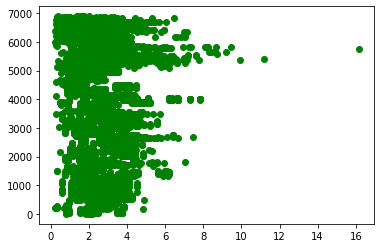

In [ ]:
plt.scatter(files_df['len_per_slice'], y=files_df.index, color='g')

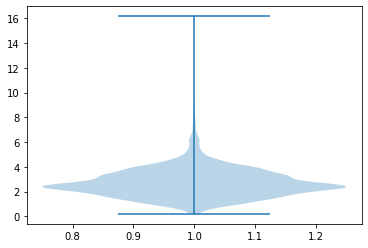

In [ ]:
box = plt.violinplot(files_df['len_per_slice'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


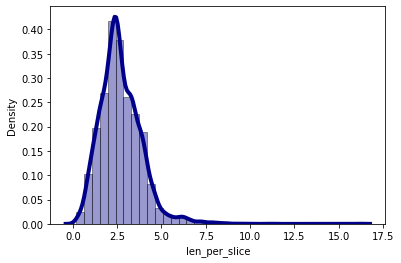

In [ ]:
import seaborn as sns

sns.distplot(files_df['len_per_slice'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

We can see that the optimal max breathing sound range is 6 seconds though majority of the audio sets peak to 2.5 seconds

In [ ]:
force_max_len = math.ceil(boxplot_stats(files_df['len_per_slice'])[0]['whishi'])
print('Max length of breathing sound that can be considered is:', force_max_len)

Max length of breathing sound that can be considered is: 6


In [ ]:
os.mkdir('/content/drive/MyDrive/segmented-audio')

FileExistsError: ignored

In [ ]:
files_df.head()

start     end  crackles  wheezes  ...     Id  ac_mode Diagnosis len_per_slice
0  0.411   2.351         1        1  ...  203.0       mc      COPD         1.940
1  2.351   4.327         1        1  ...  203.0       mc      COPD         1.976
2  4.327   6.482         1        0  ...  203.0       mc      COPD         2.155
3  6.482   8.470         1        1  ...  203.0       mc      COPD         1.988
4  8.470  10.566         1        0  ...  203.0       mc      COPD         2.096

[5 rows x 9 columns]

In [ ]:
i = 0
for idx, row in files_df.iterrows():
    filename = row['filename']
    start = row['start']
    end = row['end']
    diag = row['Diagnosis']
    
    #check len and skip if greater than 6 seconds.
    if force_max_len < end - start:
        continue
        end = start + force_max_len
    
    aud_loc = audio_text_loc + '/' + filename + '.wav'
    
    if idx != 0:
        if files_df.iloc[idx-1]['filename'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = '/content/drive/MyDrive/segmented-audio/' + n_filename

    data, samplingrate = lb.load(aud_loc)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
    #pad audio if < forced_max_len
    padded_data = lb.util.fix_length(sliced_data, force_max_len*samplingrate)
    sf.write(file=path, data=padded_data, samplerate=samplingrate)


In [ ]:
import IPython.display as ipd
ipd.Audio('/content/drive/MyDrive/segmented-audio/151_2p3_Ar_mc_AKGC417L_1.wav')

Checking the data per class

In [ ]:
path_name = list()
diagnosis = list()
for i in os.listdir('/content/drive/MyDrive/segmented-audio'):
    path_name.append(os.path.join('/content/drive/MyDrive/segmented-audio/', i))
    diagnosis.append(df[df['Id'] == int(i[0:3])]['Diagnosis'].values[0])
segmented_df = pd.DataFrame({
    'Path': path_name,
    'Diagnosis': diagnosis
})
segmented_df.head()

Path Diagnosis
0  /content/drive/MyDrive/segmented-audio/156_2b3...      COPD
1  /content/drive/MyDrive/segmented-audio/156_2b3...      COPD
2  /content/drive/MyDrive/segmented-audio/156_2b3...      COPD
3  /content/drive/MyDrive/segmented-audio/156_2b3...      COPD
4  /content/drive/MyDrive/segmented-audio/156_2b3...      COPD

displaying the segmented audio

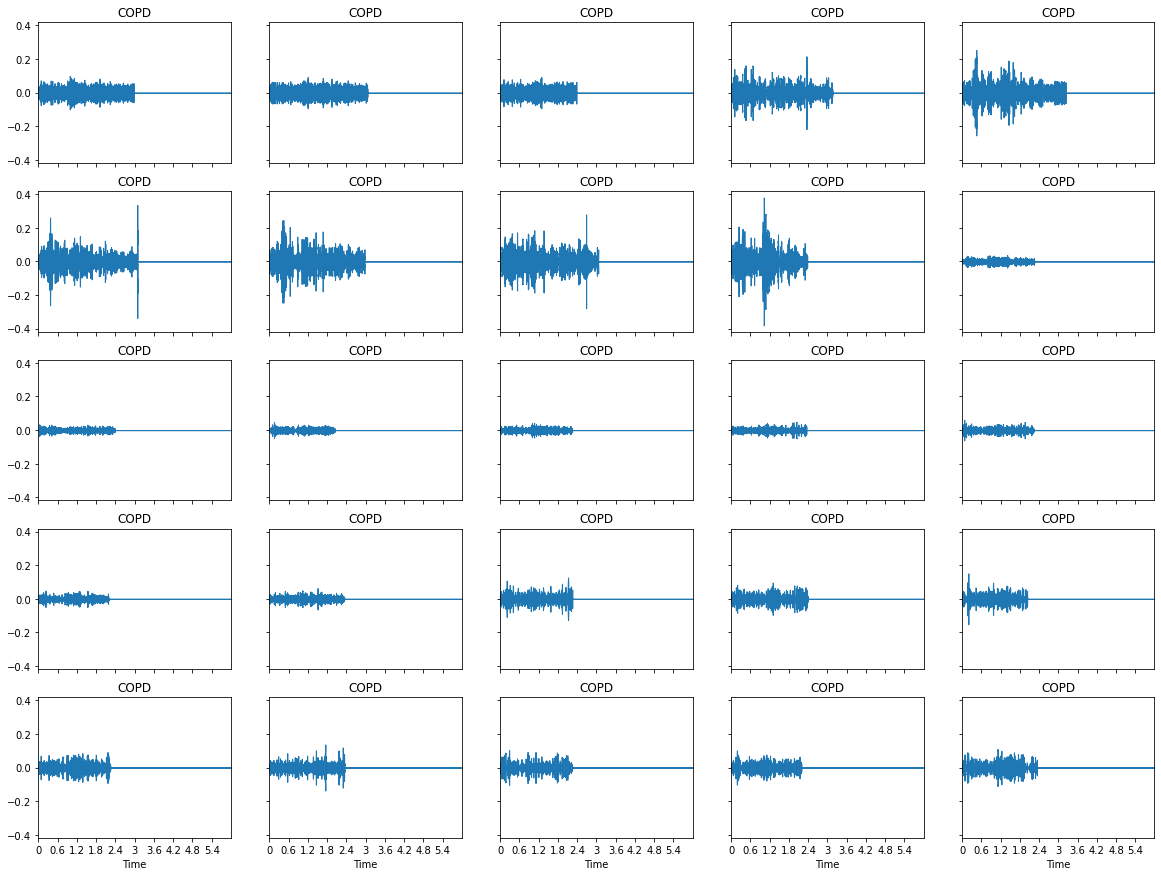

In [ ]:
row = 0 
col = 0
fig, ax = plt.subplots(nrows=5,ncols=5, sharex=True, sharey=True, figsize=(20,15))
for i in os.listdir('/content/drive/MyDrive/segmented-audio/'):
    y, sr = librosa.load(os.path.join('/content/drive/MyDrive/segmented-audio/', i))
    diag = segmented_df[segmented_df['Path'] == os.path.join('/content/drive/MyDrive/segmented-audio/', i)]['Diagnosis'].values[0]
    librosa.display.waveplot(y, sr=sr, ax=ax[row][col])
    ax[row][col].set(title=diag)
    ax[row][col].label_outer()
    col = col + 1
    if col == 5:
        row = row + 1
        col = 0
    if row == 5:
        break
        

The count per class is as follows

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


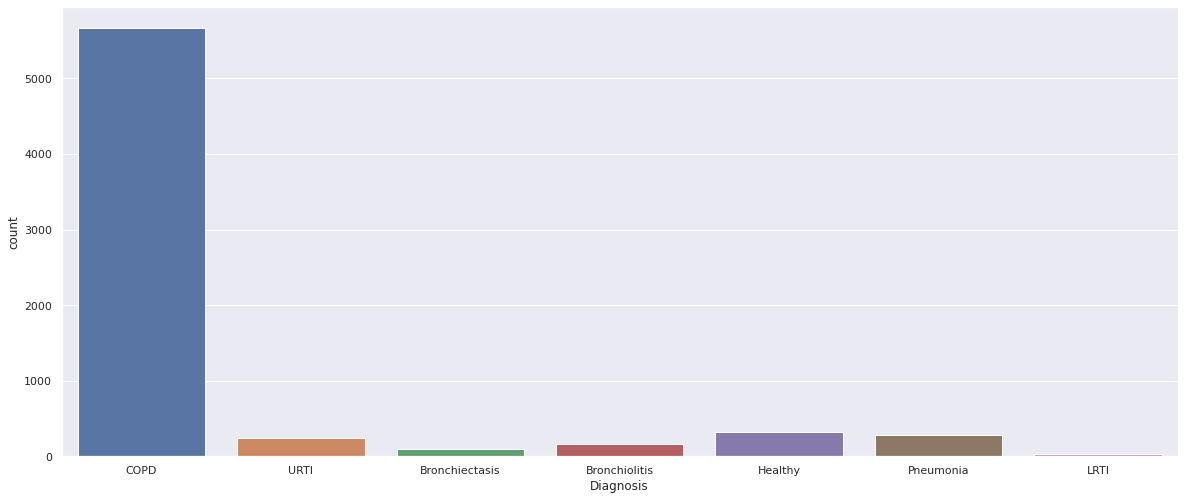

In [ ]:
sns.set(rc={'figure.figsize':(20,8.27)});
segmented_d = segmented_df[segmented_df['Diagnosis']!='Asthma']
sns.countplot(segmented_d["Diagnosis"]);

The numbers after segmentation are as follows:

In [ ]:
segmented_d['Diagnosis'].value_counts()

COPD              5665
Healthy            317
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     101
LRTI                32
Name: Diagnosis, dtype: int64

In [ ]:
m = librosa.feature.melspectrogram(y=signal, sr=sr)

In [ ]:
row = 0 
col = 0
fig, ax = plt.subplots(nrows=6,ncols=1, sharex=True, sharey=True, figsize=(20,15))
for i in os.listdir('/content/drive/MyDrive/segmented-audio/'):
    y, sr = librosa.load(os.path.join('/content/drive/MyDrive/segmented-audio/', i))
    diag = segmented_df[segmented_df['Path'] == os.path.join('/content/drive/MyDrive/segmented-audio/', i)]['Diagnosis'].values[0]
    librosa.display.waveplot(y, sr=sr, ax=ax[row][col])
    ax[row][col].set(title=diag)
    ax[row][col].label_outer()
    col = col + 1
    if col == 5:
        row = row + 1
        col = 0
    if row == 5:
        break

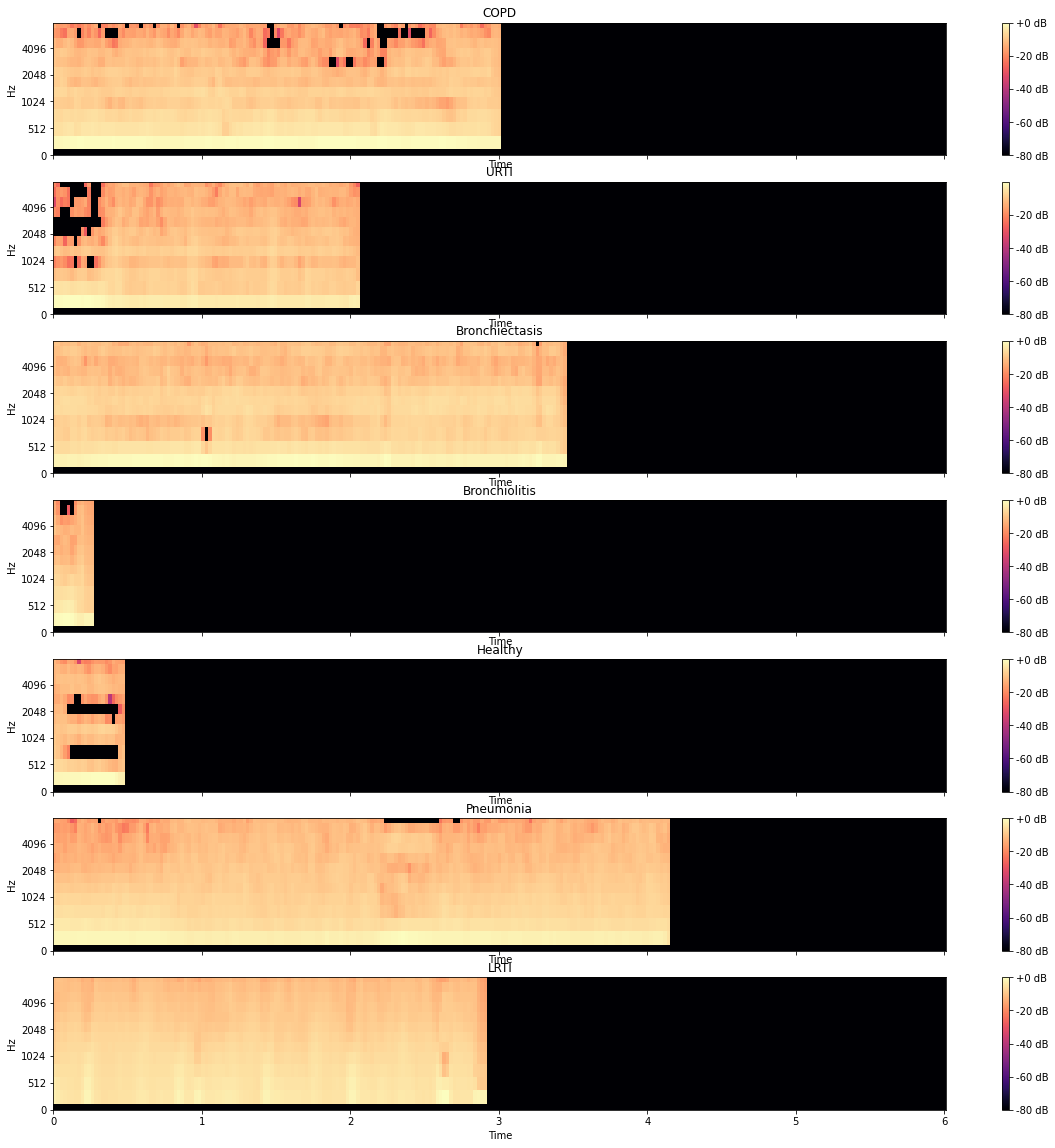

In [ ]:
row = 0 

fig, ax = plt.subplots(nrows=7,ncols=1, sharex=True, sharey=True, figsize=(20,20))
for diagnosis in segmented_df['Diagnosis'].unique():

    if  diagnosis!='Asthma':
        path=(segmented_df[segmented_df['Diagnosis']==diagnosis].values[0][0])
        y , sr = librosa.load(path)
        m = librosa.feature.mfcc(y, n_mfcc = 13, sr=sr)
        S_dB = librosa.power_to_db(m, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[row])
        fig.colorbar(img, ax=ax[row], format='%+2.0f dB')
        ax[row].set(title=diagnosis)
        row = row+ 1

    

# TIME DOMAIN FEATURES

In [ ]:
class TimeDomainFeatures:
    def __init__(self, path, offset=0):
        self.path = path
        self.FRAME_SIZE = 1024
        self.HOP_LENGTH = 512
        self.sr = 2000
        self.offset=offset
        
    def load(self):
        music, sr = lb.load(self.path, sr=self.sr, offset=self.offset, duration=3)
        return music, sr
    def amplitude_envelope(self):
        """
        It is the change in the amplitude of sound over time. Calculate amplitude envelope
        return: numpy array
        """
        music, _ = self.load()
        amplitude_envelope = list()
        for i in range(0, len(music), self.HOP_LENGTH):
            current_amplitude = max(music[i:i+self.FRAME_SIZE])
            amplitude_envelope.append(current_amplitude)
        return np.array(amplitude_envelope)
    def rms(self):
        """
        return: numpy array
        """
        music, _ = self.load()
        return librosa.feature.rms(music, frame_length=self.FRAME_SIZE, hop_length=self.HOP_LENGTH)[0]
    def zcr(self):
        music, _ = self.load()
        """
        values are normalised multiply by the frame length to get the actual value
        """
        return librosa.feature.zero_crossing_rate(music, frame_length=self.FRAME_SIZE, hop_length=self.HOP_LENGTH)[0]
    def temp(self):
        """
        Tempogram is the speed of the musical piece
        """
        music, _ = self.load()
        onset_envelope = librosa.onset.onset_strength(music, hop_length=self.HOP_LENGTH)
        tempo = librosa.beat.tempo(music, onset_envelope=onset_envelope)[0]
        return tempo, onset_envelope
        

# FREQUENCY DOMAIN FEATURE CLASS

In [ ]:
class FrequencyDomainFeatures:
    def __init__(self, path, offset=0):
        self.path = path
        self.sampling_rate = 22050
        self.hop_length = 512
        self.frame_size = 2048
        self.offset=offset
        
    def load(self):
        music, sr = lb.load(self.path, sr=self.sampling_rate, offset=self.offset, duration=3)
        return music,sr
    def mfcc(self ,sampling_rate=22050, n_mfcc=13):
        music, _ = self.load()
        mfccs = librosa.feature.mfcc(music, n_mfcc = n_mfcc, sr=sampling_rate)
        mfccs_mean_var = []
        #Compute the mean and variance of each MFCC across the different frames
        for i in range(n_mfcc):
            mfccs_mean_var.append([mfccs[i].mean(), mfccs[i].var()])
        return mfccs, mfccs_mean_var
    def chroma_features(self):
        music, _  = self.load()
        chromagram = librosa.feature.chroma_stft(music, sr=self.sampling_rate, 
                                                 hop_length=self.hop_length)
        chromagram_mean_var = [chromagram.mean(), chromagram.var()]
        return chromagram_mean_var, chromagram
    def getSpectralCentroid(self):
        music, _  = self.load()
        spectral_centroids = librosa.feature.spectral_centroid(music, sr=self.sampling_rate,
                                                              n_fft=self.frame_size, 
                                                              hop_length=self.hop_length)
        return [spectral_centroids.mean(), spectral_centroids.var()], spectral_centroids
    def getSpectralBandwidth(self):
        music, _  = self.load()
        spectral_bandwidths = librosa.feature.spectral_bandwidth(music, sr=self.sampling_rate,
                                                                 n_fft=self.frame_size,
                                                                 hop_length=self.hop_length)
        return [spectral_bandwidths.mean(), spectral_bandwidths.var()], spectral_bandwidths
    def getSpectralContrast(self):
        music, _  = self.load()
        spectral_contrast = librosa.feature.spectral_contrast(music, sr=self.sampling_rate,
                                                              n_fft=self.frame_size,
                                                              hop_length=self.hop_length)
        return [spectral_contrast.mean(), spectral_contrast.var()], spectral_contrast
    def getSpectralRollOff(self):
        music, _  = self.load()
        spectral_rolloff = librosa.feature.spectral_rolloff(music, sr=self.sampling_rate,
                                                            n_fft=self.frame_size,
                                                            hop_length=self.hop_length)
        return [spectral_rolloff.mean(), spectral_rolloff.var()], spectral_rolloff, music
        
        

# FEATURE EXTRACTION

In [ ]:
X = list()
y = list()
X_stft = list()
max_dimension = 0
for index, row in segmented_df.iterrows():
    if row['Diagnosis'] == 'Asthma':
        continue
    else:
        f1 = FrequencyDomainFeatures(row['Path'])
        mfccs, _ = f1.mfcc()
        X.append(mfccs)
        y.append(row['Diagnosis'])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print('Shape of X is : ', X.shape)
print('Shape of y is : ', y.shape)

Shape of X is :  (6799, 13, 130)
Shape of y is :  (6799,)


# LABEL ENCODING

# SPLITTING OF THE DATA

##  **IMPORTANT** : 



### 1.   Don't create a validation set because we're not doing any hyperparameter tuning! Let's use that fraction of data for training purpose.

### 2. Also, load training and testing sets from the drive folder instead of creating new training and testing sets daily.... It will be good to maintain  consistent train and test sets.

### 3.   X_train and X_test contain the MFCCs of the real audio segments whereas y_train and y_test contain corresponding labels in string format which should be one-hot encoded before training models



In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
#                                                     random_state=0, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                   test_size=0.3, random_state=0, stratify=y_train)

In [ ]:
# np.save(OUT_DIR + 'X_train.npy', X_train)
# np.save(OUT_DIR + 'y_train.npy', y_train)
# np.save(OUT_DIR + 'X_test.npy', X_test)
# np.save(OUT_DIR + 'y_test.npy', y_test)

In [5]:
X_train = np.load(OUT_DIR + 'X_train.npy')
X_test = np.load(OUT_DIR + 'X_test.npy')
y_train = np.load(OUT_DIR + 'y_train.npy')
y_test = np.load(OUT_DIR + 'y_test.npy')

In [6]:
le = LabelEncoder()
y_le=le.fit_transform(y_train)
y_le=np_utils.to_categorical(y_le)

In [7]:
print(le.classes_)

['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI' 'Pneumonia'
 'URTI']


In [8]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train :', y_train.shape)
# print('Shape of X_val :', X_val.shape)
# print('Shape of y_val :', y_val.shape)
print('Shape of X_test :', X_test.shape)
print('Shape of y_test : ', y_test.shape)

Shape of X_train: (4758, 13, 259)
Shape of y_train : (4758,)
Shape of X_test : (2040, 13, 259)
Shape of y_test :  (2040,)


In [ ]:
pd.Series(y_test).value_counts()

COPD              1700
Healthy             95
Pneumonia           85
URTI                72
Bronchiolitis       48
Bronchiectasis      30
LRTI                10
dtype: int64

In [ ]:
pd.Series(y_train).value_counts()

COPD              3965
Healthy            222
Pneumonia          199
URTI               168
Bronchiolitis      111
Bronchiectasis      71
LRTI                22
dtype: int64

In [ ]:
np.argmax(y_train)

2

# CROSS VALIDATIONN

# MODEL CLASS

In [17]:
class Model2():
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

    def ANN(self):
        model = keras.Sequential([
              keras.layers.Flatten(input_shape=(self.X_train.shape[1],
                                                self.X_train.shape[2])),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(1024, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.4),
               
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(7, activation='softmax')    
                ])
        return model
    def CNN(self):
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                      activation='relu',
                input_shape=(self.X_train.shape[1],self.X_train.shape[2],
                            self.X_train.shape[3])))
        
        model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2),
                                      activation='relu'))
        
        model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())



        model.add(keras.layers.Flatten())

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model

    def RNN_LSTM(self):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(64, input_shape=(self.X_train.shape[1],
                                                     self.X_train.shape[2]),
                                    return_sequences=True))
        model.add(keras.layers.LSTM(128))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(7, activation='softmax'))
        # when in function just return the model .
        return model
    def RESNET_50(self,to_res):
        model = keras.models.Sequential()
        model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,
                                                                    to_res)))
        model.add(res_model)
        model.add(keras.layers.Flatten())
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(256, activation='relu'))


        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(128, activation='relu'))


        model.add(keras.layers.Dropout(0.3))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(64, activation='relu'))


        model.add(keras.layers.Dense(512, activation='relu'))


        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(512, activation='relu'))


        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(512, activation='relu'))

        
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model

    def EFFICIENT_NET_BO(self, to_res, input_t):
        eff_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                         weights=None,
                                       input_tensor=input_t)
        model = keras.models.Sequential()
        model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,
                                                                    to_res)))
        model.add(eff_model)
        model.add(keras.layers.Flatten())
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.5))
        
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model
    
    def compile_info(self, model):
        optimizer = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer= optimizer, loss='categorical_crossentropy',
                    metrics=['accuracy'])
        
    def summary_info(self, model):
        model.summary()

    def fit_train(self, model, epochs, batch_size):
        history = model.fit(self.X_train, self.y_train,
                            validation_data=None,
                  batch_size=batch_size, epochs=epochs)
        return history

    def plot_accuracy(self, history):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def plot_loss(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def predict(self, model):
        #y_pred_class=model.predict_classes(self.X_test)
        y_pred_class = [np.argmax(probs) for probs in model.predict(self.X_test)]
        return y_pred_class
    
    def confusion_matrix(self, y_pred):
        y_test_final = list()
        for i in self.y_test:
            y_test_final.append(np.argmax(i))
        matrix_index = le.classes_
        cm = confusion_matrix(y_test_final,y_pred)
        cm_norm=confusion_matrix(y_test_final,y_pred, normalize='true')
        print(classification_report(y_test_final, y_pred, target_names=matrix_index))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        tp = cm.diagonal() 
        fp = cm.sum(axis=0) - cm.diagonal()
        fn = cm.sum(axis=1) - cm.diagonal()
        tn = cm.sum() - tp - fp - fn
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm_norm).astype(str)
        nrows, ncols = cm_norm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)


        # Display confusion matrix 
        df_cm = pd.DataFrame(cm_norm, index = matrix_index, columns = matrix_index)
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=(10,7), dpi=300)
        sns.heatmap(df_cm, annot=annot, fmt='')

        return pd.DataFrame({
            'TP':tp, 
            'FP':fp, 
            'FN':fn, 
            'TN':tn
        })
        
    def plot_model(self,model):
        plot_model(model, to_file='model_plot.png', show_shapes=True,
                   show_layer_names=True)


# ANN MODEL


In [10]:
X_train_ann =X_train
y_train_ann =y_train

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_encoded =enc.fit_transform(y_train_ann.reshape(-1, 1))

In [12]:
#y_val_encoded = enc.transform(y_val.reshape(-1, 1))
y_test_encoded = enc.transform(y_test.reshape(-1, 1))

In [41]:
m = Model2(X_train_ann, y_train_encoded, None, None, X_test, y_test_encoded)

In [42]:
ann_model = m.ANN()
m.compile_info(ann_model)
m.summary_info(ann_model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3367)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               1724416   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)             

In [43]:
history=m.fit_train(ann_model,epochs=100, batch_size=256)

Epoch 1/100
19/19 [==============================] - 1s 5ms/step - loss: 14.8548 - accuracy: 0.6419
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 3.2036 - accuracy: 0.7018
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 1.9379 - accuracy: 0.7282
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 1.3753 - accuracy: 0.7379
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 1.1845 - accuracy: 0.7612
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0171 - accuracy: 0.7732
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9514 - accuracy: 0.7833
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8640 - accuracy: 0.7980
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.8032 - accuracy: 0.7940
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.7553 - accuracy: 0.8041
Epoch 11

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.62      0.77      0.69        30
 Bronchiolitis       0.32      0.29      0.30        48
          COPD       0.96      0.97      0.97      1700
       Healthy       0.34      0.39      0.36        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.62      0.52      0.56        85
          URTI       0.33      0.31      0.32        72

      accuracy                           0.88      2040
     macro avg       0.46      0.46      0.46      2040
  weighted avg       0.87      0.88      0.88      2040



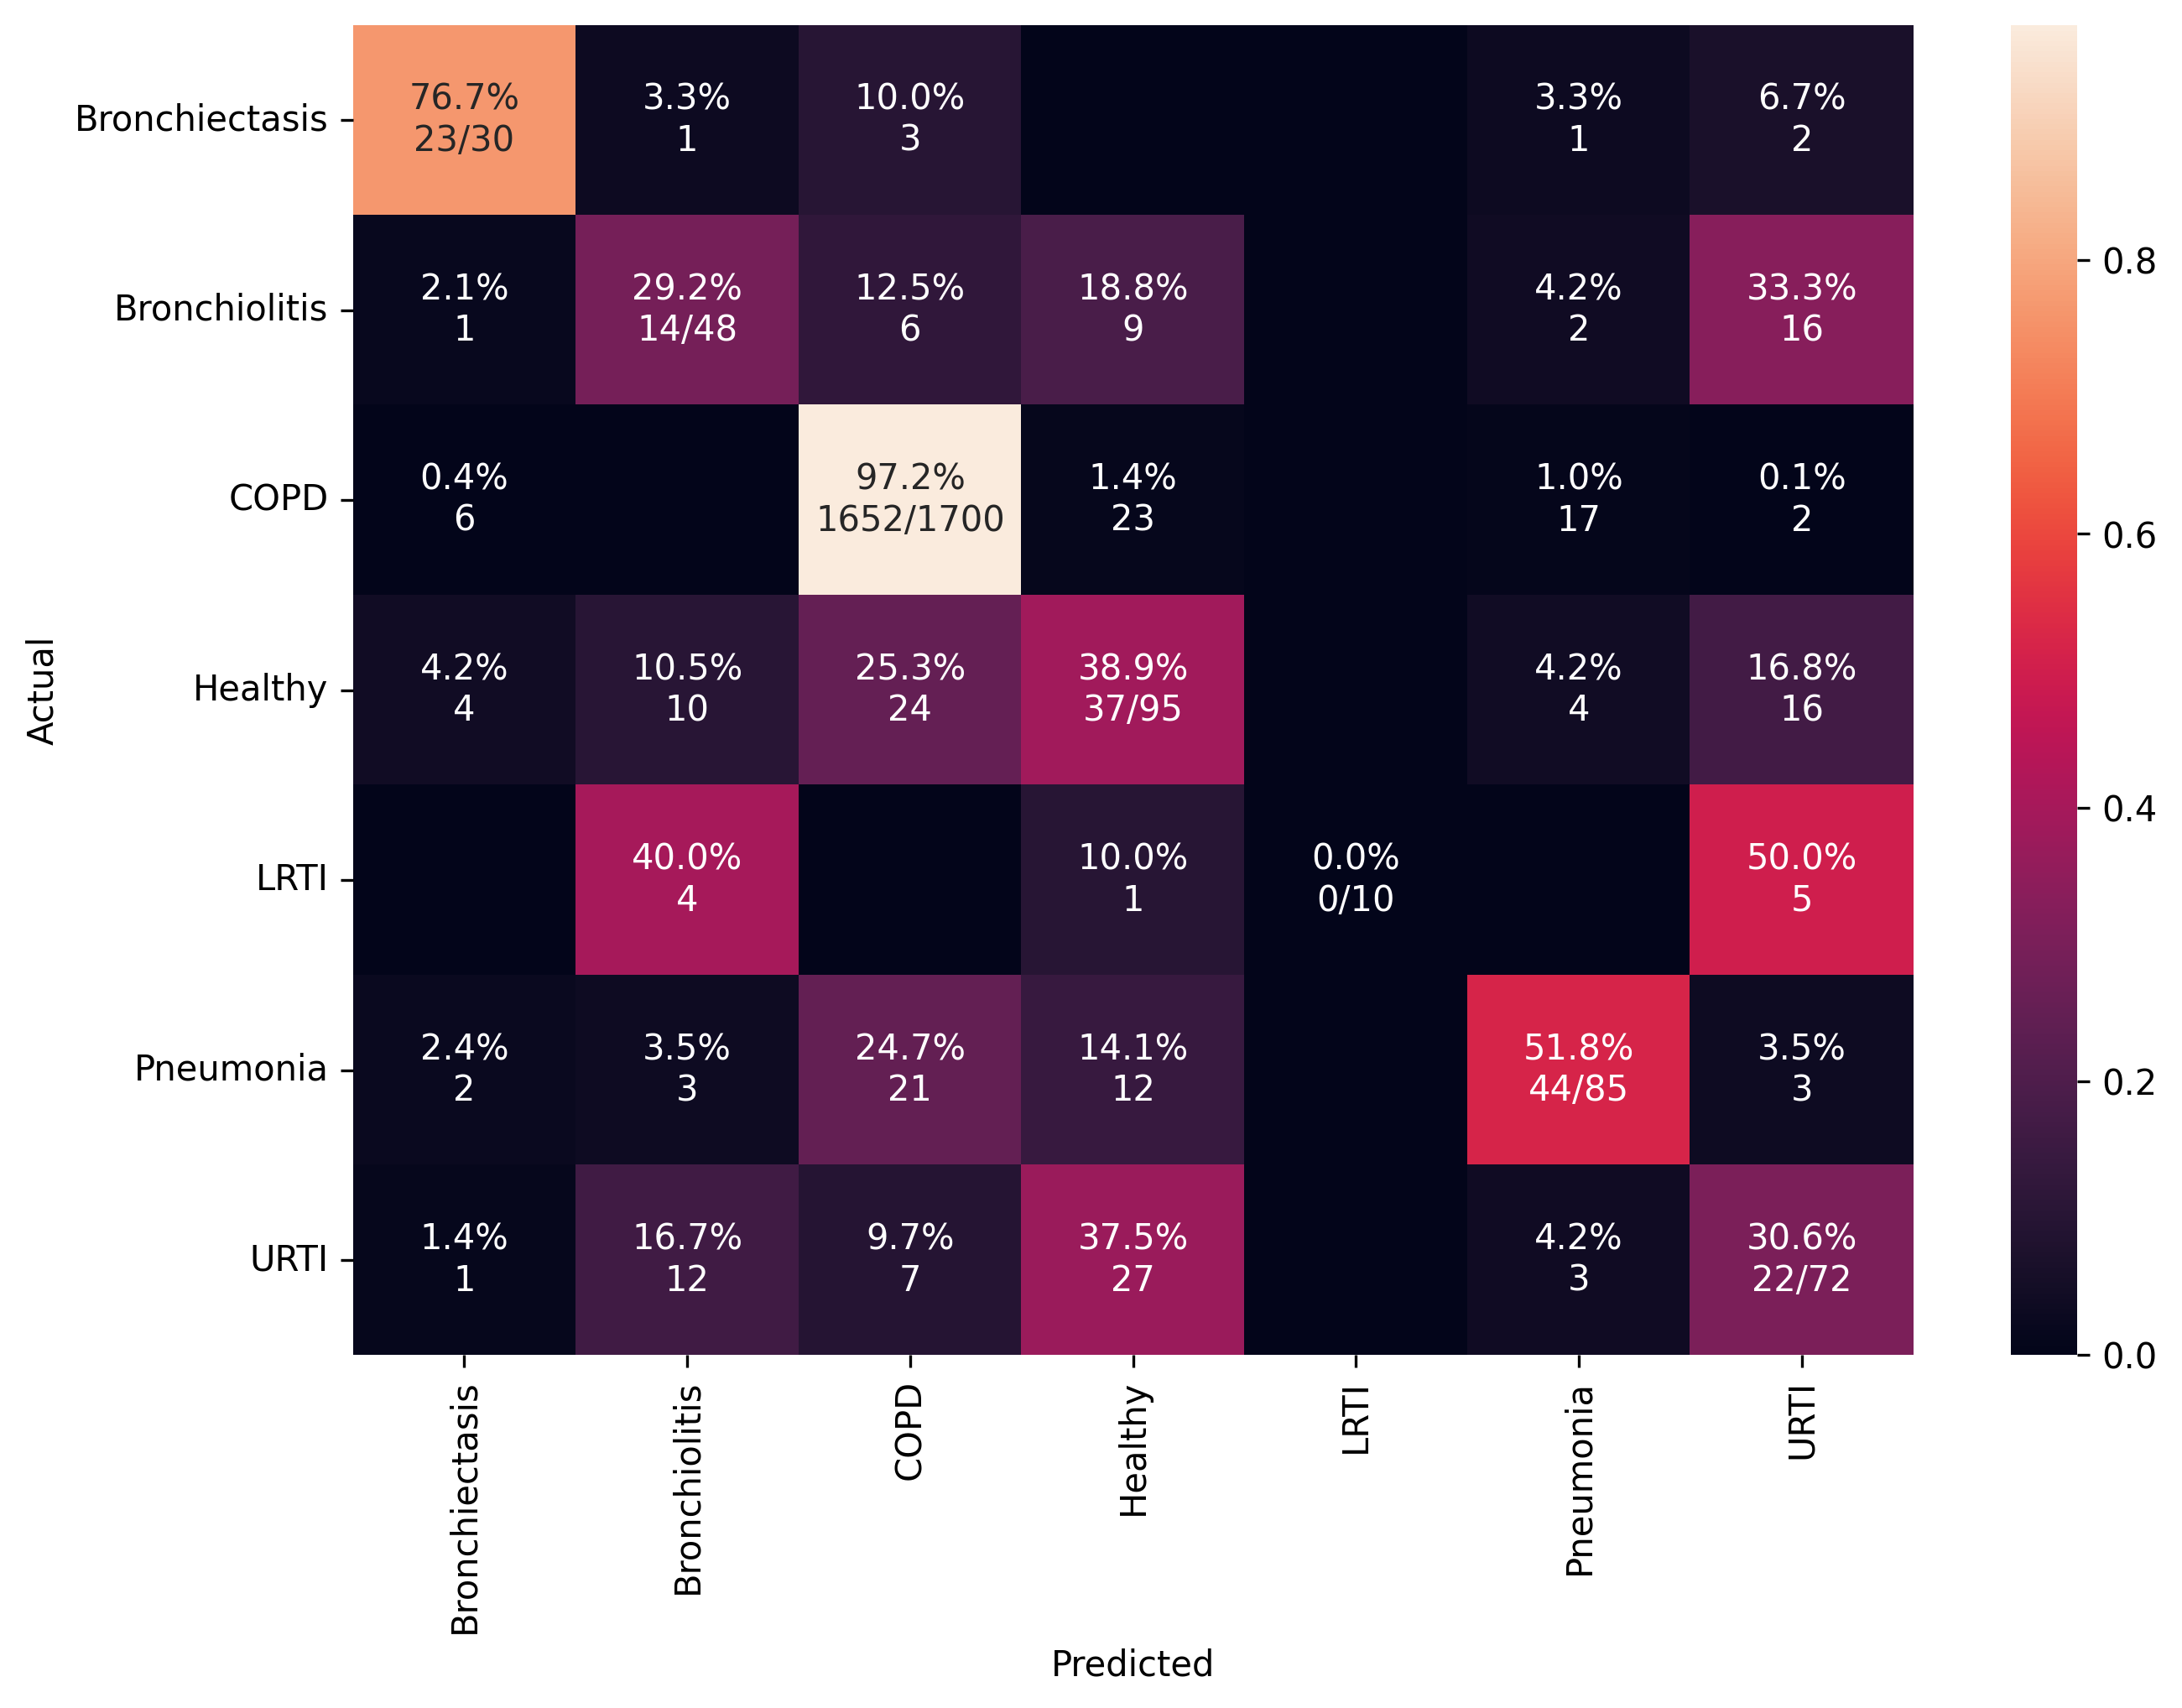

In [44]:
y_pred_class=m.predict(ann_model)
cm_df = m.confusion_matrix(y_pred_class)

In [45]:
cm_df.set_index(le.classes_)

TP  FP  FN    TN
Bronchiectasis    23  14   7  1996
Bronchiolitis     14  30  34  1962
COPD            1652  61  48   279
Healthy           37  72  58  1873
LRTI               0   0  10  2030
Pneumonia         44  27  41  1928
URTI              22  44  50  1924

In [48]:
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
ann_imbalance = pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
ann_imbalance.to_csv(f'{OUT_DIR}ann_imbalance-2.csv')




































# CNN MODEL

In [65]:
y_train_cnn = y_train
X_train_cnn = X_train 
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],
                                  X_train_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
#X_val_cnn = X_val
#X_val_cnn = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1],
                               #   X_val_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
X_test_cnn = X_test
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],
                                  X_test_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1

In [58]:
pd.Series(y_train_cnn).value_counts()

COPD              3965
Healthy            222
Pneumonia          199
URTI               168
Bronchiolitis      111
Bronchiectasis      71
LRTI                22
dtype: int64

In [66]:
m = Model2(X_train_cnn, y_train_encoded, None, None, X_test_cnn, y_test_encoded)

In [67]:
cnn_model = m.CNN()
m.compile_info(cnn_model)
m.summary_info(cnn_model)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 11, 257, 32)       320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 129, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 129, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 128, 32)        4128      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 64, 32)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 64, 32)         128       
_________________________________________________________________
flatten_6 (Flatten)          (None, 6144)             

In [68]:
history = m.fit_train(cnn_model,epochs=100, batch_size=256 )

Epoch 1/100
19/19 [==============================] - 1s 13ms/step - loss: 1.2557 - accuracy: 0.6412
Epoch 2/100
19/19 [==============================] - 0s 13ms/step - loss: 0.8924 - accuracy: 0.8174
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.7612 - accuracy: 0.8279
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.6769 - accuracy: 0.8321
Epoch 5/100
19/19 [==============================] - 0s 12ms/step - loss: 0.6118 - accuracy: 0.8325
Epoch 6/100
19/19 [==============================] - 0s 13ms/step - loss: 0.5635 - accuracy: 0.8335
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 0.5287 - accuracy: 0.8338
Epoch 8/100
19/19 [==============================] - 0s 13ms/step - loss: 0.5094 - accuracy: 0.8333
Epoch 9/100
19/19 [==============================] - 0s 13ms/step - loss: 0.4869 - accuracy: 0.8335
Epoch 10/100
19/19 [==============================] - 0s 13ms/step - loss: 0.4770 - accuracy: 0.8333

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00        30
 Bronchiolitis       0.00      0.00      0.00        48
          COPD       0.96      0.99      0.98      1700
       Healthy       0.60      0.54      0.57        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.77      0.52      0.62        85
          URTI       0.37      0.74      0.49        72

      accuracy                           0.90      2040
     macro avg       0.39      0.40      0.38      2040
  weighted avg       0.88      0.90      0.89      2040



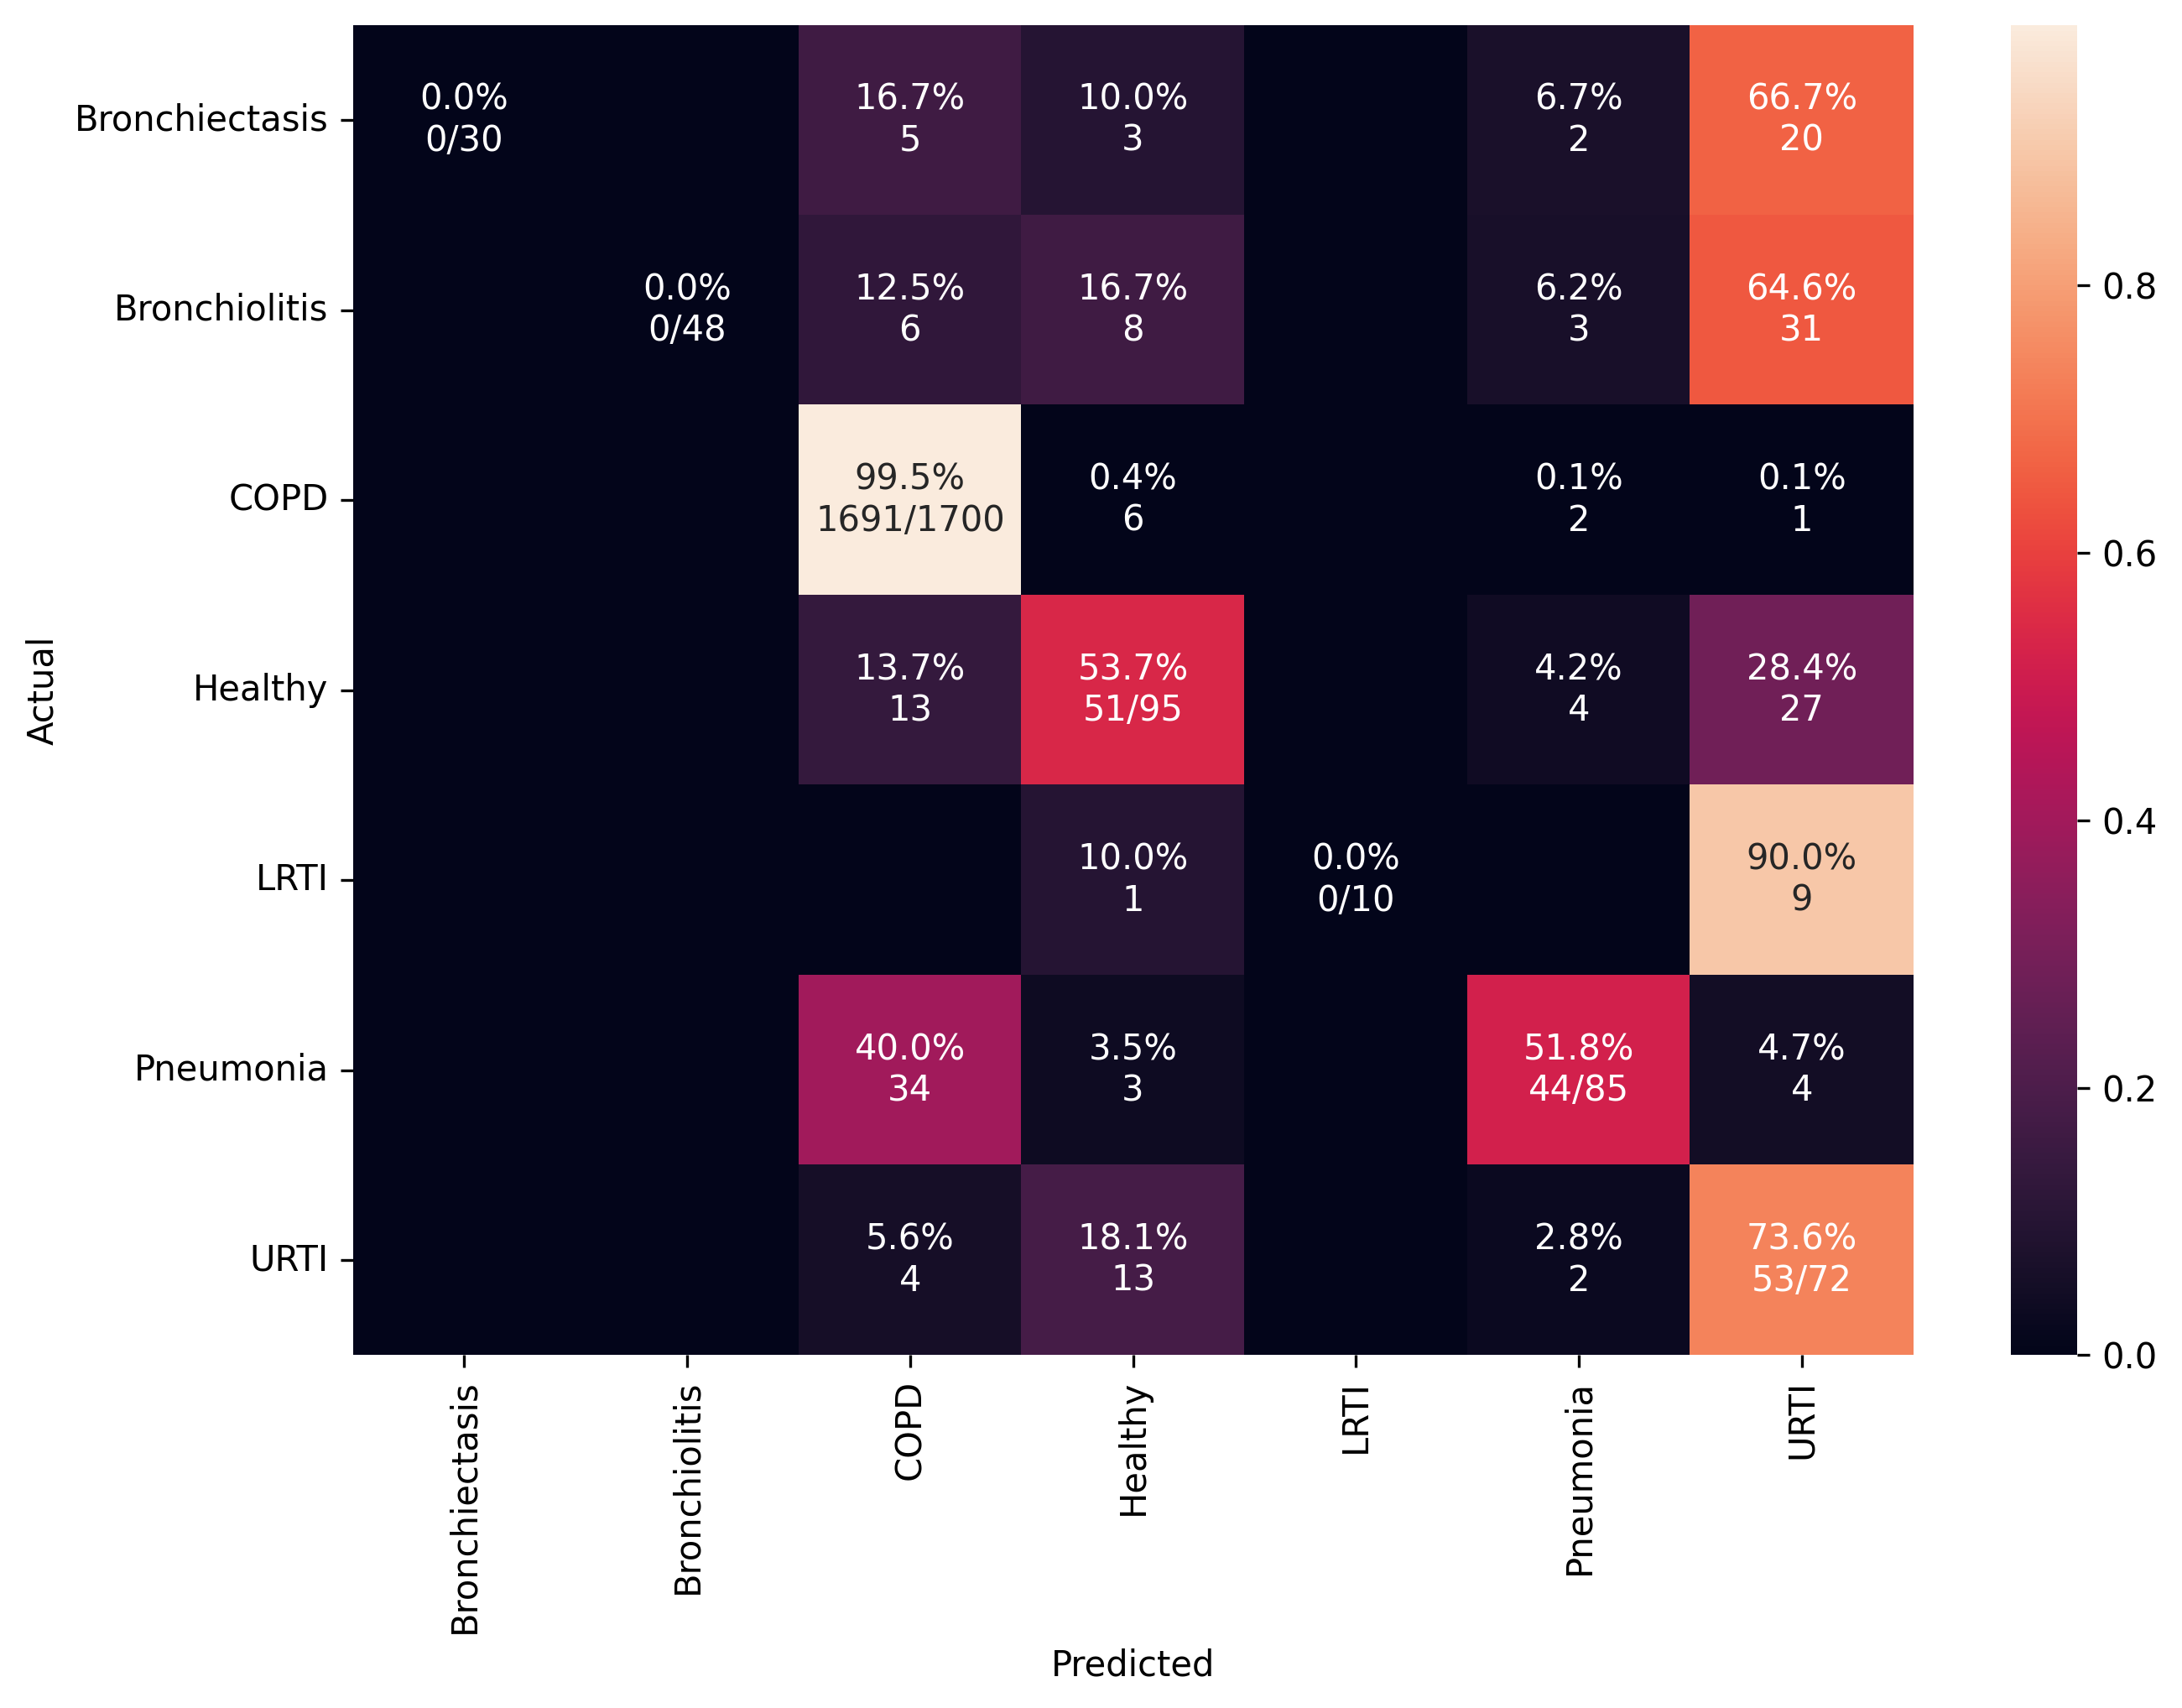

In [69]:
y_pred=m.predict(cnn_model)
cm_df = m.confusion_matrix(y_pred)

In [71]:
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1).to_csv('cnn.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
final.to_csv('ans.csv')

# RNN - LSTM

In [72]:
X_train_rnn = X_train_ann

In [84]:
m = Model2(X_train_rnn, y_train_encoded, None, None, X_test, y_test_encoded)
rnn = m.RNN_LSTM()

In [85]:
m.compile_info(rnn)
m.summary_info(rnn)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 13, 64)            82944     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)              

In [86]:
history=m.fit_train(rnn, epochs=100, batch_size=256)

Epoch 1/100
19/19 [==============================] - 4s 9ms/step - loss: 1.7408 - accuracy: 0.6225
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 1.1381 - accuracy: 0.8327
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.7611 - accuracy: 0.8333
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.7319 - accuracy: 0.8333
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.7024 - accuracy: 0.8333
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 0.6953 - accuracy: 0.8333
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6802 - accuracy: 0.8333
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 0.6759 - accuracy: 0.8333
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6570 - accuracy: 0.8333
Epoch 10/100
19/19 [==============================] - 0s 8ms/step - loss: 0.6445 - accuracy: 0.8333
Epoch 11/

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.24      0.17      0.20        30
 Bronchiolitis       0.23      0.27      0.25        48
          COPD       0.92      0.93      0.92      1700
       Healthy       0.28      0.24      0.26        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.38      0.36      0.37        85
          URTI       0.25      0.29      0.27        72

      accuracy                           0.82      2040
     macro avg       0.33      0.32      0.32      2040
  weighted avg       0.81      0.82      0.81      2040



TP   FP   FN    TN
0     5   16   25  1994
1    13   43   35  1949
2  1576  139  124   201
3    23   60   72  1885
4     0    0   10  2030
5    31   51   54  1904
6    21   62   51  1906

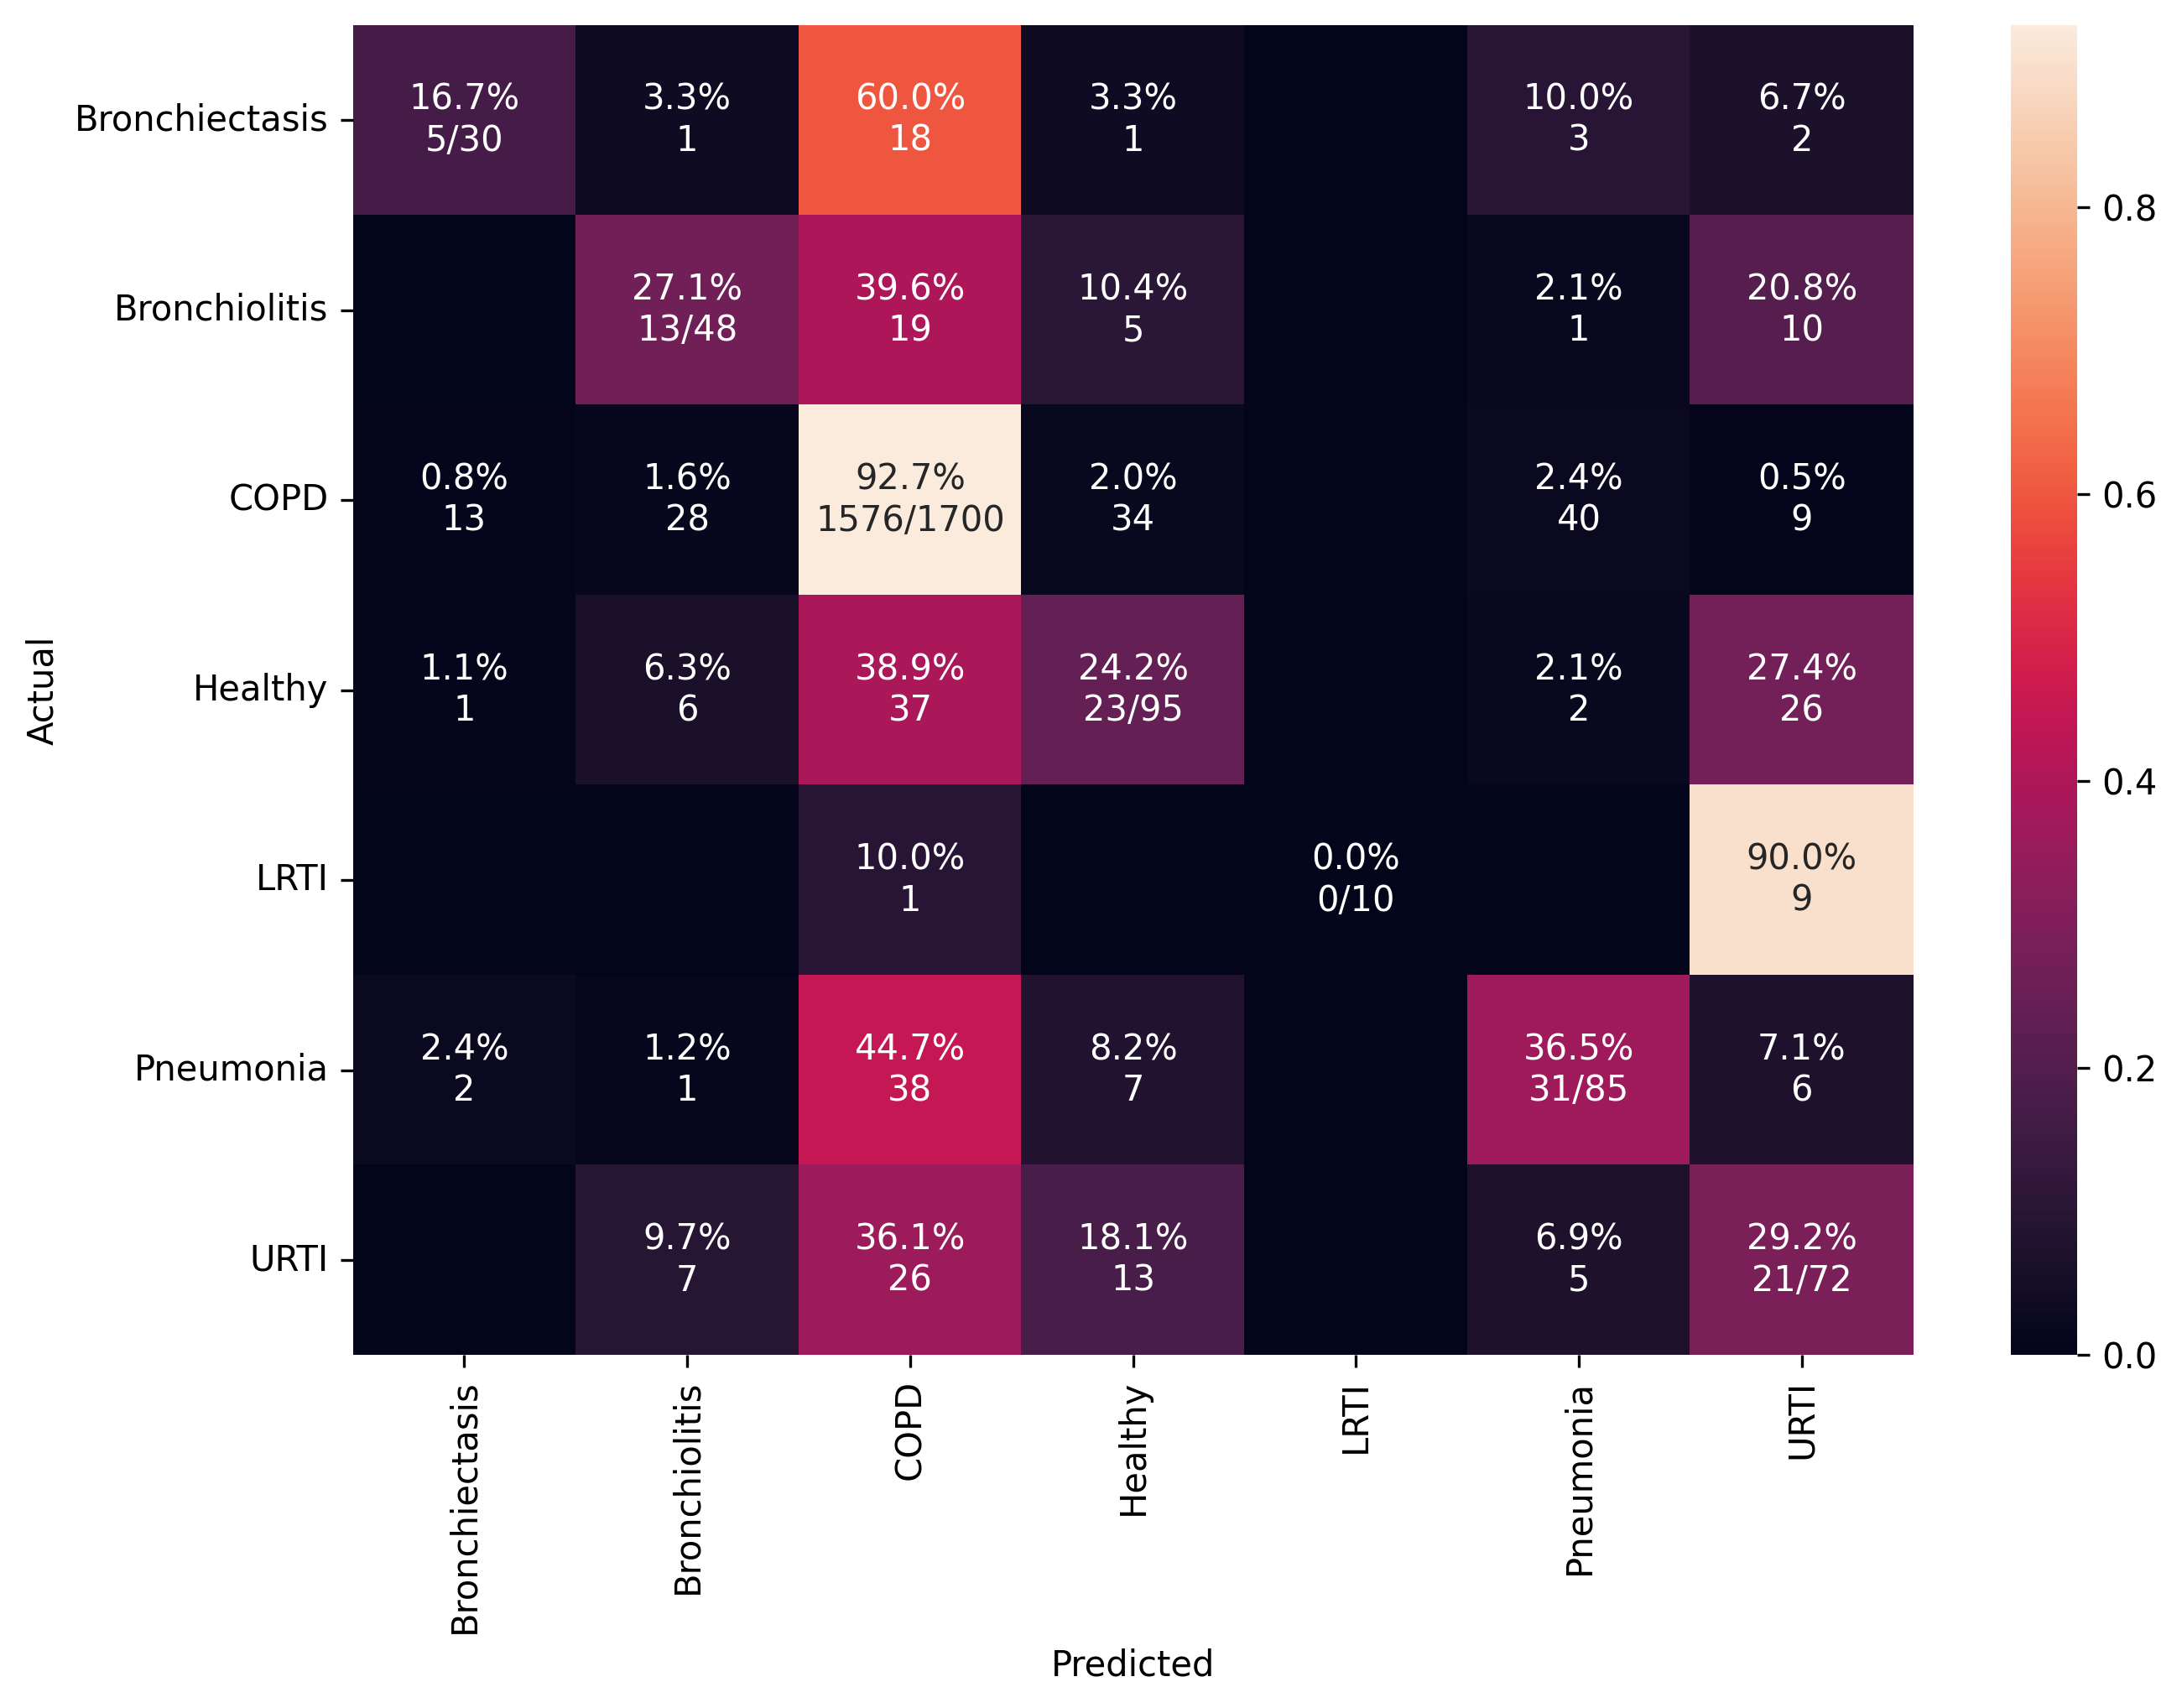

In [87]:
y_pred = m.predict(rnn)
m.confusion_matrix(y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.24      0.17      0.20        30
 Bronchiolitis       0.23      0.27      0.25        48
          COPD       0.92      0.93      0.92      1700
       Healthy       0.28      0.24      0.26        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.38      0.36      0.37        85
          URTI       0.25      0.29      0.27        72

      accuracy                           0.82      2040
     macro avg       0.33      0.32      0.32      2040
  weighted avg       0.81      0.82      0.81      2040



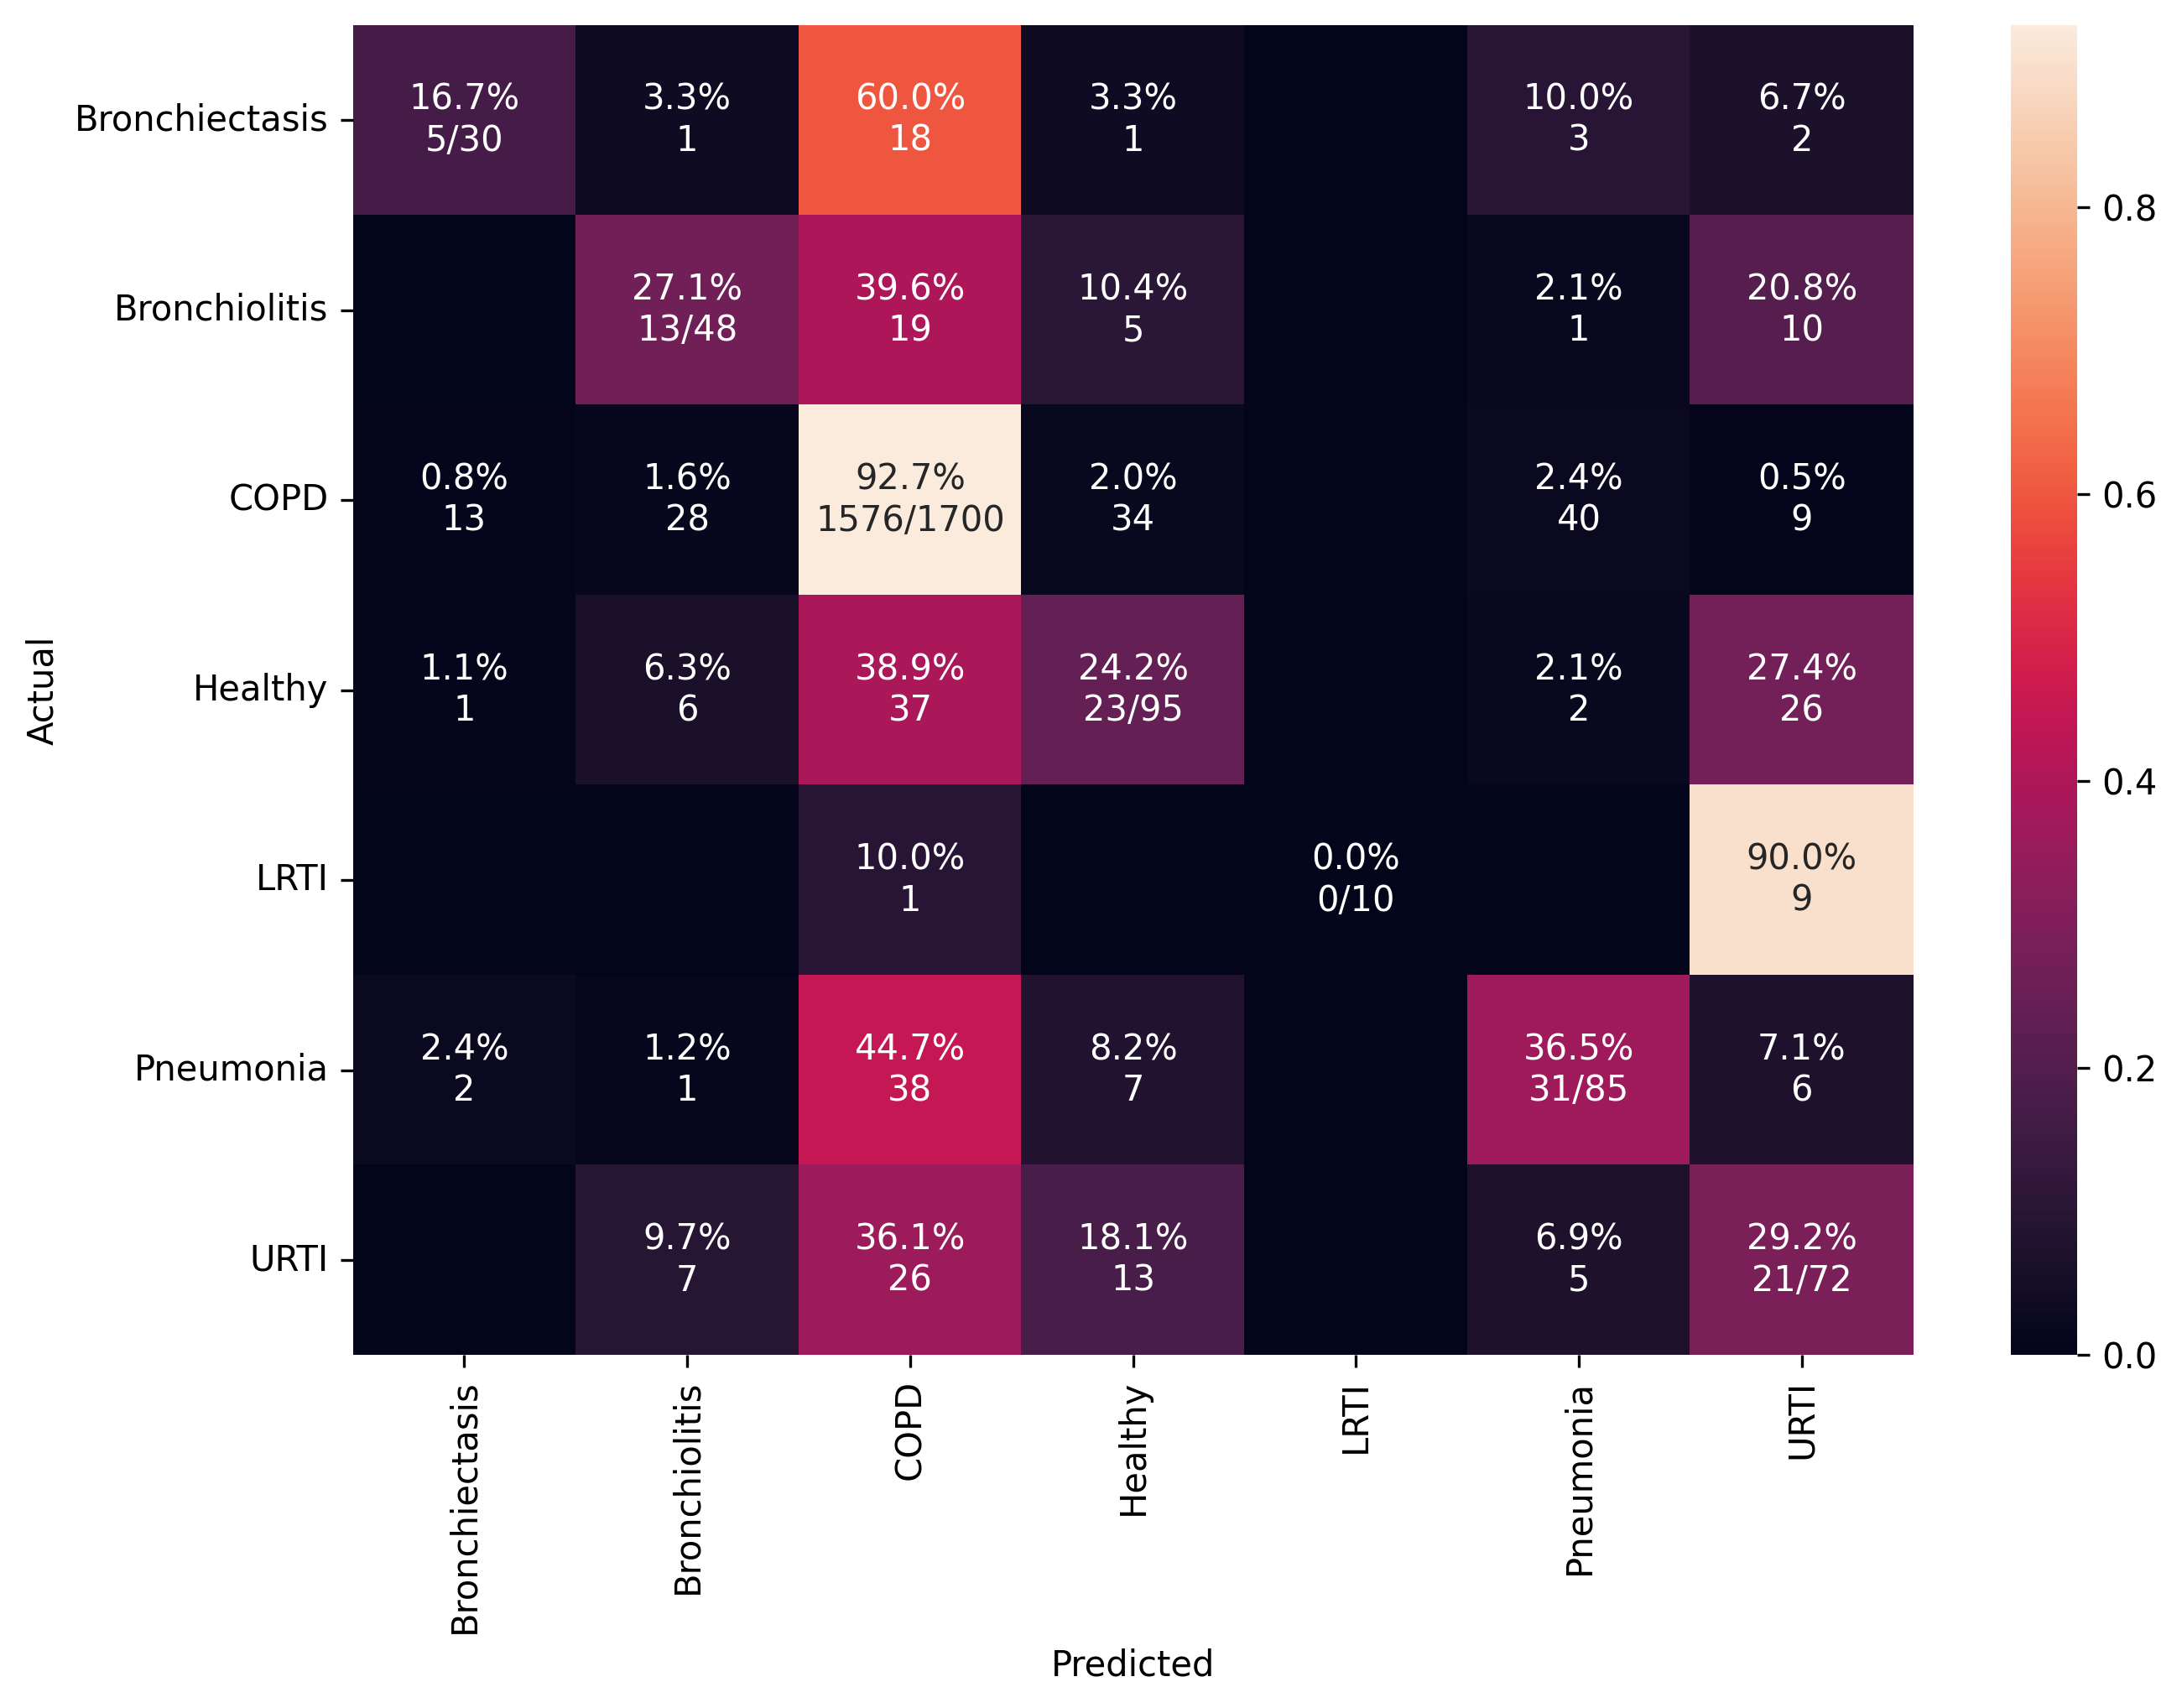

In [88]:
y_pred_class=m.predict(rnn)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1).to_csv('lstm.csv')

# RESNET - 50

In [89]:
X_train_cnn.shape

(4758, 13, 259, 1)

In [90]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
res_model = tf.keras.applications.ResNet50(include_top=False, weights=None,
                                       input_tensor=input_t)
to_res = (13, 259)

In [91]:
m = Model2(X_train_cnn, y_train_cnn, None, None, X_test_cnn, y_test)
res = m.RESNET_50(to_res)
#plot_model(res, to_file='ann.png', show_shapes=True)

In [92]:
m = Model2(X_train_cnn, y_train_encoded, None, None, X_test_cnn, y_test_encoded)
res = m.RESNET_50(to_res)
m.compile_info(res)
history=m.fit_train(res, epochs=100, batch_size=256)
m.summary_info(res)

Epoch 1/100
19/19 [==============================] - 16s 261ms/step - loss: 2.4645 - accuracy: 0.1780
Epoch 2/100
19/19 [==============================] - 4s 193ms/step - loss: 2.1702 - accuracy: 0.3108
Epoch 3/100
19/19 [==============================] - 4s 193ms/step - loss: 1.9586 - accuracy: 0.4666
Epoch 4/100
19/19 [==============================] - 4s 193ms/step - loss: 1.7993 - accuracy: 0.6135
Epoch 5/100
19/19 [==============================] - 4s 193ms/step - loss: 1.5355 - accuracy: 0.6847
Epoch 6/100
19/19 [==============================] - 4s 193ms/step - loss: 1.3197 - accuracy: 0.7385
Epoch 7/100
19/19 [==============================] - 4s 193ms/step - loss: 1.0634 - accuracy: 0.7881
Epoch 8/100
19/19 [==============================] - 4s 193ms/step - loss: 0.8755 - accuracy: 0.8140
Epoch 9/100
19/19 [==============================] - 4s 192ms/step - loss: 0.6952 - accuracy: 0.8388
Epoch 10/100
19/19 [==============================] - 4s 192ms/step - loss: 0.6213 - accur

                precision    recall  f1-score   support

Bronchiectasis       1.00      0.57      0.72        30
 Bronchiolitis       0.66      0.56      0.61        48
          COPD       0.98      0.97      0.98      1700
       Healthy       0.39      0.85      0.53        95
          LRTI       0.43      0.30      0.35        10
     Pneumonia       0.87      0.55      0.68        85
          URTI       0.75      0.21      0.33        72

      accuracy                           0.91      2040
     macro avg       0.73      0.57      0.60      2040
  weighted avg       0.93      0.91      0.91      2040



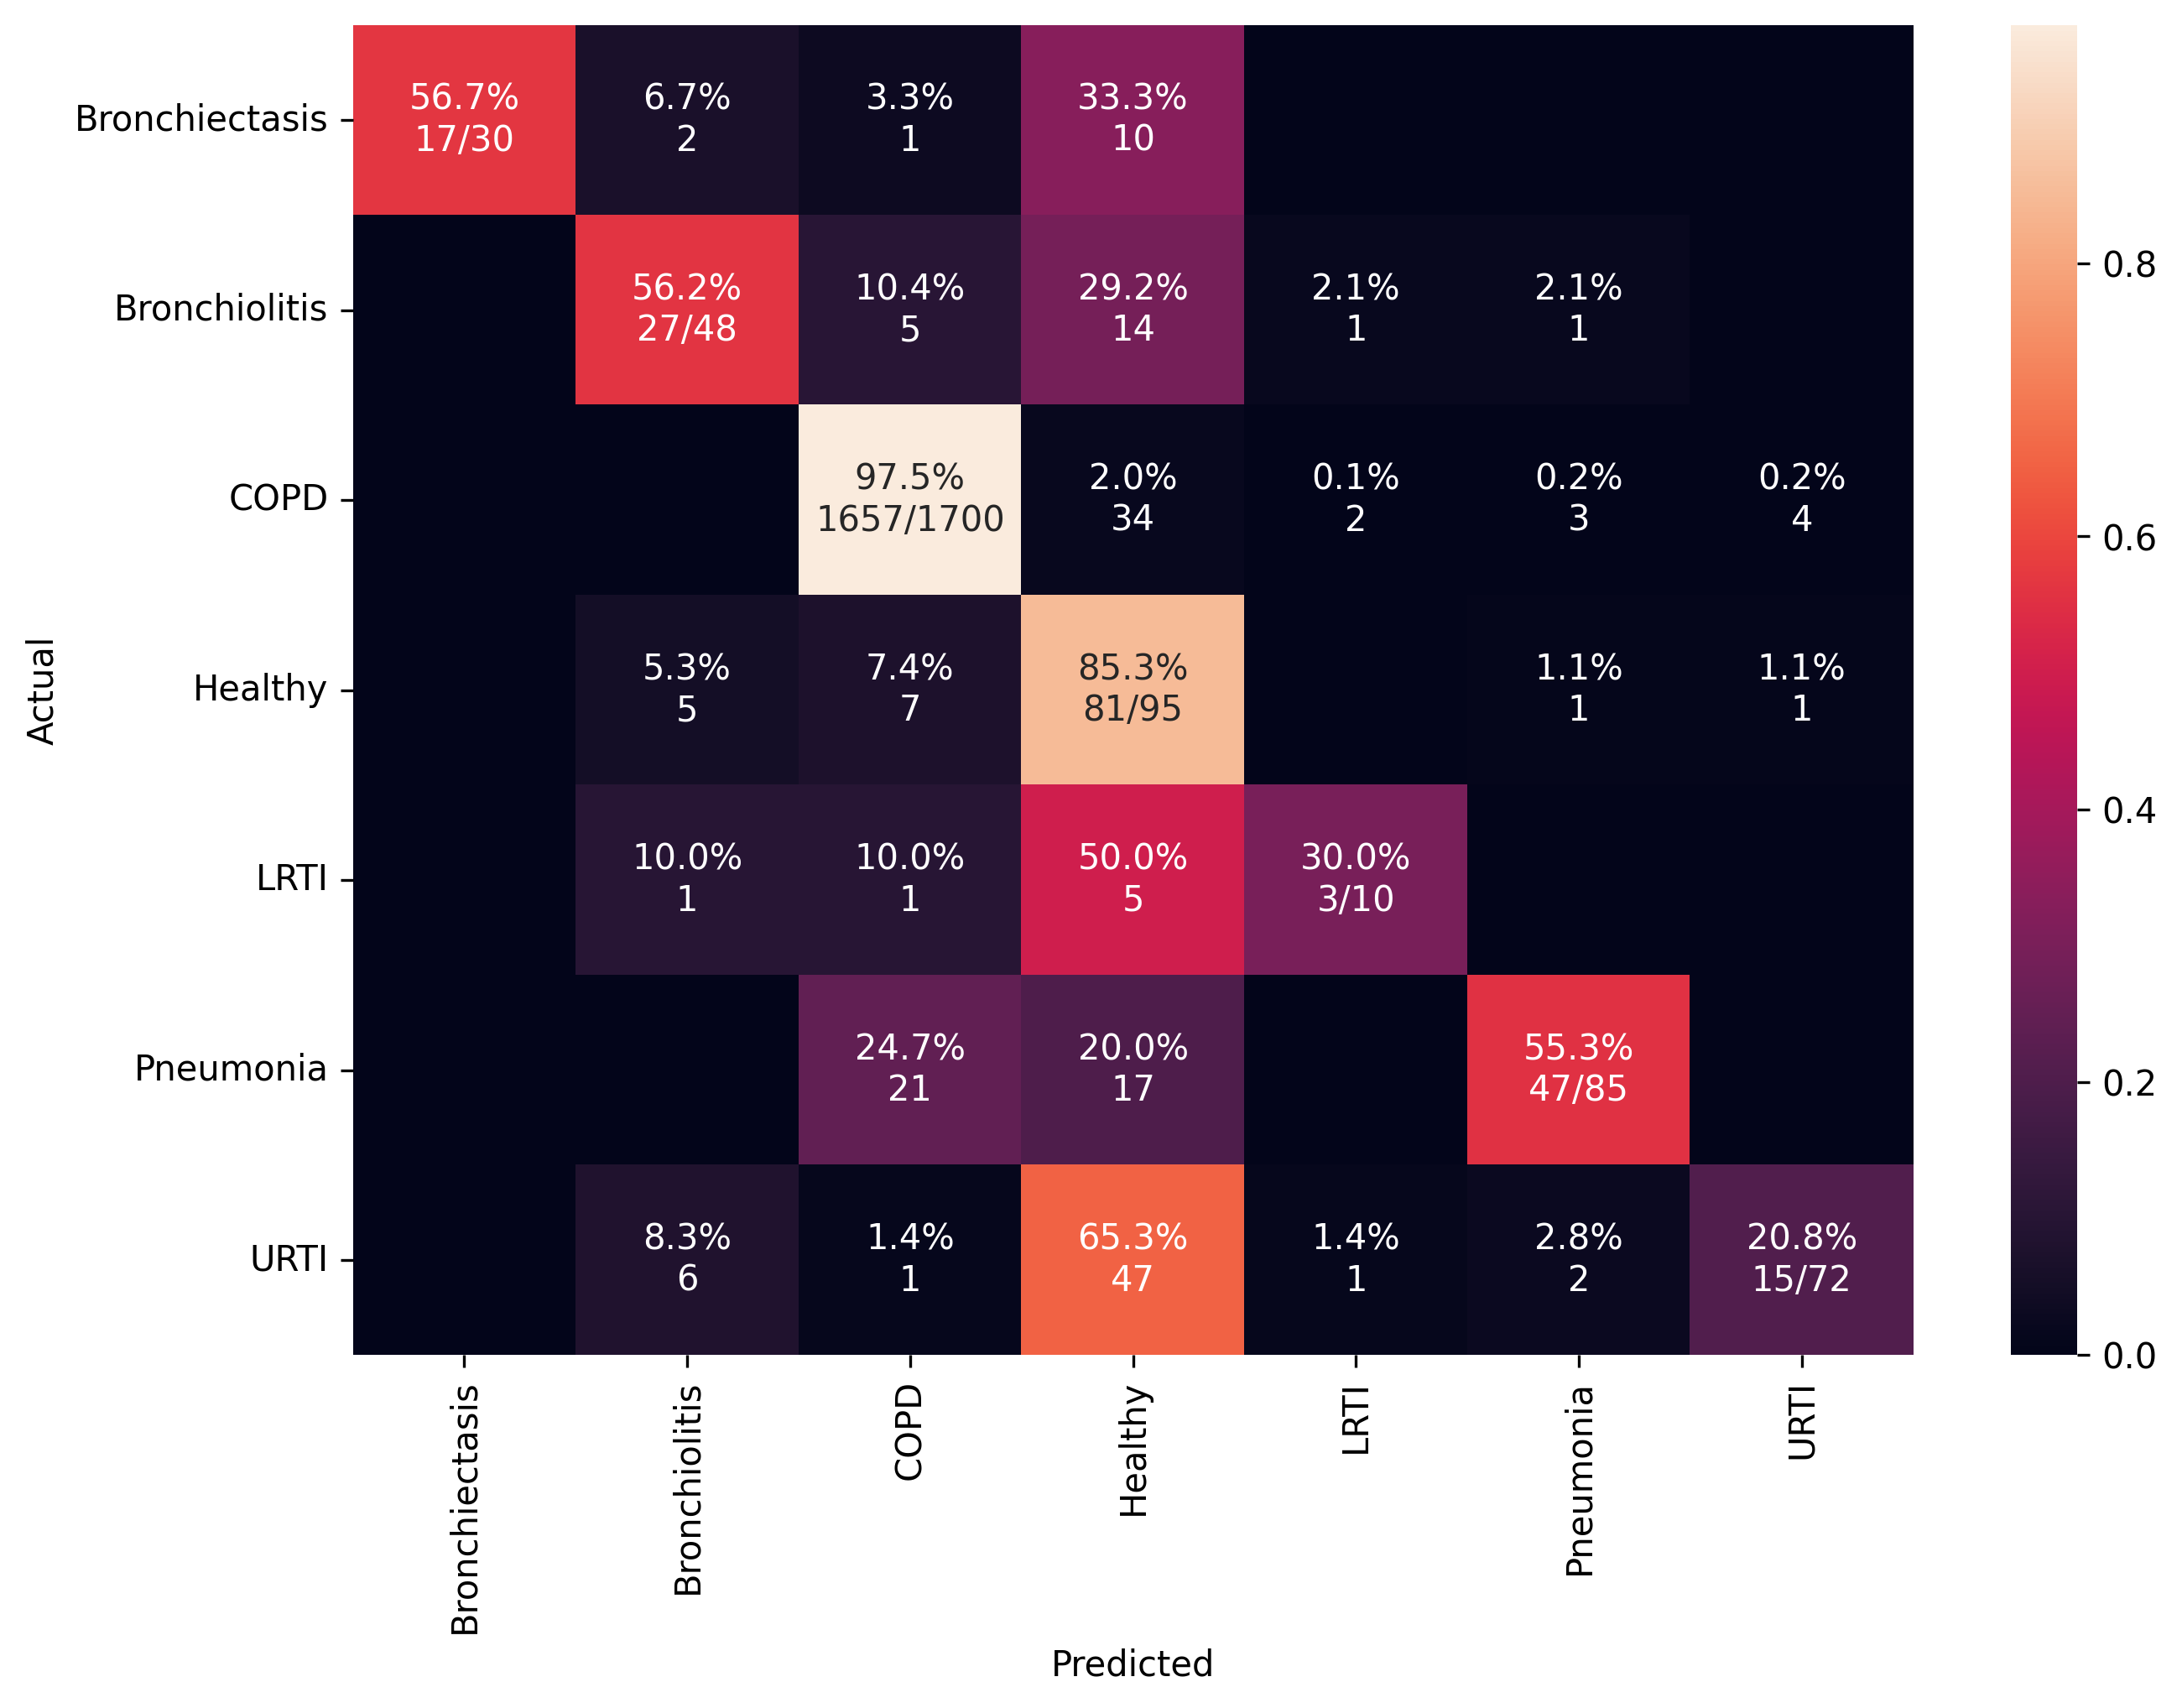

In [93]:
y_pred_class=m.predict(res)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}resnet50-imbalance(1).csv')

In [94]:
m = Model2(X_train_cnn, y_train_encoded, None, None, X_test_cnn, y_test_encoded)
res = m.RESNET_50(to_res)
m.compile_info(res)
history=m.fit_train(res, epochs=100, batch_size=256)
m.summary_info(res)

Epoch 1/100
19/19 [==============================] - 12s 192ms/step - loss: 2.1317 - accuracy: 0.2972
Epoch 2/100
19/19 [==============================] - 4s 191ms/step - loss: 1.3023 - accuracy: 0.6454
Epoch 3/100
19/19 [==============================] - 4s 191ms/step - loss: 0.7366 - accuracy: 0.8310
Epoch 4/100
19/19 [==============================] - 4s 192ms/step - loss: 0.5308 - accuracy: 0.8768
Epoch 5/100
19/19 [==============================] - 4s 192ms/step - loss: 0.4280 - accuracy: 0.9016
Epoch 6/100
19/19 [==============================] - 4s 192ms/step - loss: 0.3031 - accuracy: 0.9239
Epoch 7/100
19/19 [==============================] - 4s 192ms/step - loss: 0.2773 - accuracy: 0.9300
Epoch 8/100
19/19 [==============================] - 4s 191ms/step - loss: 0.2108 - accuracy: 0.9508
Epoch 9/100
19/19 [==============================] - 4s 191ms/step - loss: 0.2019 - accuracy: 0.9548
Epoch 10/100
19/19 [==============================] - 4s 192ms/step - loss: 0.2559 - accur

                precision    recall  f1-score   support

Bronchiectasis       0.89      0.80      0.84        30
 Bronchiolitis       0.63      0.77      0.69        48
          COPD       0.96      0.99      0.98      1700
       Healthy       0.58      0.68      0.63        95
          LRTI       1.00      0.40      0.57        10
     Pneumonia       0.93      0.60      0.73        85
          URTI       0.81      0.36      0.50        72

      accuracy                           0.93      2040
     macro avg       0.83      0.66      0.71      2040
  weighted avg       0.93      0.93      0.92      2040



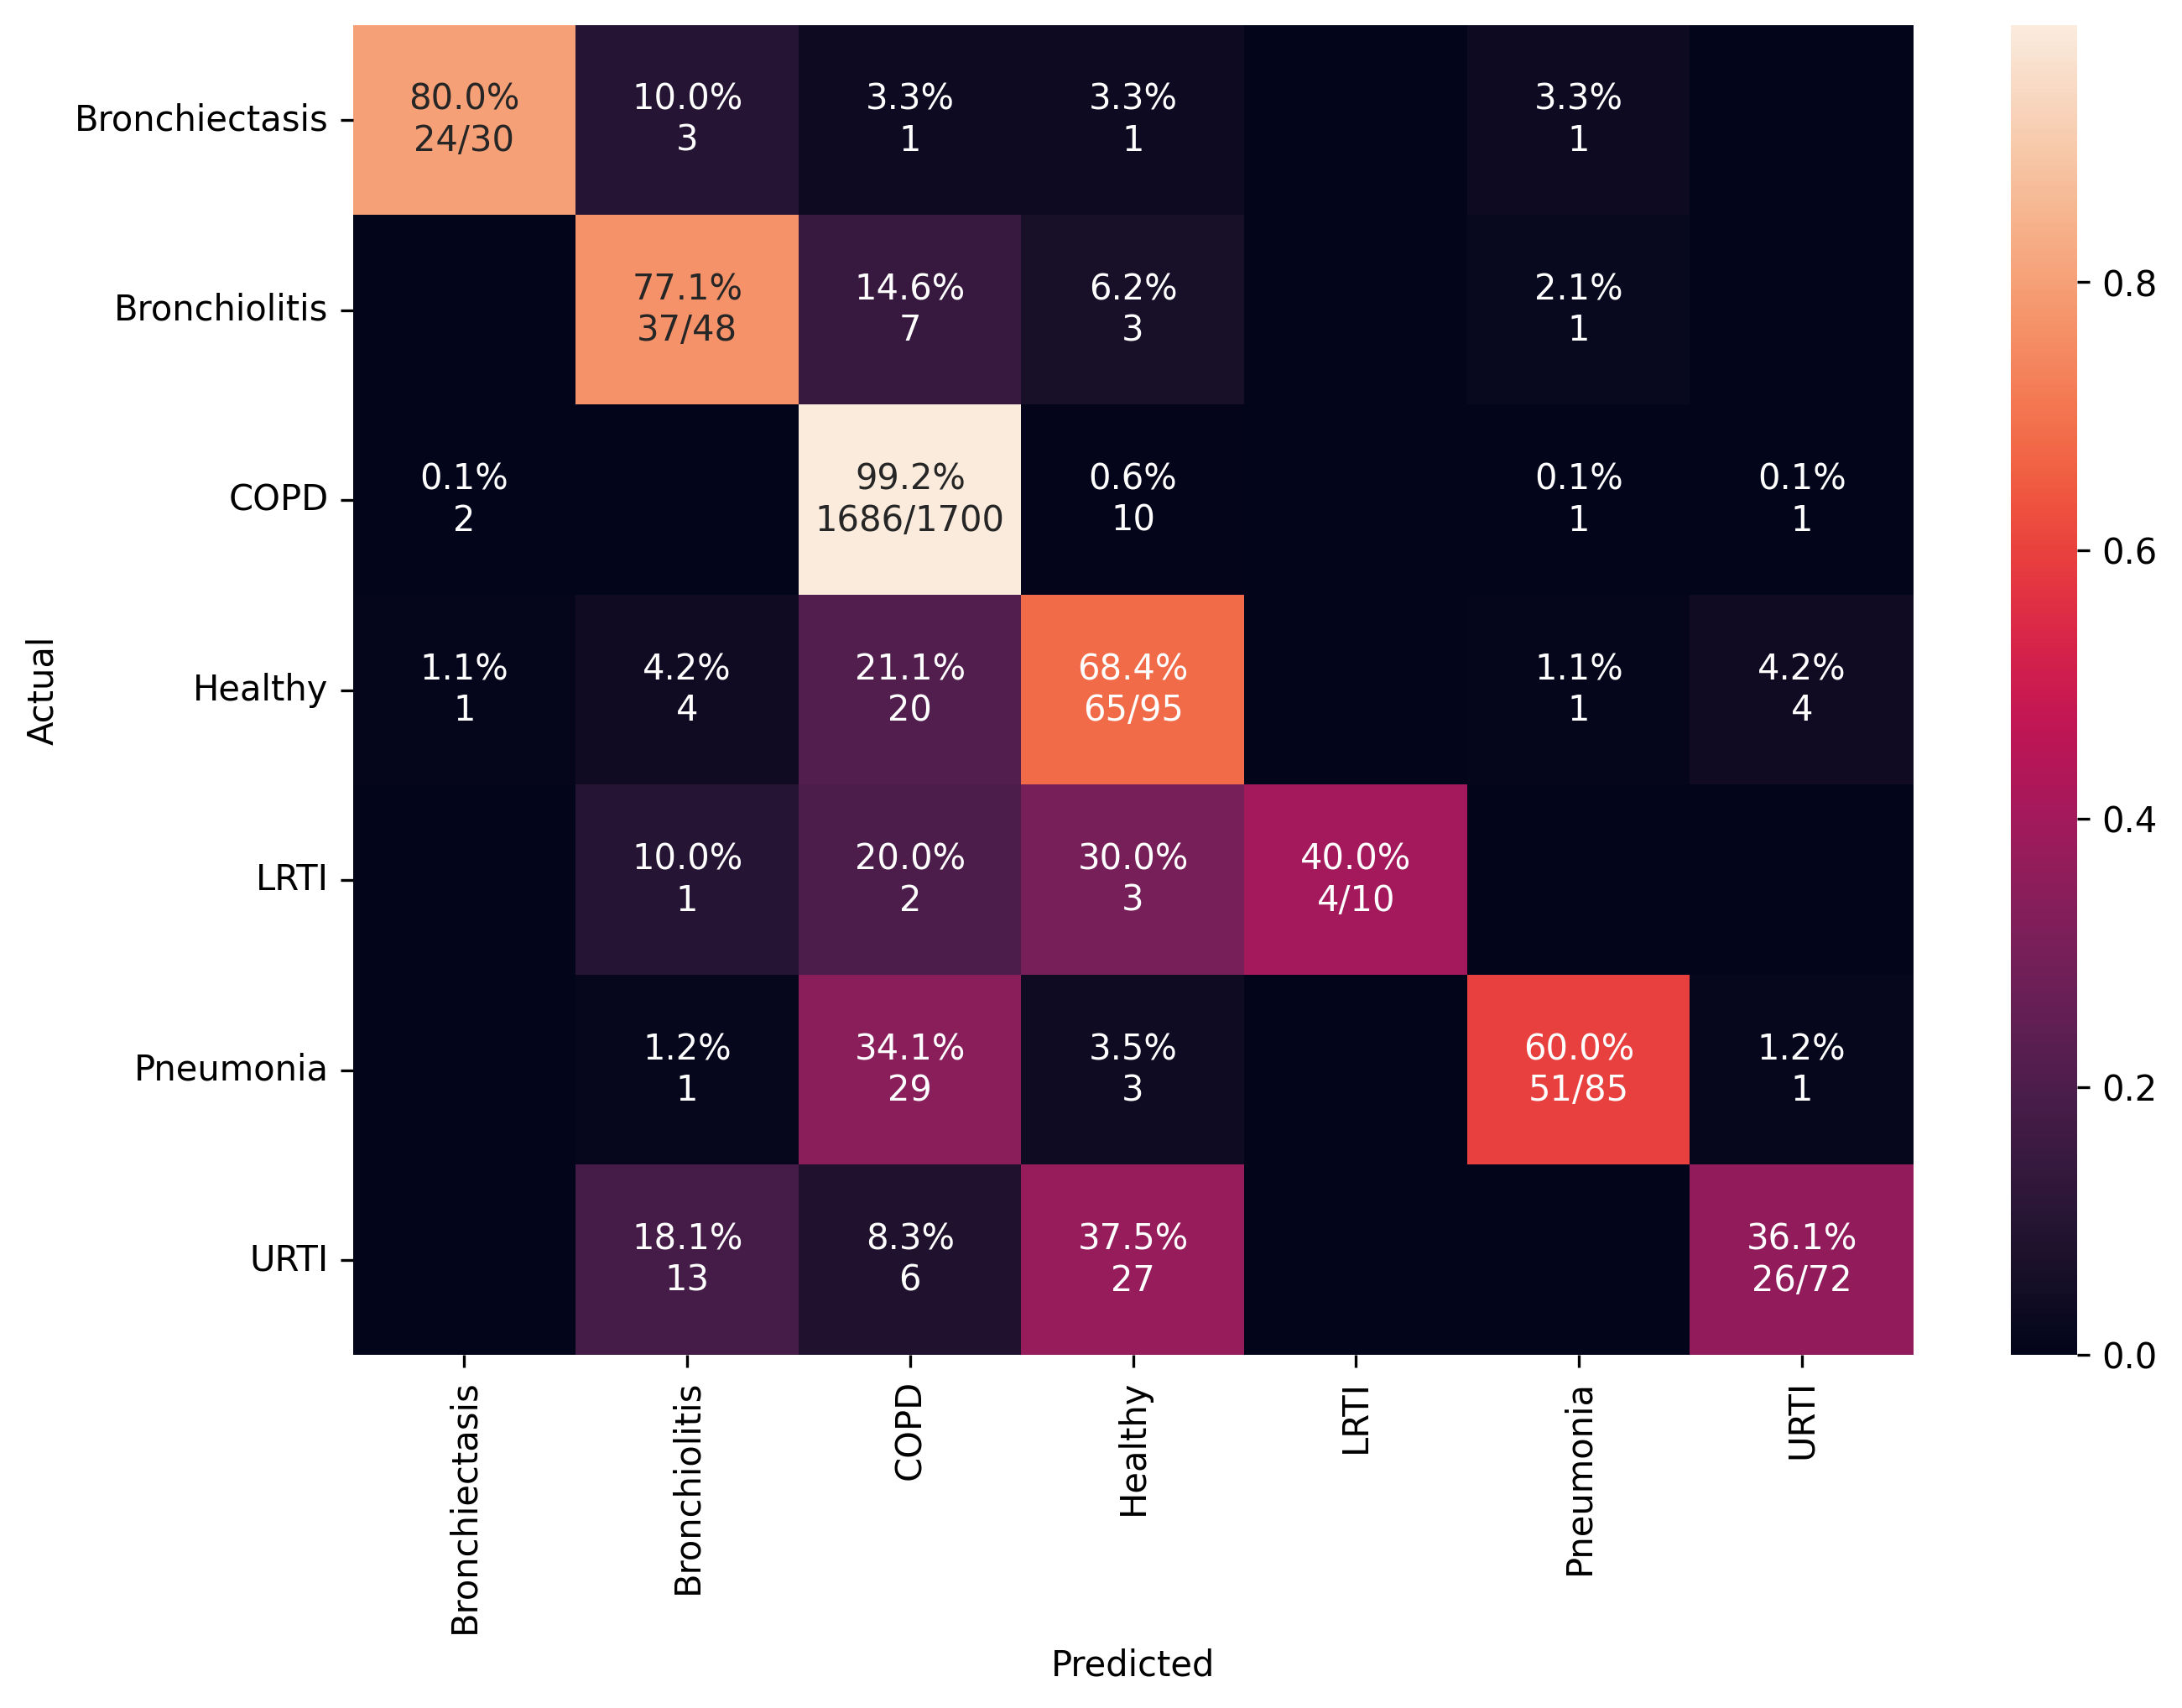

In [95]:
y_pred_class=m.predict(res)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}resnet50-imbalance(2).csv')

In [96]:
m = Model2(X_train_cnn, y_train_encoded, None, None, X_test_cnn, y_test_encoded)
res = m.RESNET_50(to_res)
m.compile_info(res)
history=m.fit_train(res, epochs=100, batch_size=256)
m.summary_info(res)

Epoch 1/100
19/19 [==============================] - 12s 191ms/step - loss: 1.7811 - accuracy: 0.4626
Epoch 2/100
19/19 [==============================] - 4s 191ms/step - loss: 0.7045 - accuracy: 0.8569
Epoch 3/100
19/19 [==============================] - 4s 192ms/step - loss: 0.2744 - accuracy: 0.9569
Epoch 4/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1549 - accuracy: 0.9777
Epoch 5/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1119 - accuracy: 0.9821
Epoch 6/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0718 - accuracy: 0.9895
Epoch 7/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0652 - accuracy: 0.9897
Epoch 8/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0587 - accuracy: 0.9916
Epoch 9/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0546 - accuracy: 0.9899
Epoch 10/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0633 - accur

                precision    recall  f1-score   support

Bronchiectasis       0.77      0.77      0.77        30
 Bronchiolitis       0.36      0.94      0.52        48
          COPD       0.97      0.98      0.98      1700
       Healthy       0.75      0.48      0.59        95
          LRTI       0.67      0.40      0.50        10
     Pneumonia       0.73      0.61      0.67        85
          URTI       0.57      0.29      0.39        72

      accuracy                           0.91      2040
     macro avg       0.69      0.64      0.63      2040
  weighted avg       0.92      0.91      0.91      2040



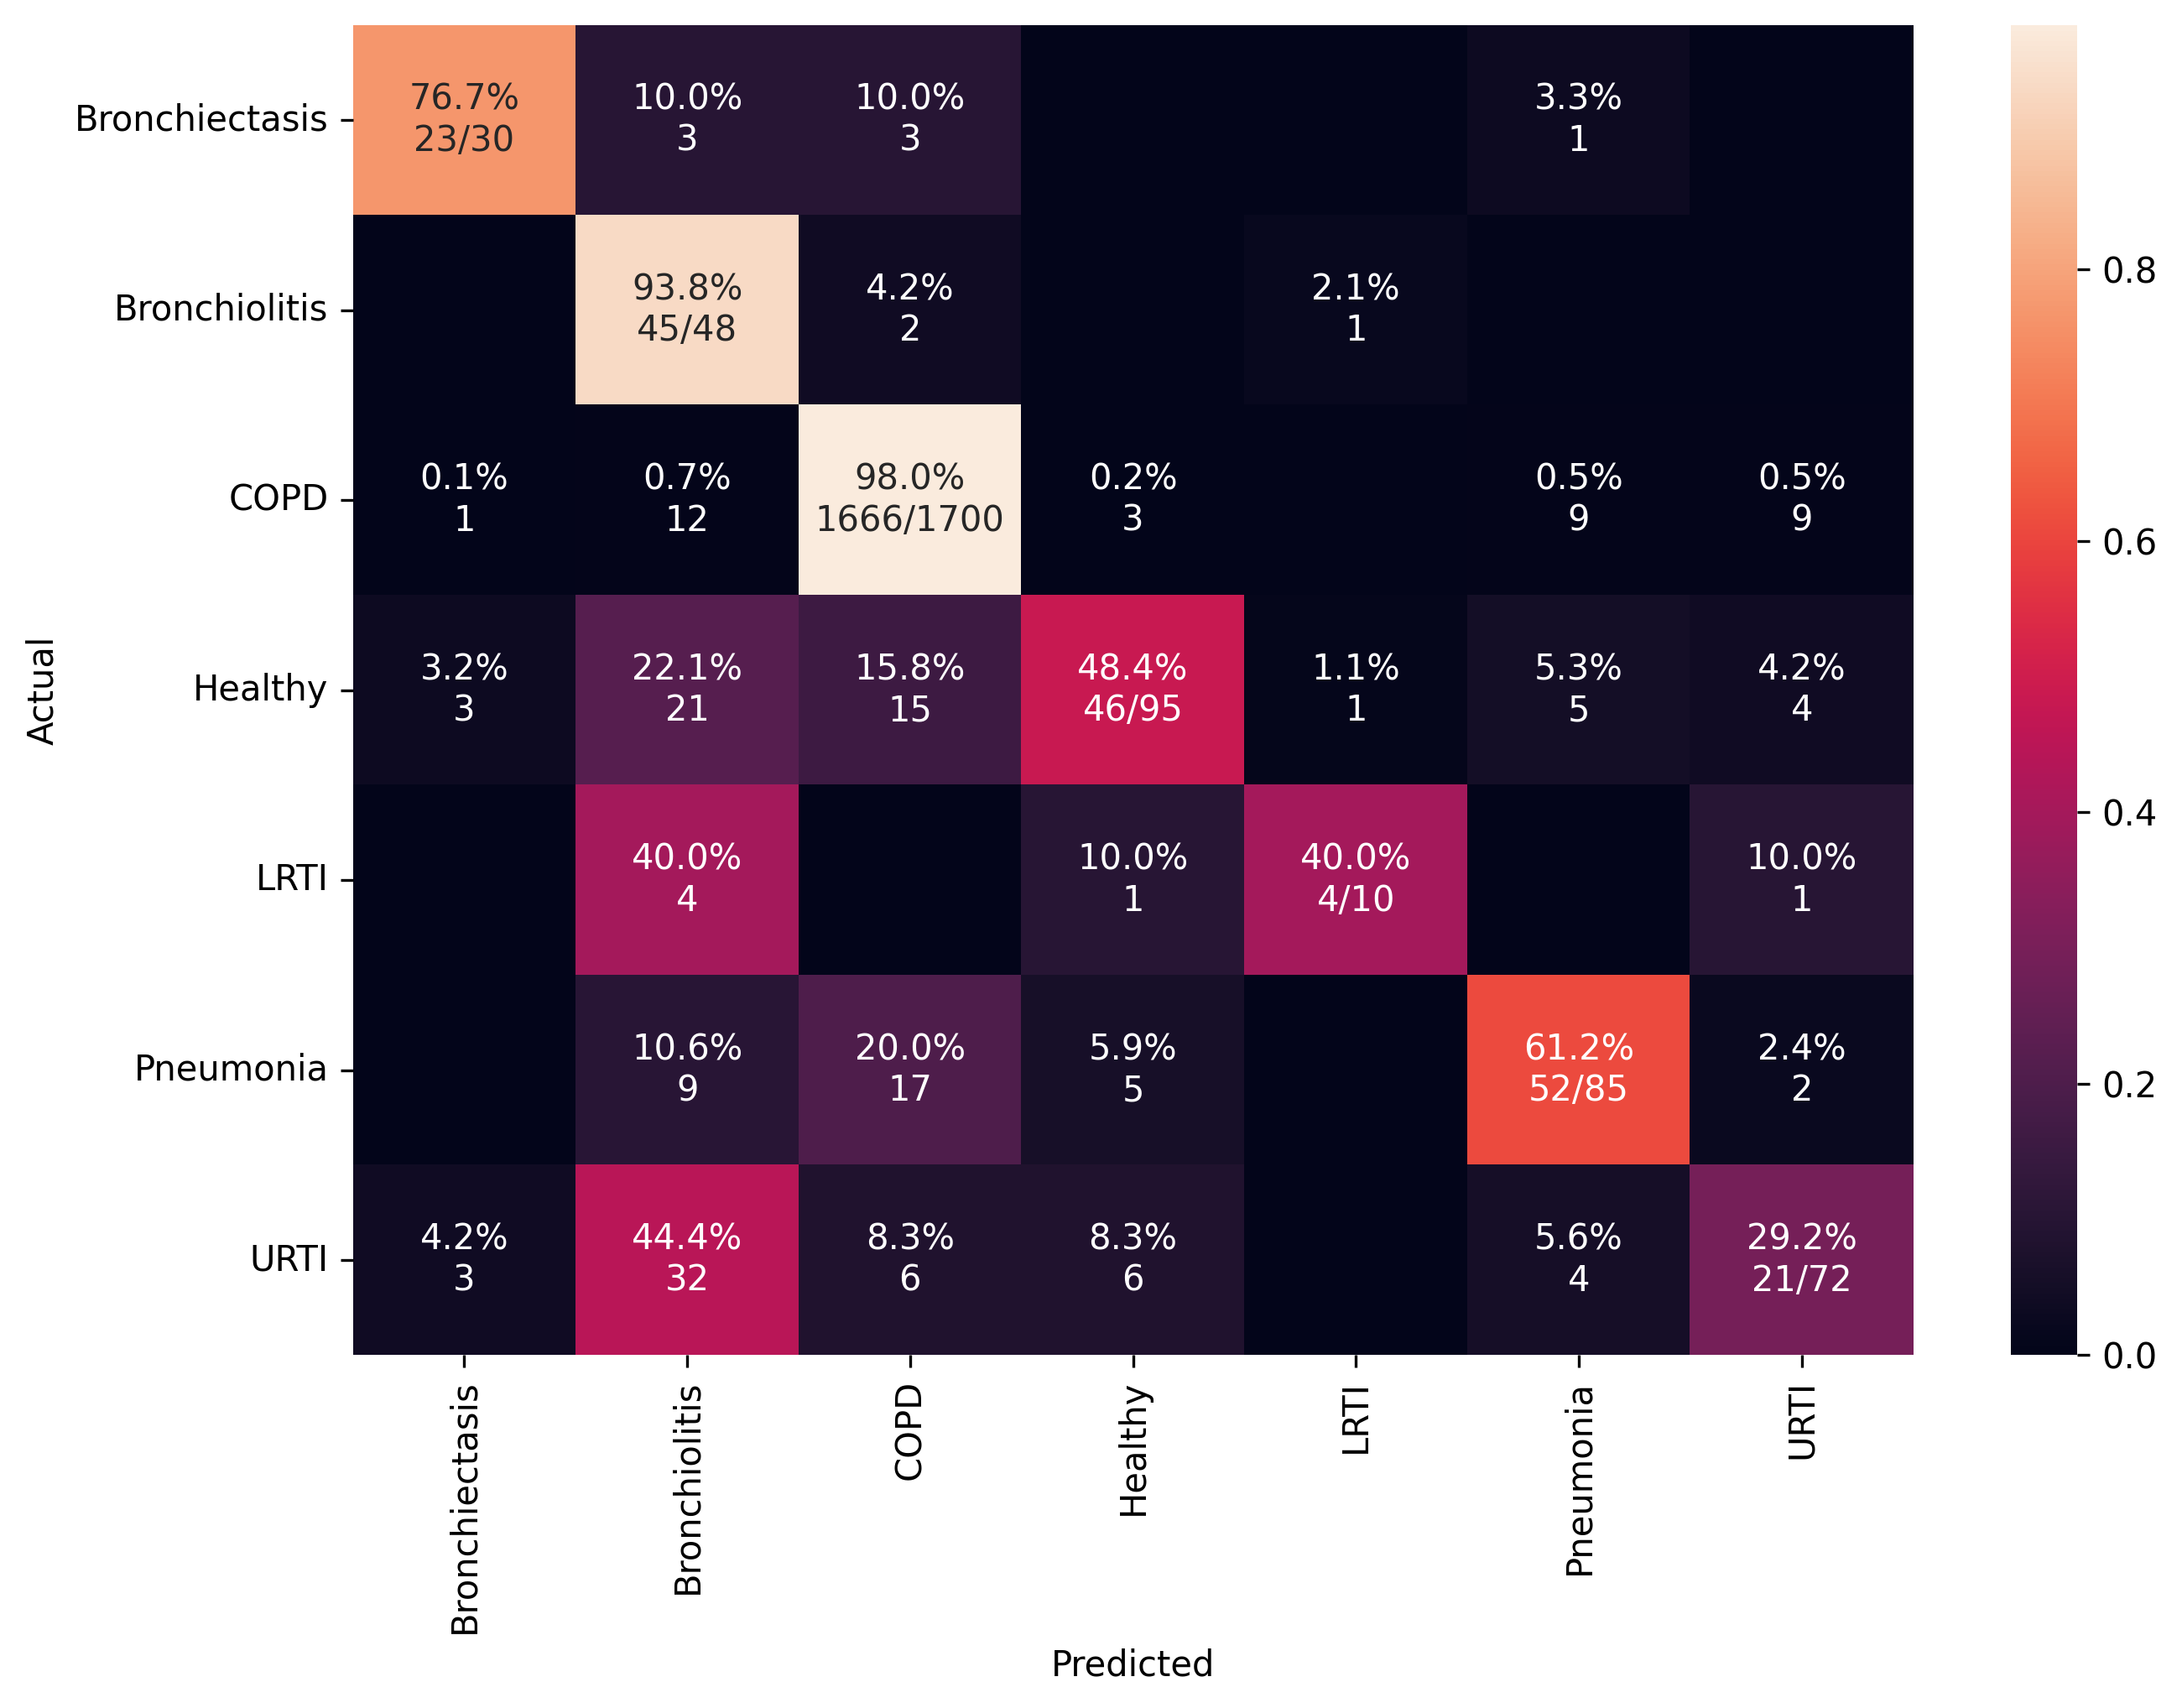

In [97]:
y_pred_class=m.predict(res)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}resnet50-imbalance(3).csv')

# EFFICIENT NET BO

In [98]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model2(X_train_cnn, y_train_encoded, None, None,  X_test_cnn, y_test_encoded)
to_res = (13, 259)
eff = m.EFFICIENT_NET_BO(to_res, input_t)

In [99]:
m.compile_info(eff)
history=m.fit_train(eff, epochs=100, batch_size=256)
m.summary_info(eff)

Epoch 1/100
19/19 [==============================] - 18s 240ms/step - loss: 2.5493 - accuracy: 0.1427
Epoch 2/100
19/19 [==============================] - 3s 173ms/step - loss: 2.4263 - accuracy: 0.1683
Epoch 3/100
19/19 [==============================] - 3s 172ms/step - loss: 2.3639 - accuracy: 0.1875
Epoch 4/100
19/19 [==============================] - 3s 173ms/step - loss: 2.3302 - accuracy: 0.2217
Epoch 5/100
19/19 [==============================] - 3s 173ms/step - loss: 2.2440 - accuracy: 0.2495
Epoch 6/100
19/19 [==============================] - 3s 172ms/step - loss: 2.2013 - accuracy: 0.2823
Epoch 7/100
19/19 [==============================] - 3s 172ms/step - loss: 2.1466 - accuracy: 0.3115
Epoch 8/100
19/19 [==============================] - 3s 172ms/step - loss: 2.0750 - accuracy: 0.3464
Epoch 9/100
19/19 [==============================] - 3s 170ms/step - loss: 2.0438 - accuracy: 0.3756
Epoch 10/100
19/19 [==============================] - 3s 171ms/step - loss: 1.9993 - accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.78      0.60      0.68        30
 Bronchiolitis       0.24      0.21      0.22        48
          COPD       0.94      0.97      0.96      1700
       Healthy       0.29      0.27      0.28        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.37      0.31      0.33        85
          URTI       0.37      0.36      0.36        72

      accuracy                           0.86      2040
     macro avg       0.43      0.39      0.41      2040
  weighted avg       0.85      0.86      0.85      2040



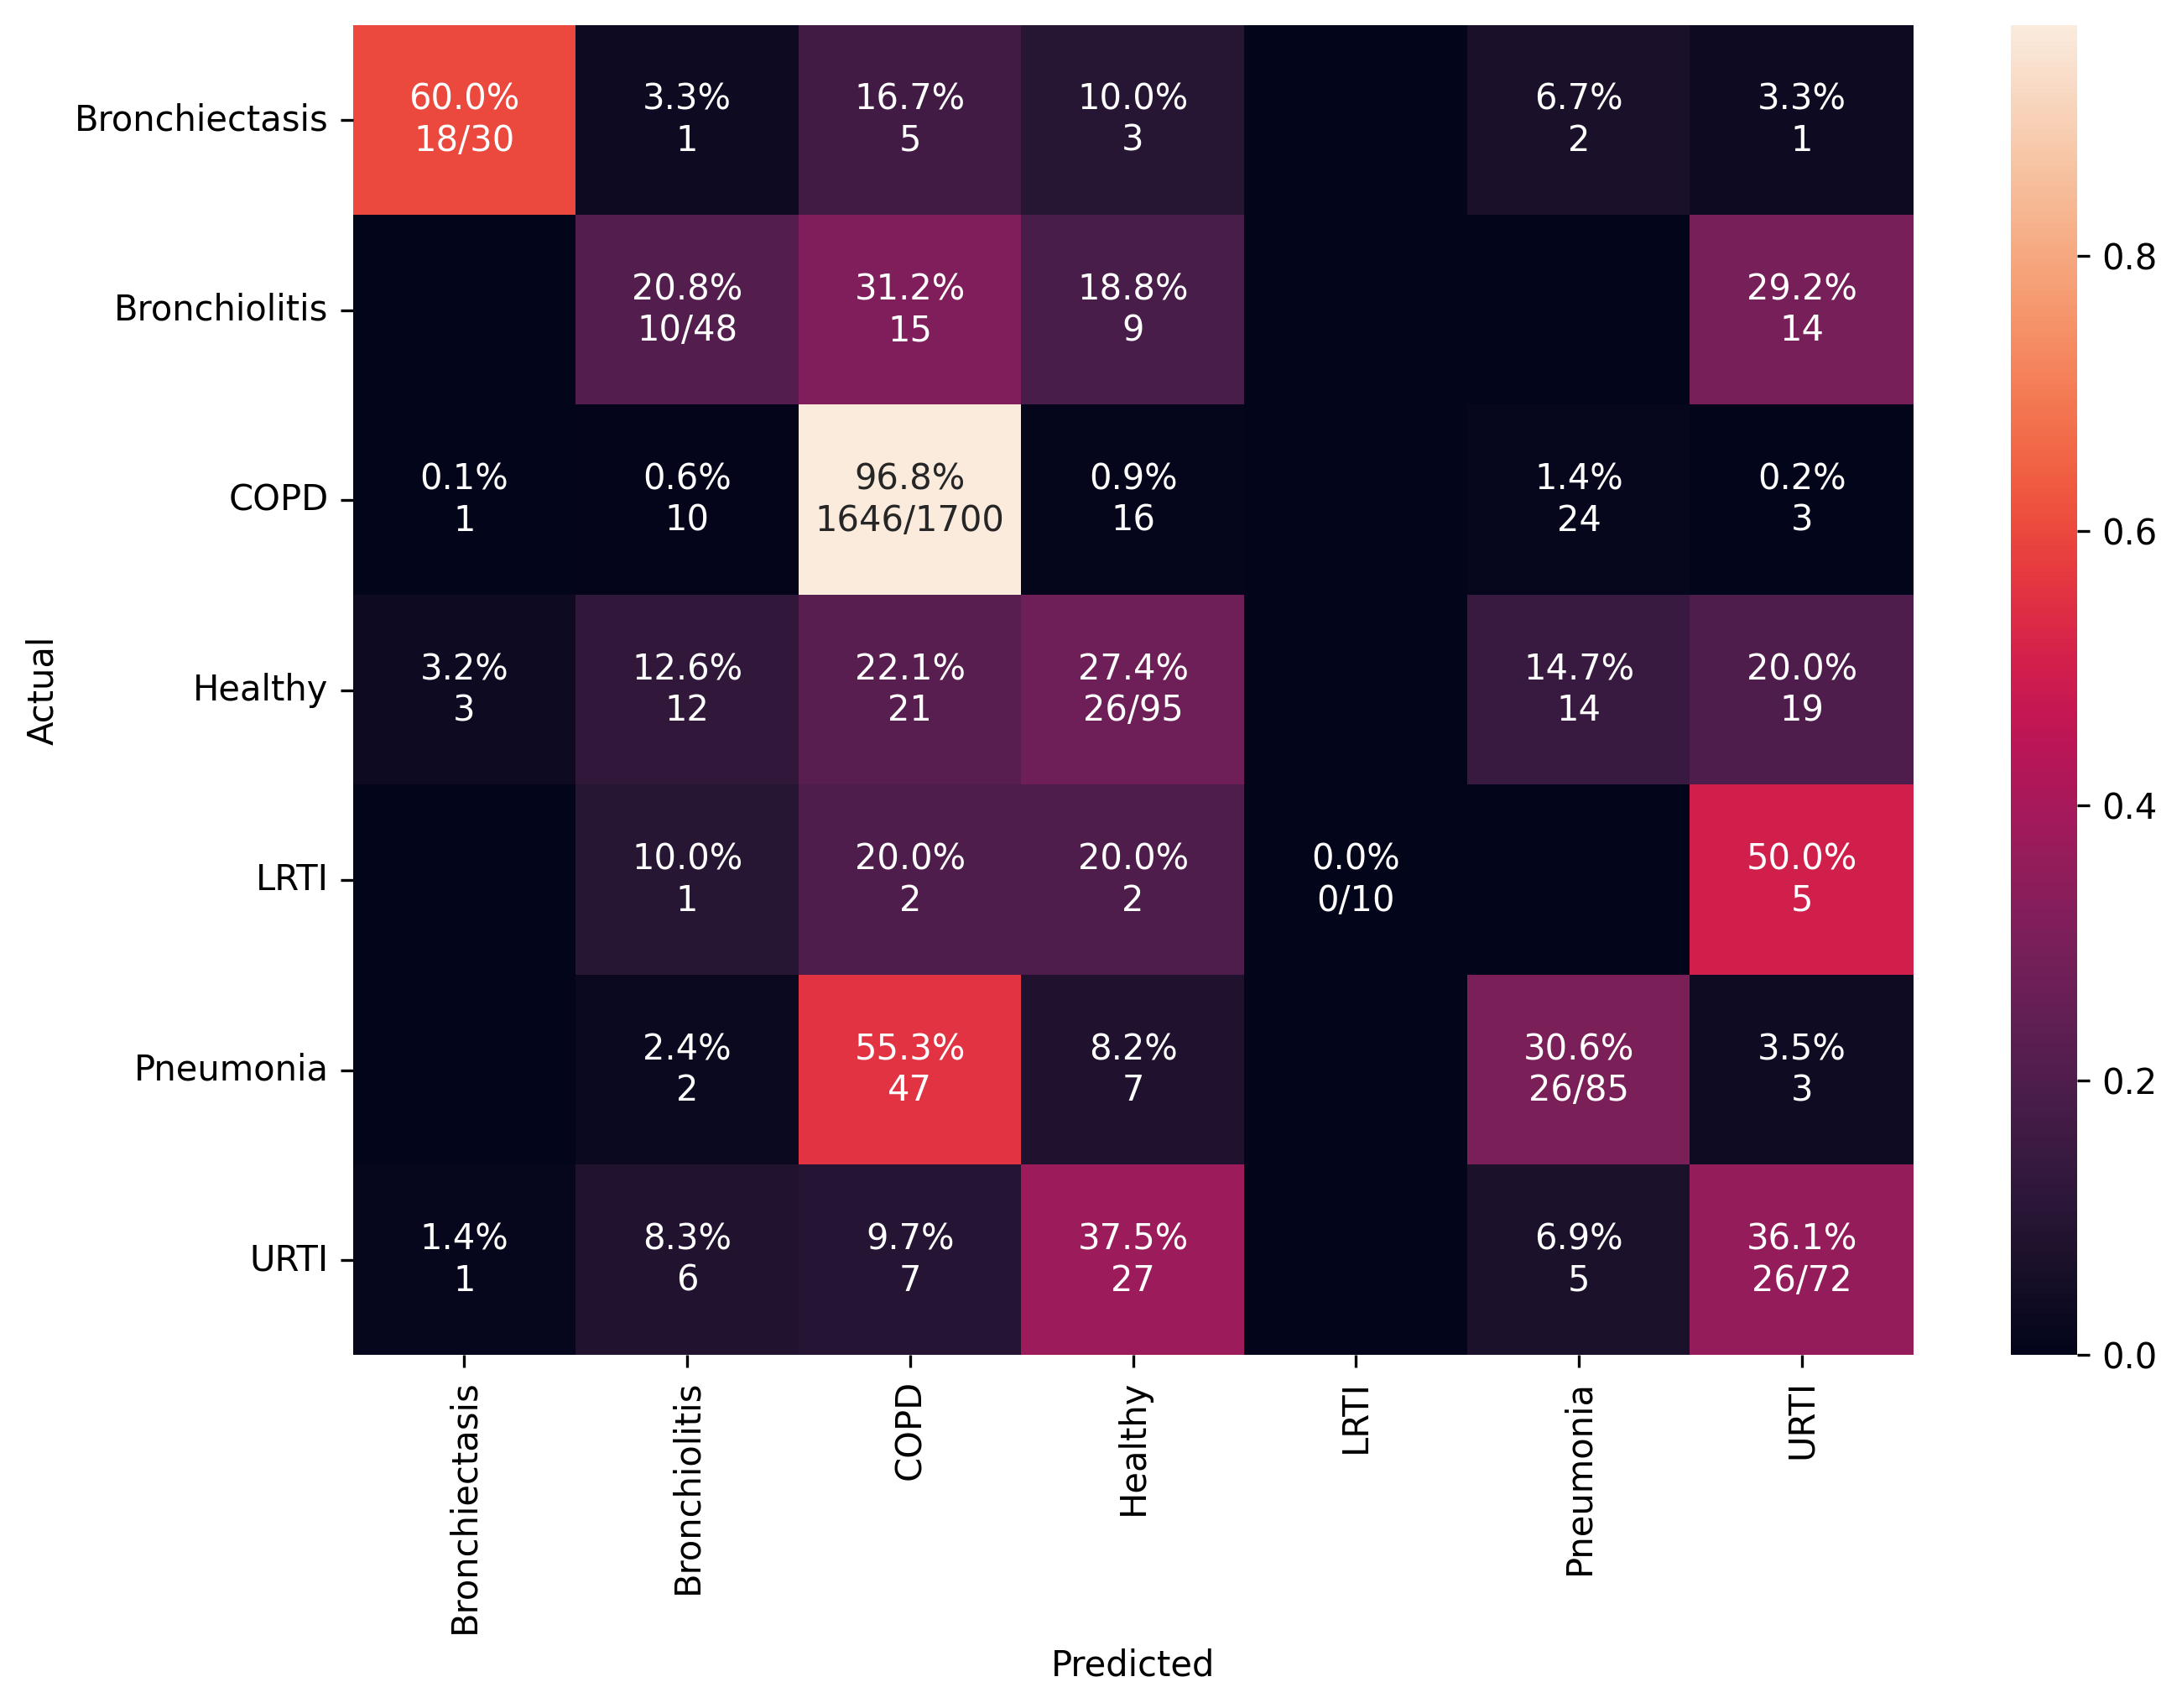

In [100]:
y_pred_class=m.predict(eff)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}efficient-net-b0-imbalance(1).csv')

In [101]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model2(X_train_cnn, y_train_encoded, None, None,  X_test_cnn, y_test_encoded)
to_res = (13, 259)
eff = m.EFFICIENT_NET_BO(to_res, input_t)
m.compile_info(eff)
history=m.fit_train(eff, epochs=100, batch_size=256)
m.summary_info(eff)

Epoch 1/100
19/19 [==============================] - 15s 171ms/step - loss: 2.4429 - accuracy: 0.1835
Epoch 2/100
19/19 [==============================] - 3s 171ms/step - loss: 2.4083 - accuracy: 0.2081
Epoch 3/100
19/19 [==============================] - 3s 172ms/step - loss: 2.3583 - accuracy: 0.2194
Epoch 4/100
19/19 [==============================] - 3s 171ms/step - loss: 2.2932 - accuracy: 0.2459
Epoch 5/100
19/19 [==============================] - 3s 172ms/step - loss: 2.2229 - accuracy: 0.2886
Epoch 6/100
19/19 [==============================] - 3s 171ms/step - loss: 2.2182 - accuracy: 0.3104
Epoch 7/100
19/19 [==============================] - 3s 169ms/step - loss: 2.1650 - accuracy: 0.3338
Epoch 8/100
19/19 [==============================] - 3s 172ms/step - loss: 2.0955 - accuracy: 0.3712
Epoch 9/100
19/19 [==============================] - 3s 171ms/step - loss: 2.0584 - accuracy: 0.3943
Epoch 10/100
19/19 [==============================] - 3s 170ms/step - loss: 2.0055 - accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.89      0.57      0.69        30
 Bronchiolitis       0.40      0.12      0.19        48
          COPD       0.94      0.97      0.95      1700
       Healthy       0.32      0.37      0.34        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.24      0.36      0.29        85
          URTI       0.45      0.12      0.20        72

      accuracy                           0.85      2040
     macro avg       0.46      0.36      0.38      2040
  weighted avg       0.85      0.85      0.85      2040



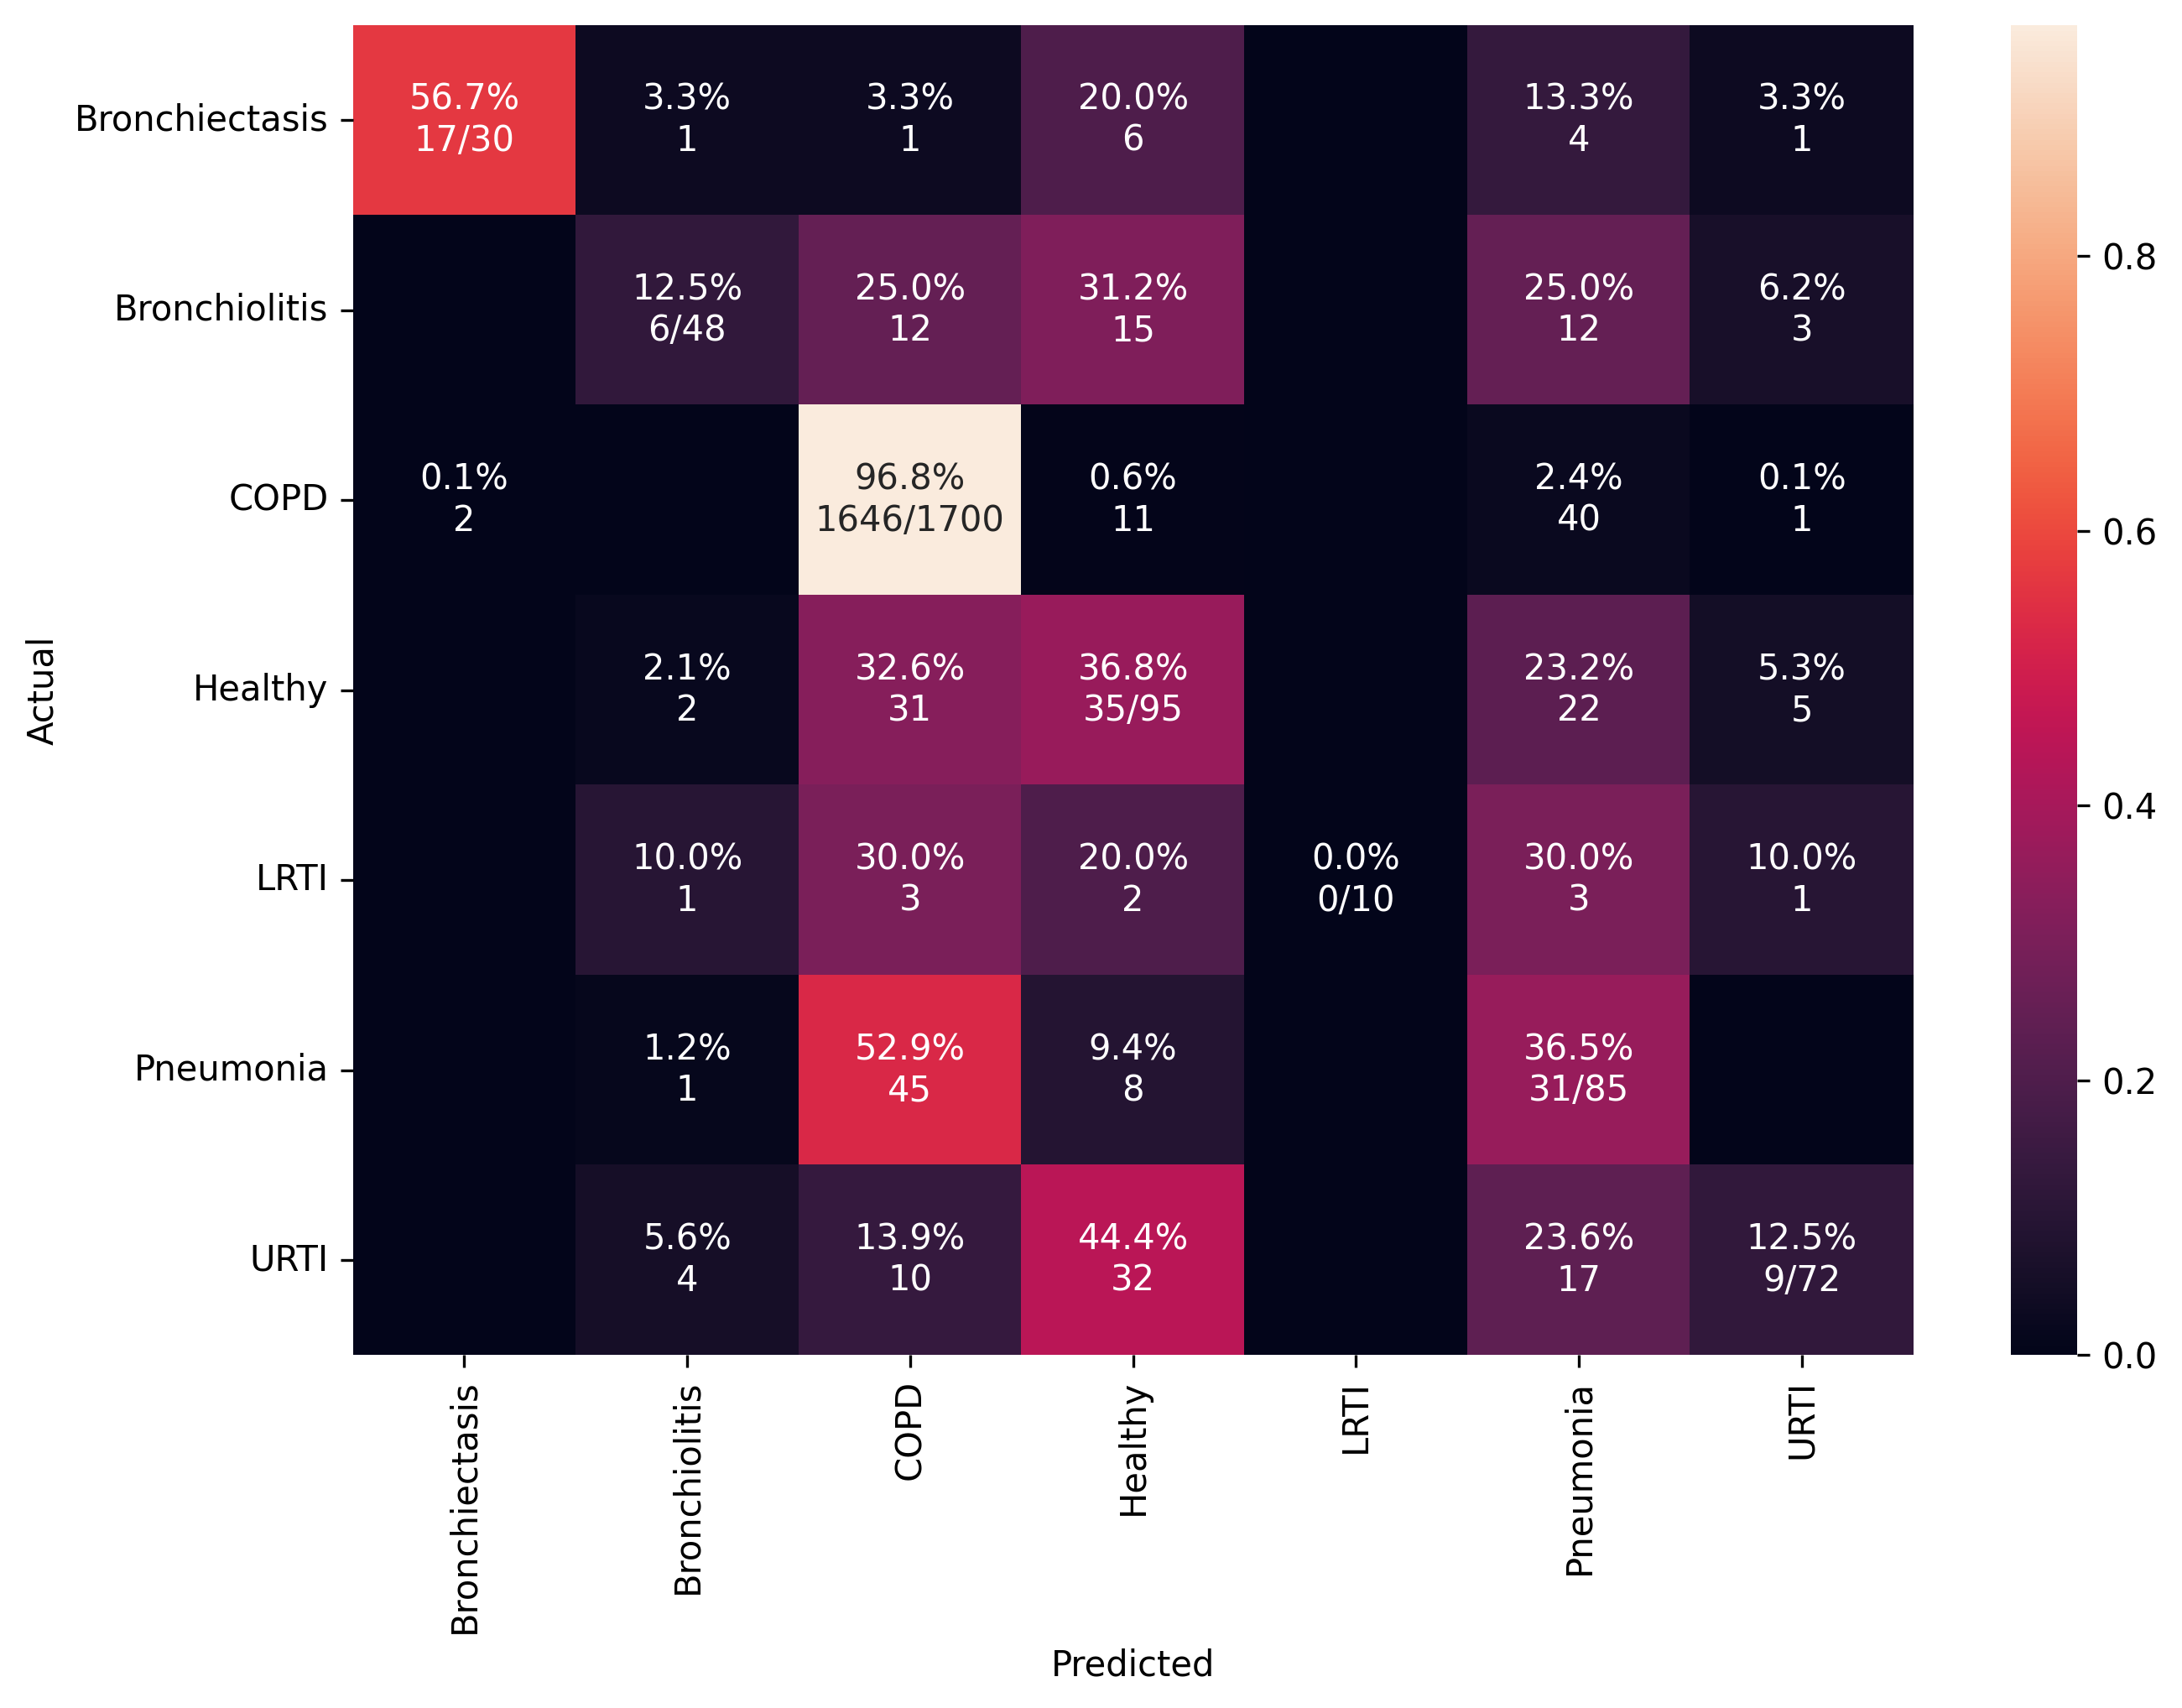

In [102]:
y_pred_class=m.predict(eff)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}efficient-net-b0-imbalance(2).csv')

In [103]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model2(X_train_cnn, y_train_encoded, None, None,  X_test_cnn, y_test_encoded)
to_res = (13, 259)
eff = m.EFFICIENT_NET_BO(to_res, input_t)
m.compile_info(eff)
history=m.fit_train(eff, epochs=100, batch_size=256)
m.summary_info(eff)

Epoch 1/100
19/19 [==============================] - 15s 171ms/step - loss: 2.4713 - accuracy: 0.1435
Epoch 2/100
19/19 [==============================] - 3s 170ms/step - loss: 2.3531 - accuracy: 0.1715
Epoch 3/100
19/19 [==============================] - 3s 170ms/step - loss: 2.2918 - accuracy: 0.2030
Epoch 4/100
19/19 [==============================] - 3s 172ms/step - loss: 2.2770 - accuracy: 0.2274
Epoch 5/100
19/19 [==============================] - 3s 171ms/step - loss: 2.2133 - accuracy: 0.2491
Epoch 6/100
19/19 [==============================] - 3s 170ms/step - loss: 2.1763 - accuracy: 0.2781
Epoch 7/100
19/19 [==============================] - 3s 172ms/step - loss: 2.1477 - accuracy: 0.2915
Epoch 8/100
19/19 [==============================] - 3s 173ms/step - loss: 2.0978 - accuracy: 0.3146
Epoch 9/100
19/19 [==============================] - 3s 170ms/step - loss: 2.0575 - accuracy: 0.3348
Epoch 10/100
19/19 [==============================] - 3s 171ms/step - loss: 1.9933 - accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Bronchiectasis       0.85      0.57      0.68        30
 Bronchiolitis       0.22      0.21      0.21        48
          COPD       0.93      0.98      0.95      1700
       Healthy       0.38      0.42      0.40        95
          LRTI       0.00      0.00      0.00        10
     Pneumonia       0.48      0.35      0.41        85
          URTI       0.71      0.07      0.13        72

      accuracy                           0.87      2040
     macro avg       0.51      0.37      0.40      2040
  weighted avg       0.85      0.87      0.85      2040



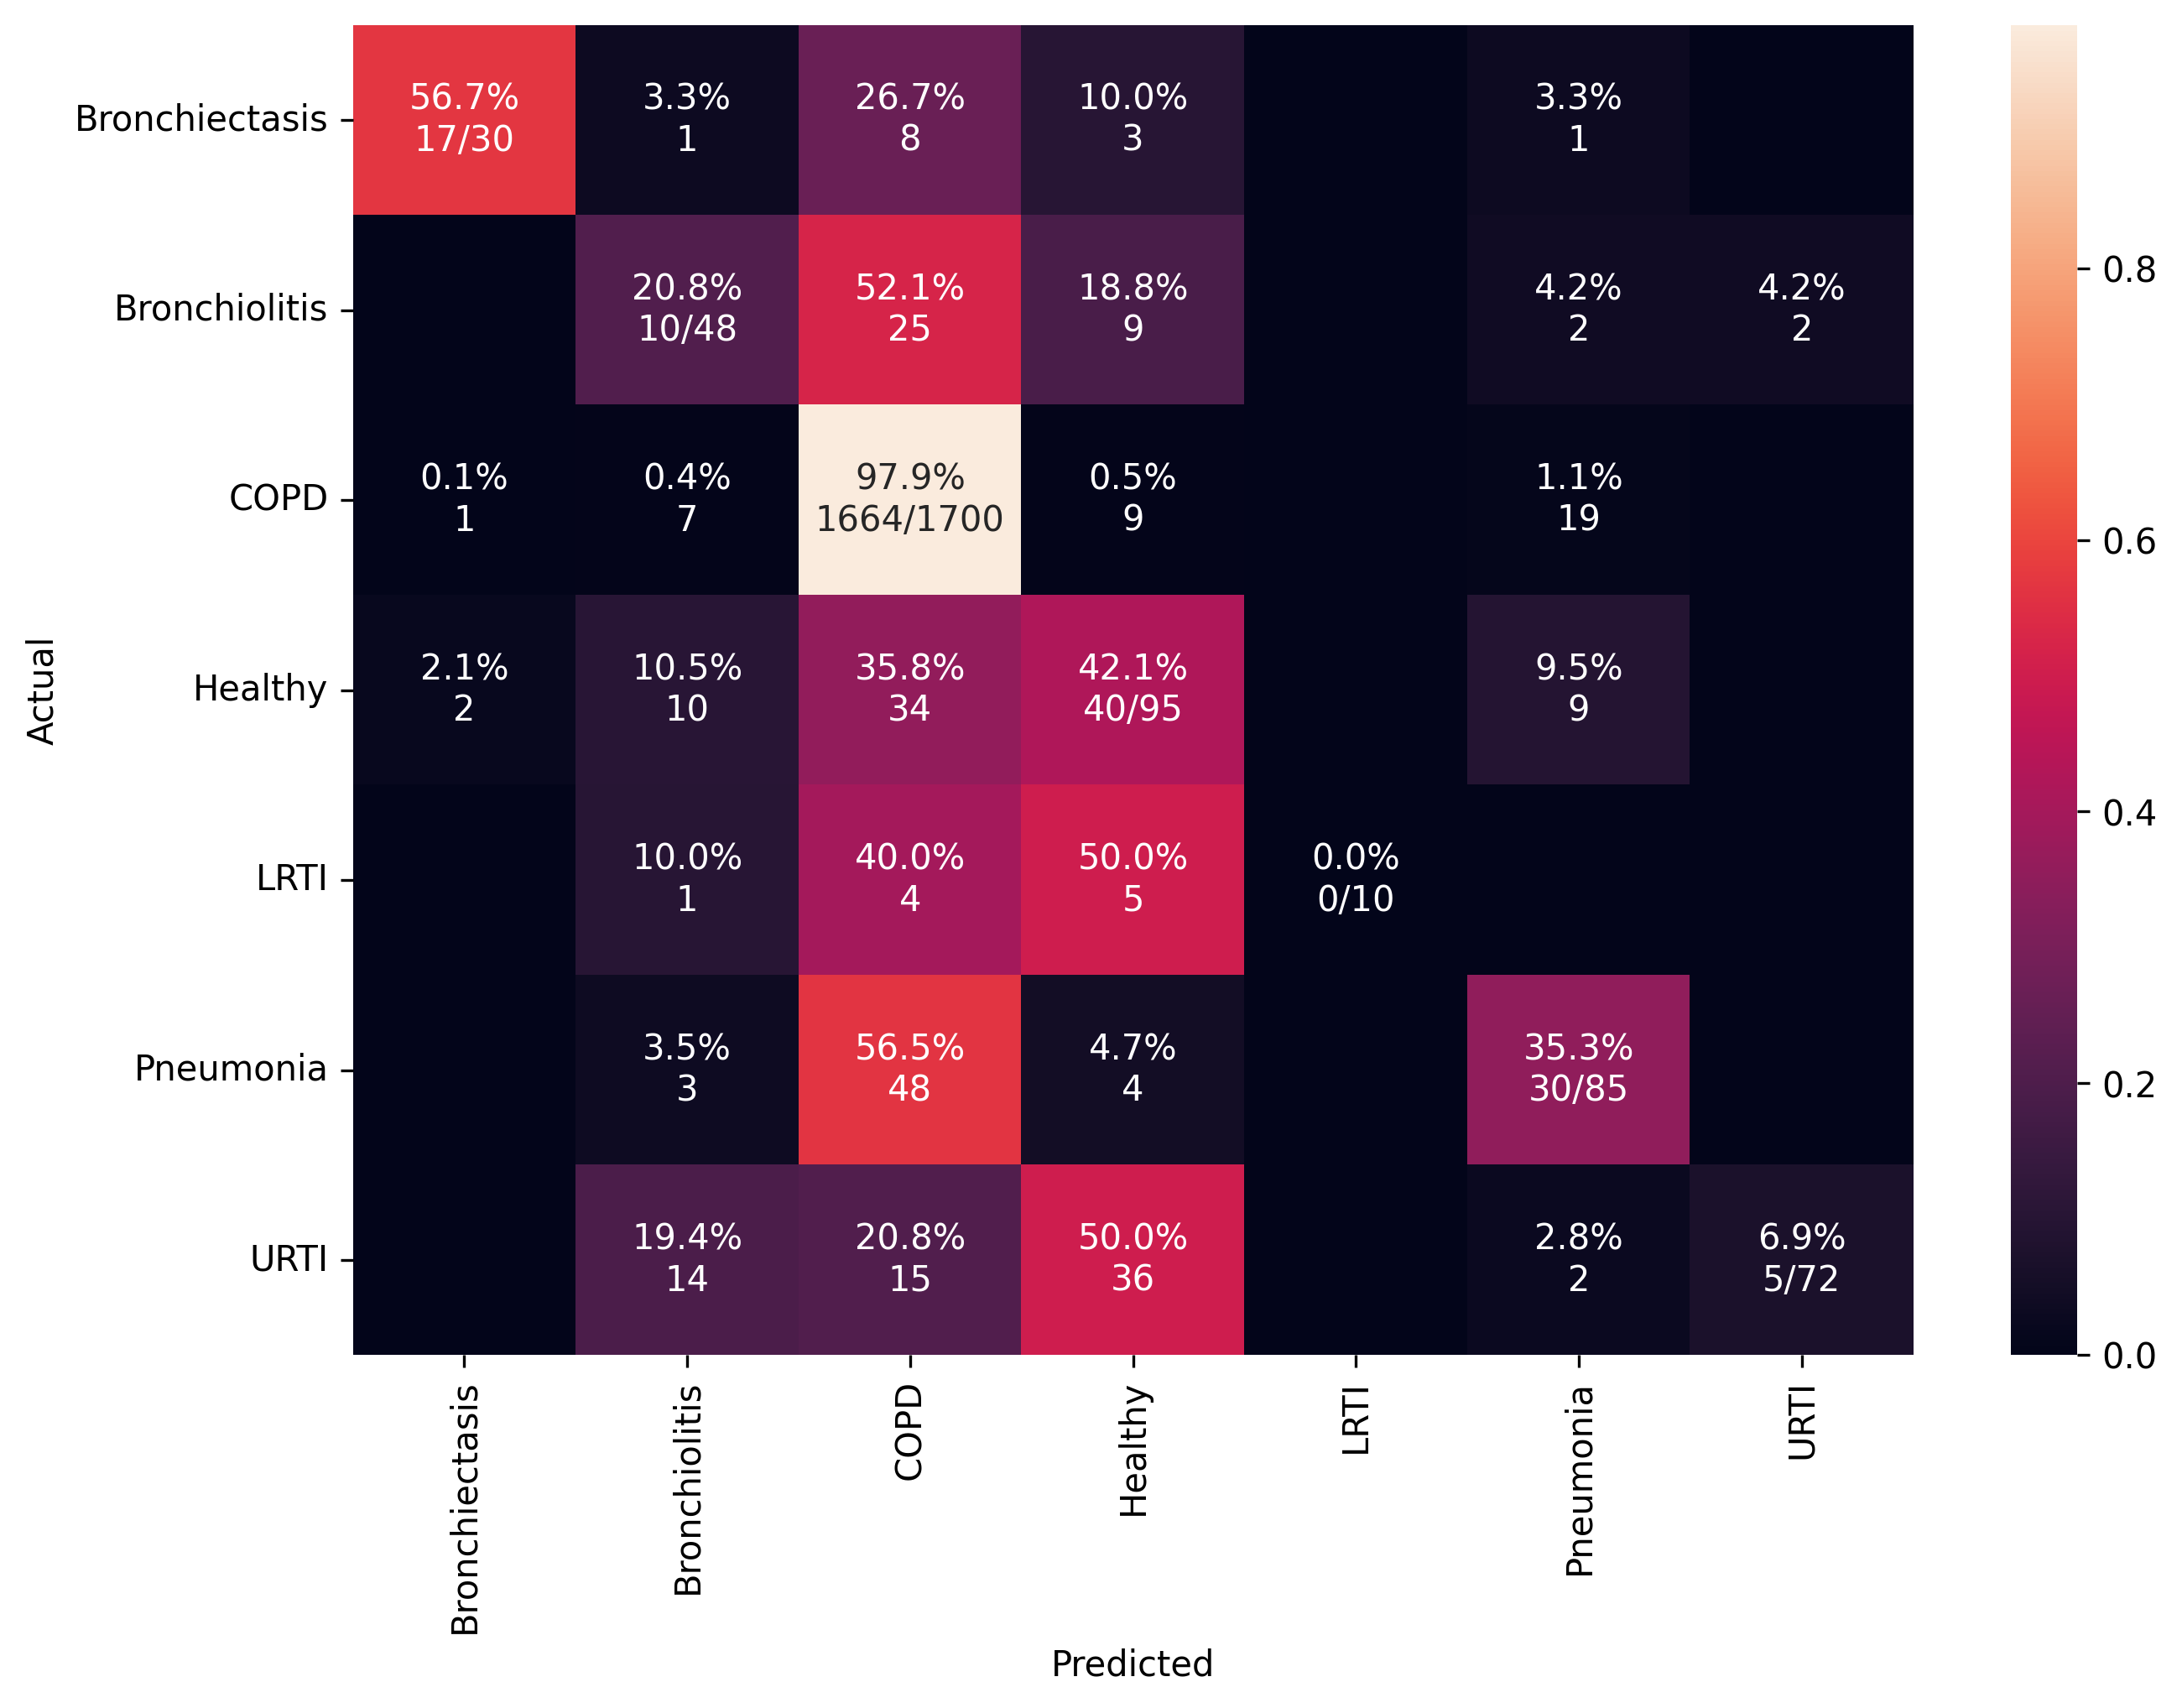

In [104]:
y_pred_class=m.predict(eff)
cm_df = m.confusion_matrix(y_pred_class)
cm_df.set_index(le.classes_)
y_test_final = list()
for i in y_test_encoded:
  y_test_final.append(np.argmax(i))
final=pd.concat([pd.DataFrame(classification_report(y_test_final, y_pred_class, target_names=le.classes_, output_dict=True)).transpose(), cm_df.set_index(le.classes_)], axis=1)
final.to_csv(f'{OUT_DIR}efficient-net-b0-imbalance(3).csv')

# EXTRACTING MELSPECTOGRAM FROM THE SEGMENTED DATASET

In [ ]:
def stft_extract(diagnosis):
    y_generation = list()
    X_generation = list()
    SR = 22050
    OFFSET=0
    y_dict ={'Healthy': 0, 'Pneumonia': 1, 'URTI': 2, 'Bronchiolitis': 3, 
             'Bronchiectasis': 4, 'LRTI': 5} 
    if diagnosis == 'all':
        for index, row in segmented_df.iterrows():
            if row['Diagnosis'] != 'COPD' and row['Diagnosis'] !='Asthma':
                y_val = y_dict[row['Diagnosis']]
                signal, sr = librosa.load(row['Path'], sr=SR
                                                    )
                m = librosa.feature.melspectrogram(y=signal, sr=sr)
                X_generation.append(m)
                y_generation.append(y_val)
    else:

        for index, row in segmented_df.iterrows():
            if row['Diagnosis'] == diagnosis:
                y_val = list(le.classes_).index(diagnosis)
                signal, sr = librosa.load(row['Path'], sr=SR
                                                    )
                m = librosa.feature.melspectrogram(y=signal, sr=sr)
                X_generation.append(m)
                y_generation.append(y_val)
    y_generation = np.array(y_generation)
    X_generation = np.array(X_generation)
    return X_generation, y_generation

# VARIATIONAL AUTOENCODERS -MLP

Variational Autoencoders attemps to model the input distribution from a decodable continous  latent space

GANS perform better than VAE

Generate audio sounds for healthy people

In [ ]:
os.mkdir('/content/drive/MyDrive/vae-mlp-audio')

In [ ]:
segmented_df['Diagnosis'].value_counts()

COPD              5641
Healthy            316
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     100
LRTI                32
Asthma               6
Name: Diagnosis, dtype: int64

In [ ]:
5641-6

5635

In [ ]:
def sampling(args):
        """Reparameterization trick by sampling 
            fr an isotropic unit Gaussian.
        # Arguments:
            args (tensor): mean and log of variance of Q(z|X)
        # Returns:
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        # K is the keras backend
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
disease = 'Asthma'

In [ ]:
X_generation, y_generation = stft_extract(diagnosis=disease)
print('Shape of X gen:', X_generation.shape)
print('shape of y gen:', y_generation.shape)

Shape of X gen: (6, 128, 259)
shape of y gen: (6,)


reparameterization trick

In [ ]:
X_gen_train , X_gen_test , y_gen_train, y_gen_test = train_test_split(
    X_generation, y_generation, test_size=0.3, random_state=0)

In [ ]:
original_dim = X_gen_train.shape[1] * X_gen_train.shape[2]
X_gen_train = np.reshape(X_gen_train, [-1, original_dim])
X_gen_test = np.reshape(X_gen_test, [-1, original_dim])
X_gen_train = X_gen_train.astype('float32')
X_gen_test = X_gen_test.astype('float32')

In [ ]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 2
latent_dim = 2
epochs = 50

In [ ]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


In [ ]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 33152)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          16974336    encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

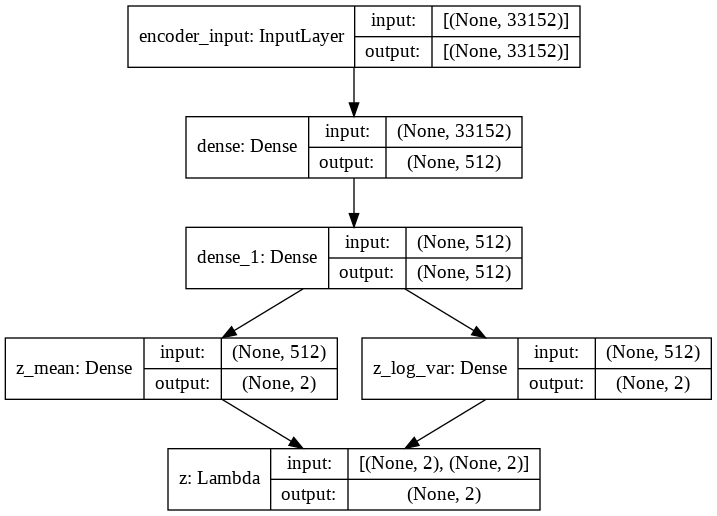

In [ ]:
# instantiate encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 33152)             17006976  
Total params: 17,271,168
Trainable params: 17,271,168
Non-trainable params: 0
_________________________________________________________________


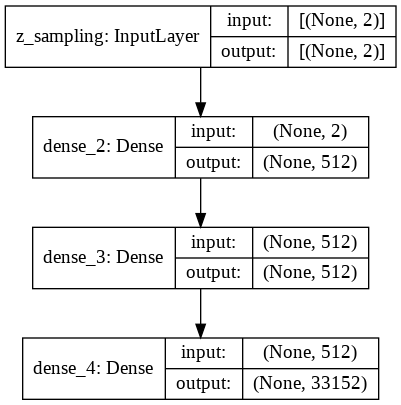

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='vae_mlp_decoder.png', 
           show_shapes=True)

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')


In [ ]:
reconstruction_loss = mse(inputs, outputs) #can be binary cross entropy

In [ ]:
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 33152)]      0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 17239044    encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 33152)        17271168    encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          16974336    encoder_input[0][0]              
____________________________________________________________________________________________

In [ ]:
# train the autoencoder
history=vae.fit(X_gen_train, epochs=epochs, batch_size=batch_size, 
        validation_data=(X_gen_test, None))

Epoch 1/50
2/2 [==============================] - 3s 2s/step - loss: 11402.8177 - val_loss: 12172.2129
Epoch 2/50
2/2 [==============================] - 1s 323ms/step - loss: 10568.7070 - val_loss: 8275.4355
Epoch 3/50
2/2 [==============================] - 1s 313ms/step - loss: 5945.3776 - val_loss: 4576.9844
Epoch 4/50
2/2 [==============================] - 1s 307ms/step - loss: 3235.4829 - val_loss: 4886.1934
Epoch 5/50
2/2 [==============================] - 1s 311ms/step - loss: 3570.9356 - val_loss: 5234.1318
Epoch 6/50
2/2 [==============================] - 1s 312ms/step - loss: 4105.6390 - val_loss: 5300.1484
Epoch 7/50
2/2 [==============================] - 1s 325ms/step - loss: 3832.5951 - val_loss: 5157.0068
Epoch 8/50
2/2 [==============================] - 1s 335ms/step - loss: 3882.8888 - val_loss: 4916.6875
Epoch 9/50
2/2 [==============================] - 1s 310ms/step - loss: 3459.0538 - val_loss: 4685.7612
Epoch 10/50
2/2 [==============================] - 1s 335ms/step

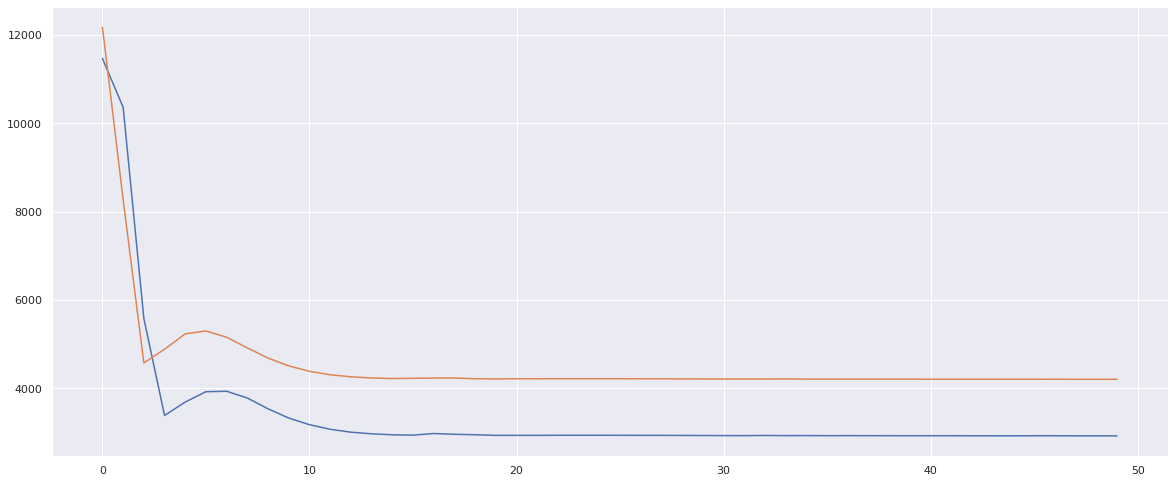

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs,
                           display=False):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    #new_images = np.multiply(new_images,255)
    new_images = new_images.reshape(new_images.shape[0], X_generation.shape[1], X_generation.shape[2])
    # Display some images
    if display:
        fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                                sharey=True, figsize=(40, 10))
        counter = 0
        for i in range(no_of_imgs):
            S_db = librosa.amplitude_to_db(np.abs(new_images[i]), ref=np.max)
            librosa.display.specshow(S_db, ax=axes[counter])
            counter = counter +1
        plt.show()
    return new_images

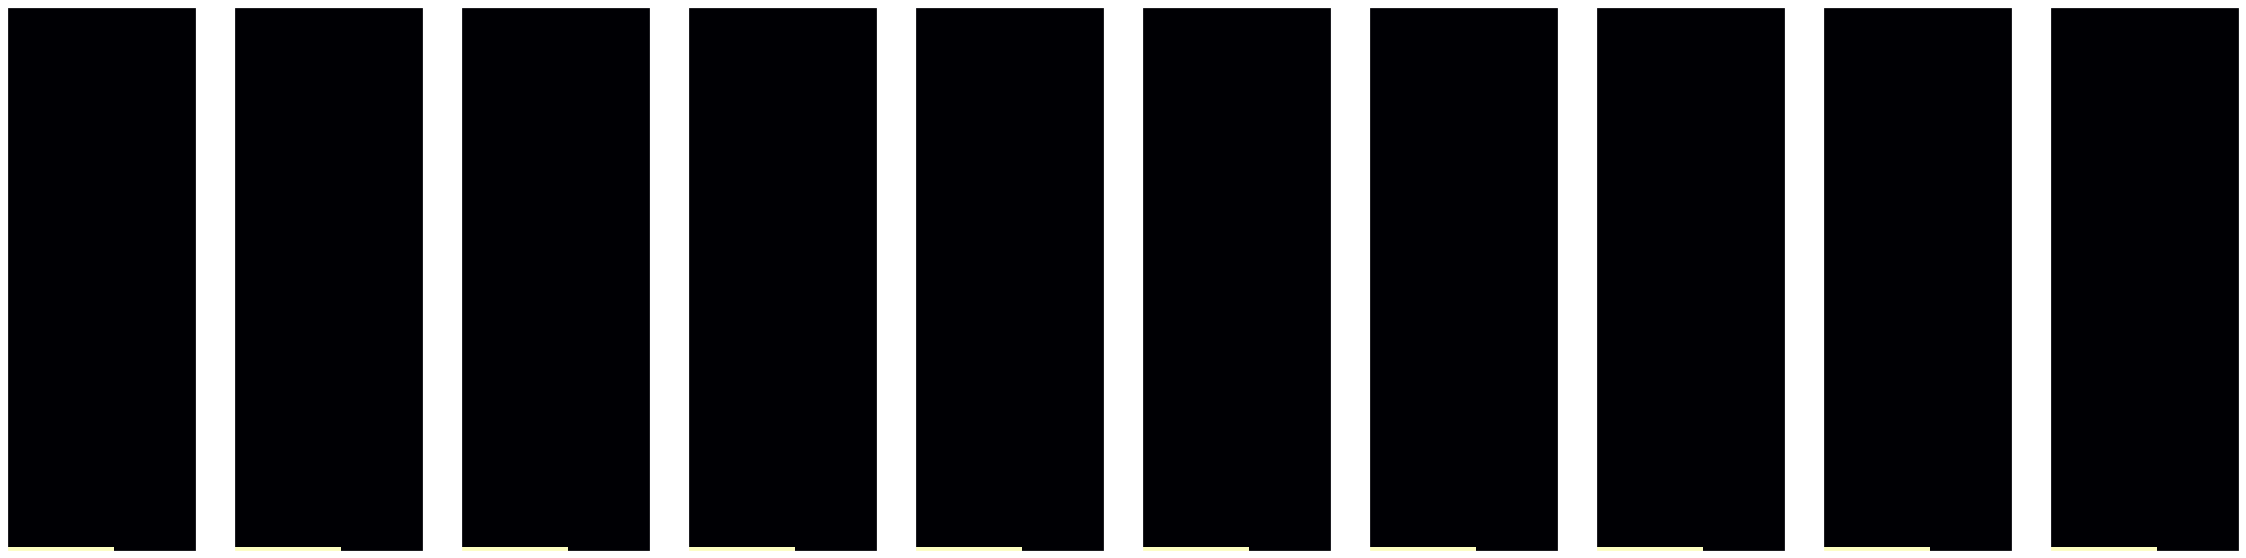

In [ ]:
# Starting point=(0,2), end point=(2,0)
new_images = display_image_sequence(30,30,40,40,10 ,True)

In [ ]:
new_images = display_image_sequence(20,20,40,40,5635 ,False) 

In [ ]:
music=librosa.feature.inverse.mel_to_audio(new_images[4], sr=22050)

In [ ]:
sf.write('trial.wav', music, 22050)

In [ ]:
ipd.Audio('trial.wav')

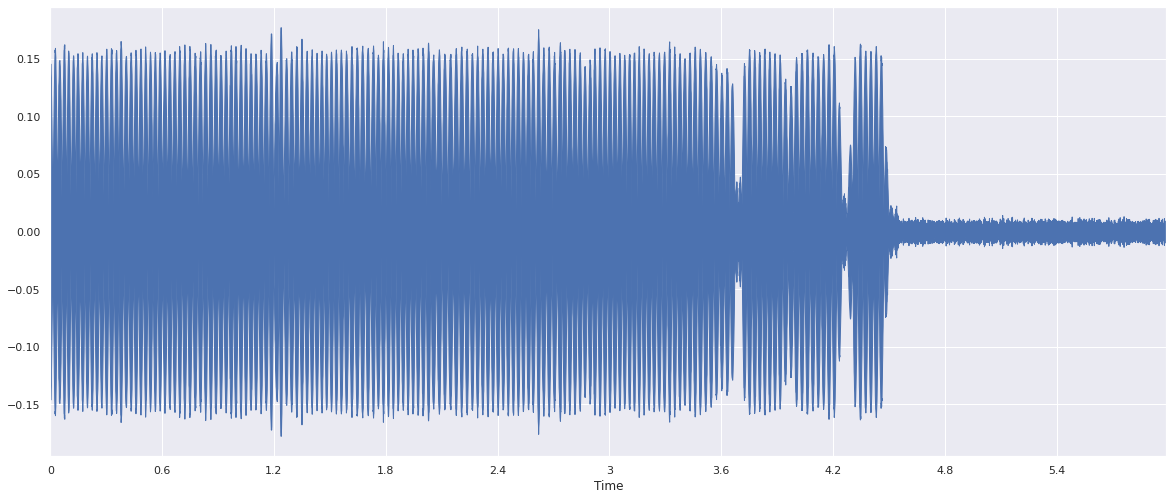

In [ ]:
 librosa.display.waveplot(music, sr=22050)

In [ ]:
!rm -rf '/content/Database/audio_and_txt_files' # do not run

rm: cannot remove '-': No such file or directory
rm: cannot remove 'rf': No such file or directory
rm: cannot remove '/content/Database/audio_and_txt_files': Is a directory


In [ ]:
count = 0
for i in range(len(new_images)):
    try:
        music=librosa.feature.inverse.mel_to_audio(new_images[i], sr=22050)
    except:
        print('Audio buffer is not finite everywhere')
        continue
    
    padded_data = lb.util.fix_length(music, 6*22050)
    sf.write('/content/drive/MyDrive/vae-mlp-audio/{}_{}.wav'.format(disease, count), data=padded_data, samplerate=22050)
    count = count + 1



# EVALUATION OF THE  NEWLY GENERATED SEGMENTED DATA(VIA MLP) ON THE MODELS

In [ ]:
X = list()
y = list()

feature extraction

In [ ]:
for index, row in segmented_df.iterrows(): # no need
    if row['Diagnosis'] == 'Asthma':
        continue
    else:
        f1 = FrequencyDomainFeatures(row['Path'])
        mfccs, _ = f1.mfcc()
        X.append(mfccs)
        y.append(row['Diagnosis'])

In [ ]:
len(X)

6799

In [ ]:
for i in os.listdir('/content/drive/MyDrive/VAE-MLP-DATA/vae-mlp-audio'):
    diagnosis = i.split('_')[0]
    if diagnosis == 'Asthma' or diagnosis =='Bronchiectasis':
        continue
    else:
        f1 = FrequencyDomainFeatures(os.path.join('/content/drive/MyDrive/VAE-MLP-DATA/vae-mlp-audio', i))
        mfccs, _ = f1.mfcc()
        X.append(mfccs)
        y.append(diagnosis)

In [ ]:
count = 0
for i in os.listdir('/content/drive/MyDrive/VAE-MLP-DATA/vae-mlp-bronco'):
    count = count + 1
    f1 = FrequencyDomainFeatures(os.path.join('/content/drive/MyDrive/VAE-MLP-DATA/vae-mlp-bronco', i))
    mfccs, _ = f1.mfcc()
    X.append(mfccs)
    y.append('Bronchiectasis')

In [ ]:
len(X)

39503

In [ ]:
for i in set(y):
    print(i, y.count(i))

URTI 5641
COPD 5665
LRTI 5641
Bronchiectasis 5642
Pneumonia 5637
Bronchiolitis 5641
Healthy 5636


In [ ]:
X = np.array(X)
y= np.array(y)

In [ ]:
y

labelencoding

In [ ]:
y=le.transform(y)
y=np_utils.to_categorical(y)

In [ ]:
le.classes_

array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI',
       'Pneumonia', 'URTI'], dtype='<U14')

In [ ]:
segmented_df['Diagnosis'].value_counts()

COPD              5665
Healthy            317
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     101
LRTI                32
Asthma               6
Name: Diagnosis, dtype: int64

splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.3, random_state=0)

In [ ]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of X_val :', X_val.shape)
print('Shape of y_val :', y_val.shape)
print('Shape of X_test :', X_test.shape)
print('Shape of y_test : ', y_test.shape)

Shape of X_train: (19356, 13, 130)
Shape of y_train : (19356, 7)
Shape of X_val : (8296, 13, 130)
Shape of y_val : (8296, 7)
Shape of X_test : (11851, 13, 130)
Shape of y_test :  (11851, 7)


In [ ]:
m = Model(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
ann_model = m.ANN()
m.compile_info(ann_model)

In [ ]:
m.summary_info(ann_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [ ]:
history=m.fit_train(ann_model,epochs=100, batch_size=256 )

Epoch 1/100
76/76 [==============================] - 3s 7ms/step - loss: 8.7847 - accuracy: 0.2625 - val_loss: 1.0968 - val_accuracy: 0.4690
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 1.7420 - accuracy: 0.4151 - val_loss: 0.8302 - val_accuracy: 0.6050
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 1.2017 - accuracy: 0.5414 - val_loss: 0.7015 - val_accuracy: 0.8034
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.9149 - accuracy: 0.6390 - val_loss: 0.4463 - val_accuracy: 0.8728
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.6450 - accuracy: 0.7537 - val_loss: 0.2733 - val_accuracy: 0.9523
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 0.4403 - accuracy: 0.8512 - val_loss: 0.1682 - val_accuracy: 0.9607
Epoch 7/100
76/76 [==============================] - 0s 5ms/step - loss: 0.2902 - accuracy: 0.9133 - val_loss: 0.1226 - val_accuracy: 0.9615
Epoch 8/100
7

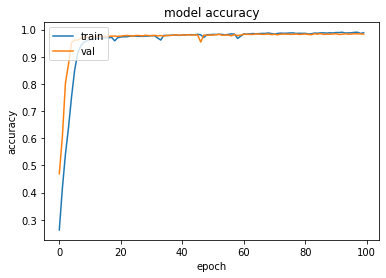

In [ ]:
m.plot_accuracy(history)

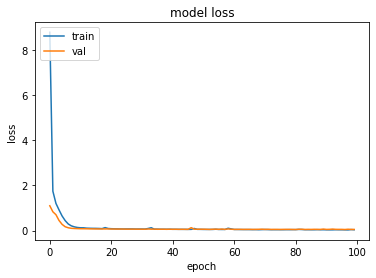

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       0.99      1.00      0.99      1653
 Bronchiolitis       0.97      0.99      0.98      1661
          COPD       0.97      0.99      0.98      1692
       Healthy       0.98      0.96      0.97      1725
          LRTI       1.00      1.00      1.00      1713
     Pneumonia       0.99      0.98      0.99      1641
          URTI       0.99      0.97      0.98      1766

      accuracy                           0.98     11851
     macro avg       0.98      0.98      0.98     11851
  weighted avg       0.98      0.98      0.98     11851



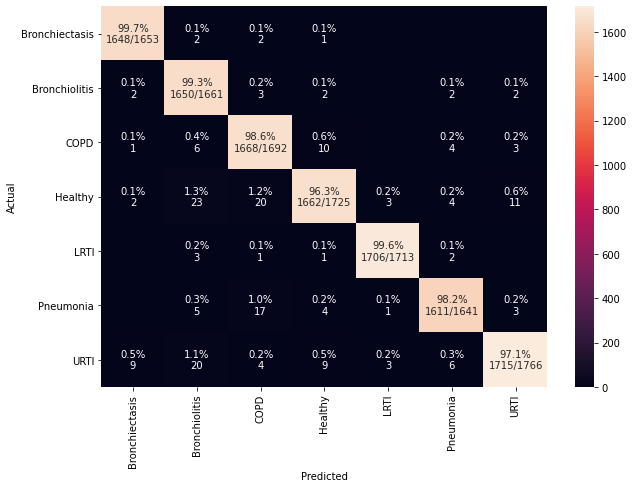

In [ ]:
y_pred=m.predict(ann_model)
m.confusion_matrix(y_pred)

In [ ]:
X_train_cnn = X_train
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],
                                  X_train_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
X_val_cnn = X_val
X_val_cnn = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1],
                                  X_val_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
X_test_cnn = X_test
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],
                                  X_test_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1

In [ ]:
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)

In [ ]:
cnn_model = m.CNN()
m.compile_info(cnn_model)
m.summary_info(cnn_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 128, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 64, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 64, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 63, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 32, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 32, 32)         128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)             

In [ ]:
history=m.fit_train(cnn_model,epochs=100, batch_size=256 )

Epoch 1/100
76/76 [==============================] - 15s 13ms/step - loss: 1.7151 - accuracy: 0.3022 - val_loss: 1.4528 - val_accuracy: 0.5247
Epoch 2/100
76/76 [==============================] - 1s 9ms/step - loss: 1.1486 - accuracy: 0.5849 - val_loss: 0.6684 - val_accuracy: 0.9626
Epoch 3/100
76/76 [==============================] - 1s 8ms/step - loss: 0.6001 - accuracy: 0.8126 - val_loss: 0.2415 - val_accuracy: 0.9667
Epoch 4/100
76/76 [==============================] - 1s 8ms/step - loss: 0.3486 - accuracy: 0.8958 - val_loss: 0.1260 - val_accuracy: 0.9685
Epoch 5/100
76/76 [==============================] - 1s 9ms/step - loss: 0.2460 - accuracy: 0.9279 - val_loss: 0.1044 - val_accuracy: 0.9696
Epoch 6/100
76/76 [==============================] - 1s 9ms/step - loss: 0.1965 - accuracy: 0.9439 - val_loss: 0.0934 - val_accuracy: 0.9706
Epoch 7/100
76/76 [==============================] - 1s 8ms/step - loss: 0.1704 - accuracy: 0.9491 - val_loss: 0.0889 - val_accuracy: 0.9718
Epoch 8/100

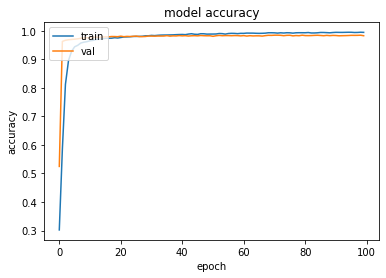

In [ ]:
m.plot_accuracy(history)

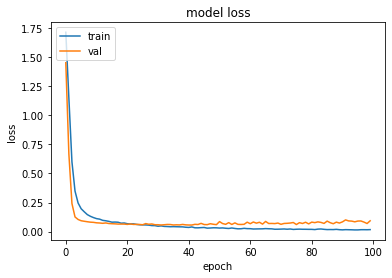

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.99      1.00      1653
 Bronchiolitis       0.99      0.99      0.99      1661
          COPD       0.95      0.99      0.97      1692
       Healthy       0.98      0.97      0.97      1725
          LRTI       1.00      0.99      1.00      1713
     Pneumonia       0.99      0.98      0.98      1641
          URTI       0.98      0.97      0.98      1766

      accuracy                           0.98     11851
     macro avg       0.98      0.98      0.98     11851
  weighted avg       0.98      0.98      0.98     11851



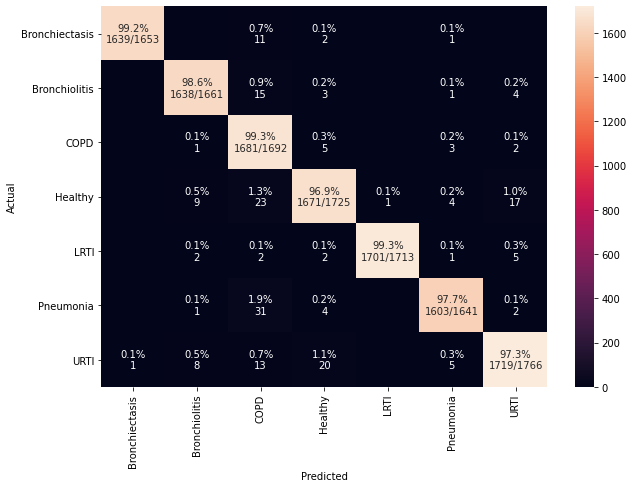

In [ ]:
y_pred=m.predict(cnn_model)
m.confusion_matrix(y_pred)

rnn

In [ ]:
m = Model(X_train, y_train, X_val, y_val, X_test, y_test)
rnn = m.RNN_LSTM()

In [ ]:
m.compile_info(rnn)
m.summary_info(rnn)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 64)            49920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

In [ ]:
history=m.fit_train(rnn, epochs=100, batch_size=256)

Epoch 1/100
76/76 [==============================] - 4s 15ms/step - loss: 1.5455 - accuracy: 0.5227 - val_loss: 0.8765 - val_accuracy: 0.7601
Epoch 2/100
76/76 [==============================] - 1s 7ms/step - loss: 0.5660 - accuracy: 0.8398 - val_loss: 0.2422 - val_accuracy: 0.9500
Epoch 3/100
76/76 [==============================] - 1s 7ms/step - loss: 0.2109 - accuracy: 0.9567 - val_loss: 0.1494 - val_accuracy: 0.9662
Epoch 4/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1579 - accuracy: 0.9641 - val_loss: 0.1321 - val_accuracy: 0.9667
Epoch 5/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1362 - accuracy: 0.9670 - val_loss: 0.1240 - val_accuracy: 0.9675
Epoch 6/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1289 - accuracy: 0.9676 - val_loss: 0.1182 - val_accuracy: 0.9685
Epoch 7/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1220 - accuracy: 0.9684 - val_loss: 0.1113 - val_accuracy: 0.9705
Epoch 8/100


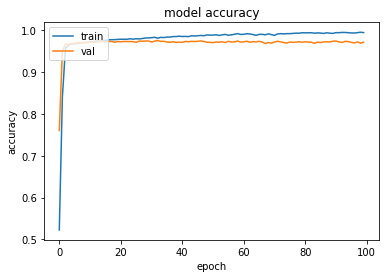

In [ ]:
m.plot_accuracy(history)

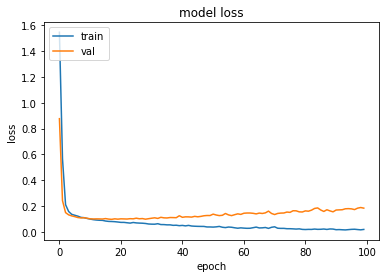

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       0.99      0.99      0.99      1653
 Bronchiolitis       0.99      0.98      0.98      1661
          COPD       0.91      0.94      0.93      1692
       Healthy       0.96      0.96      0.96      1725
          LRTI       1.00      0.99      1.00      1713
     Pneumonia       0.97      0.97      0.97      1641
          URTI       0.98      0.97      0.97      1766

      accuracy                           0.97     11851
     macro avg       0.97      0.97      0.97     11851
  weighted avg       0.97      0.97      0.97     11851



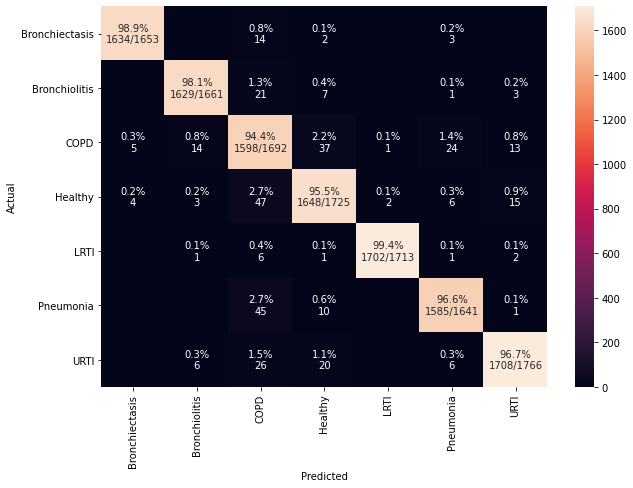

In [ ]:
y_pred=m.predict(rnn)
m.confusion_matrix(y_pred)

resnet-50

In [ ]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
res_model = tf.keras.applications.ResNet50(include_top=False, weights=None,
                                       input_tensor=input_t)
to_res = (13,130)

In [ ]:
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
res = m.RESNET_50(to_res)
m.compile_info(res)
history=m.fit_train(res, epochs=100, batch_size=256)
m.summary_info(res)

Epoch 1/100
76/76 [==============================] - 19s 160ms/step - loss: 1.2498 - accuracy: 0.5641 - val_loss: 2.0011 - val_accuracy: 0.1436
Epoch 2/100
76/76 [==============================] - 10s 134ms/step - loss: 0.3338 - accuracy: 0.9065 - val_loss: 2.2680 - val_accuracy: 0.1418
Epoch 3/100
76/76 [==============================] - 10s 134ms/step - loss: 0.1938 - accuracy: 0.9484 - val_loss: 2.6628 - val_accuracy: 0.1696
Epoch 4/100
76/76 [==============================] - 10s 134ms/step - loss: 0.1482 - accuracy: 0.9594 - val_loss: 2.1957 - val_accuracy: 0.3335
Epoch 5/100
76/76 [==============================] - 10s 134ms/step - loss: 0.1245 - accuracy: 0.9639 - val_loss: 1.2434 - val_accuracy: 0.7436
Epoch 6/100
76/76 [==============================] - 10s 134ms/step - loss: 0.1132 - accuracy: 0.9658 - val_loss: 0.1878 - val_accuracy: 0.9302
Epoch 7/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0997 - accuracy: 0.9692 - val_loss: 0.2105 - val_accuracy:

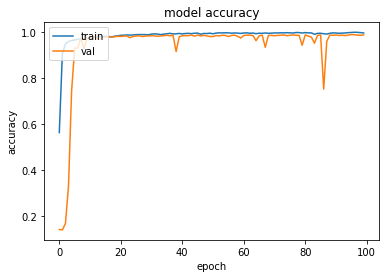

In [ ]:
m.plot_accuracy(history)

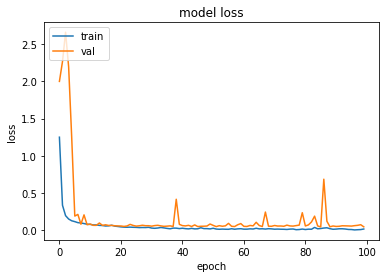

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00      1653
 Bronchiolitis       0.99      0.99      0.99      1661
          COPD       0.98      0.99      0.98      1692
       Healthy       0.98      0.98      0.98      1725
          LRTI       1.00      0.99      1.00      1713
     Pneumonia       0.99      0.99      0.99      1641
          URTI       0.99      0.98      0.98      1766

      accuracy                           0.99     11851
     macro avg       0.99      0.99      0.99     11851
  weighted avg       0.99      0.99      0.99     11851



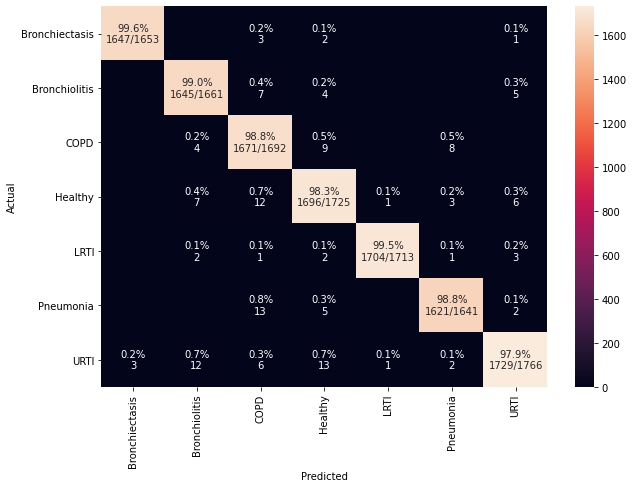

In [ ]:
y_pred=m.predict(res)
m.confusion_matrix(y_pred)

efficient-b0

In [ ]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
to_res = (13,130)
eff = m.EFFICIENT_NET_BO(to_res, input_t)

In [ ]:
m.compile_info(eff)
history=m.fit_train(eff, epochs=100, batch_size=256)
m.summary_info(eff)

Epoch 1/100
76/76 [==============================] - 20s 146ms/step - loss: 2.0668 - accuracy: 0.2831 - val_loss: 1.9509 - val_accuracy: 0.1379
Epoch 2/100
76/76 [==============================] - 9s 119ms/step - loss: 1.4302 - accuracy: 0.5009 - val_loss: 1.9789 - val_accuracy: 0.1436
Epoch 3/100
76/76 [==============================] - 9s 120ms/step - loss: 1.0999 - accuracy: 0.6372 - val_loss: 1.9995 - val_accuracy: 0.1436
Epoch 4/100
76/76 [==============================] - 9s 120ms/step - loss: 0.8498 - accuracy: 0.7456 - val_loss: 2.0478 - val_accuracy: 0.1436
Epoch 5/100
76/76 [==============================] - 9s 119ms/step - loss: 0.7123 - accuracy: 0.8051 - val_loss: 1.9863 - val_accuracy: 0.2729
Epoch 6/100
76/76 [==============================] - 9s 119ms/step - loss: 0.6131 - accuracy: 0.8405 - val_loss: 1.4651 - val_accuracy: 0.4106
Epoch 7/100
76/76 [==============================] - 9s 120ms/step - loss: 0.5271 - accuracy: 0.8705 - val_loss: 0.9586 - val_accuracy: 0.734

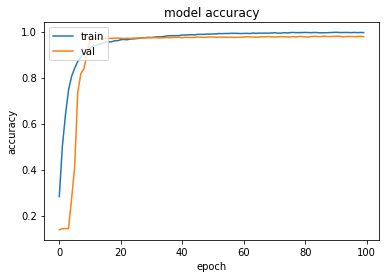

In [ ]:
m.plot_accuracy(history)

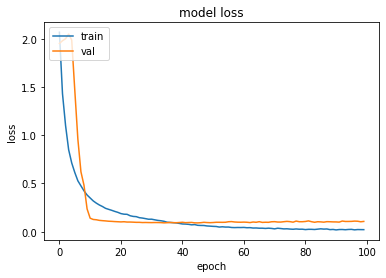

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.99      0.99      1653
 Bronchiolitis       0.99      0.98      0.98      1661
          COPD       0.94      0.98      0.96      1692
       Healthy       0.97      0.96      0.97      1725
          LRTI       1.00      0.99      1.00      1713
     Pneumonia       0.99      0.98      0.98      1641
          URTI       0.97      0.97      0.97      1766

      accuracy                           0.98     11851
     macro avg       0.98      0.98      0.98     11851
  weighted avg       0.98      0.98      0.98     11851



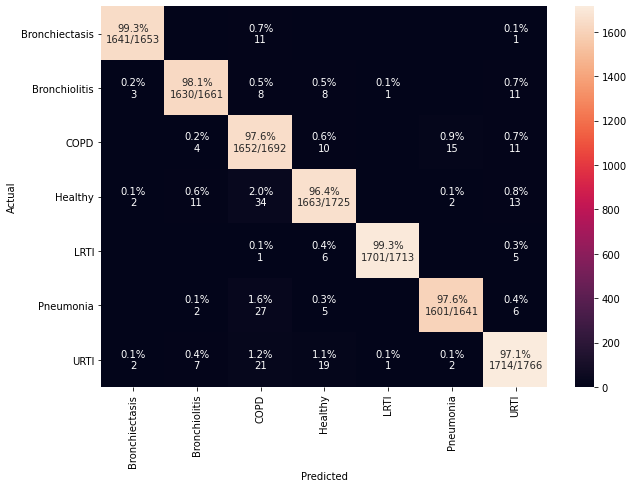

In [ ]:
y_pred=m.predict(eff)
m.confusion_matrix(y_pred)

# BOX PLOTS VAE-MLP

In [ ]:
from sklearn.model_selection import KFold


In [ ]:
def ANN(X_train):
        model = keras.Sequential([
              keras.layers.Flatten(input_shape=(X_train.shape[1],
                                                X_train.shape[2])),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(1024, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.4),
               
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(7, activation='softmax')    
                ])
        return model

In [ ]:
fold=1

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [ ]:
import keras.backend as K

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision

In [ ]:
import keras.backend as K

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall

In [ ]:
def CNN(X_train):
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                      activation='relu',
                input_shape=(X_train.shape[1],X_train.shape[2],
                            X_train.shape[3])))
        
        model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2),
                                      activation='relu'))
        
        model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())



        model.add(keras.layers.Flatten())

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model

In [ ]:
def RNN_LSTM(X_train):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1],
                                                     X_train.shape[2]),
                                    return_sequences=True))
        model.add(keras.layers.LSTM(128))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(7, activation='softmax'))
        # when in function just return the model .
        return model

In [ ]:
f1 = list()
acc= list()
prec = list()
rec = list()

In [ ]:
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    print('Fold{} : '.format(fold))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_cnn = X_train
    X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],
                                  X_train_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
    X_test_cnn = X_test
    X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],
                                  X_test_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
    model = RNN_LSTM(X_train)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy', precision ,recall, f1_score])
    model.fit(X_train, y_train, batch_size=256, epochs=100)
    test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_test, y_test) 
    f1.append(test_f1)
    acc.append(test_acc)
    prec.append(test_precision)
    rec.append(test_recall)
    print('=----------------------')
    fold = fold+1

Fold1 : 
Epoch 1/100
139/139 [==============================] - 3s 6ms/step - loss: 1.0621 - accuracy: 0.7131 - precision: nan - recall: 0.3914 - f1_score: nan
Epoch 2/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0838 - accuracy: 0.9804 - precision: 0.9841 - recall: 0.9755 - f1_score: 0.9797
Epoch 3/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0371 - accuracy: 0.9929 - precision: 0.9932 - recall: 0.9922 - f1_score: 0.9927
Epoch 4/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0276 - accuracy: 0.9943 - precision: 0.9945 - recall: 0.9938 - f1_score: 0.9942
Epoch 5/100
139/139 [==============================] - 1s 6ms/step - loss: 0.0225 - accuracy: 0.9955 - precision: 0.9958 - recall: 0.9952 - f1_score: 0.9955
Epoch 6/100
139/139 [==============================] - 1s 5ms/step - loss: 0.0189 - accuracy: 0.9959 - precision: 0.9960 - recall: 0.9957 - f1_score: 0.9959
Epoch 7/100
139/139 [==============================] - 

In [ ]:
data = pd.DataFrame(zip(f1,acc, prec, rec), columns=['f1', 'accuracy', 'prec', 'recall'])

In [ ]:
data

f1  accuracy      prec    recall
0      NaN  0.748418  0.750619  0.749244
1      NaN  0.958492  0.960374  0.956401
2  1.00000  1.000000  1.000000  1.000000
3  1.00000  1.000000  1.000000  1.000000
4  0.96961  0.969620  0.969717  0.969506
5  1.00000  1.000000  1.000000  1.000000
6  1.00000  1.000000  1.000000  1.000000
7  1.00000  1.000000  1.000000  1.000000
8      NaN  0.818734  0.816586  0.813760
9  1.00000  1.000000  1.000000  1.000000

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

y0 = data['f1'].values
y1 = data['accuracy'].values
y2 = data['prec'].values
y3 = data['recall'].values

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='F1 Score'))
fig.add_trace(go.Box(y=y1, name='Accuracy'))
fig.add_trace(go.Box(y=y2, name='Precision'))
fig.add_trace(go.Box(y=y3, name='Recall'))

fig.show()

# VAE-CNN

In [ ]:
os.mkdir('/content/drive/MyDrive/vae-cnn-gen-part2')

In [ ]:
segmented_df['Diagnosis'].value_counts()

COPD              5665
Healthy            317
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     101
LRTI                32
Asthma               6
Name: Diagnosis, dtype: int64

In [ ]:
def sampling(args):
    """Reparameterization trick by sampling 
        fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
diagnosis = 'LRTI'

In [ ]:
X_generation, y_generation = stft_extract(diagnosis=diagnosis)
print('Shape of X gen:', X_generation.shape)
print('shape of y gen:', y_generation.shape)

Shape of X gen: (32, 128, 259)
shape of y gen: (32,)


In [ ]:
X_gen_train , X_gen_test , y_gen_train, y_gen_test = train_test_split(
    X_generation, y_generation, test_size=0.3, random_state=0)

In [ ]:
X_gen_train.shape

(22, 128, 259)

In [ ]:
X_gen_train = np.reshape(X_gen_train, [-1, X_gen_train.shape[1], X_gen_train.shape[2], 1])
X_gen_test = np.reshape(X_gen_test, [-1, X_gen_test.shape[1], X_gen_test.shape[2], 1])
X_gen_train = X_gen_train.astype('float32')
X_gen_test = X_gen_test.astype('float32')

In [ ]:
X_gen_train=tf.keras.layers.ZeroPadding2D(padding=((0,0), (1,0)))(X_gen_train)
X_gen_test=tf.keras.layers.ZeroPadding2D(padding=((0,0), (1,0)))(X_gen_test)

In [ ]:
print('Shape of X generation train:', X_gen_train.shape)
print('Shape of x generation test:', X_gen_test.shape)

Shape of X generation train: (22, 128, 260, 1)
Shape of x generation test: (10, 128, 260, 1)


In [ ]:
input_shape = (X_gen_train.shape[1], X_gen_test.shape[2], 1)
batch_size = 4
kernel_size = 3
filters = 32
latent_dim = 2
epochs = 50

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)


In [ ]:
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 260, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 130, 64)  640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 65, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 266240)       0           conv2d_1[0][0]                   
____________________________________________________________________________________________

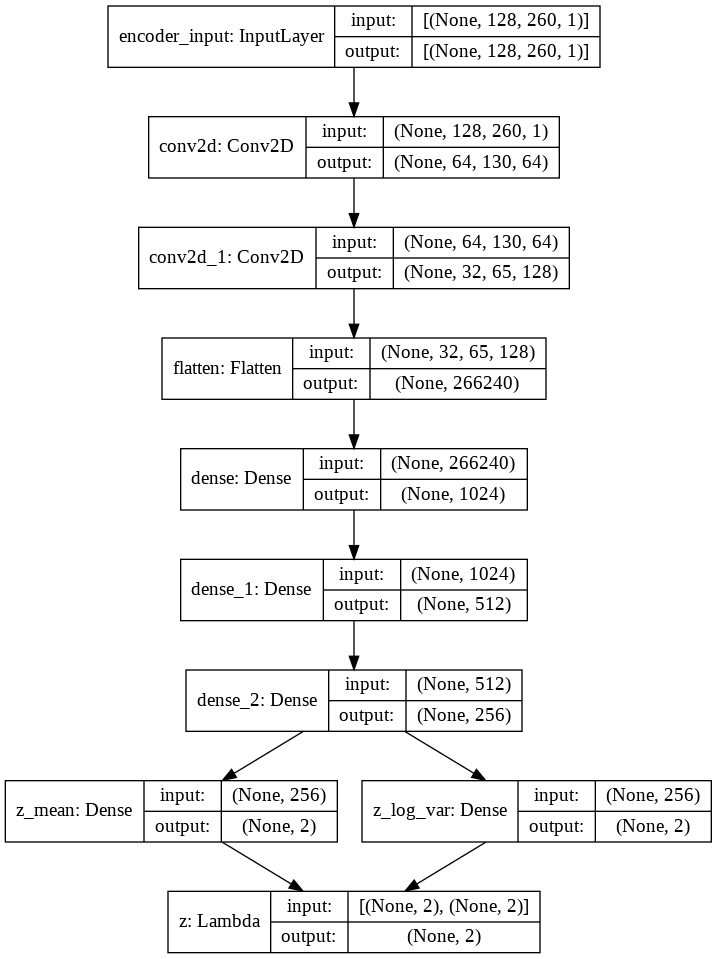

In [ ]:
# instantiate encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_cnn_encoder.png', 
           show_shapes=True)

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3],
          activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 266240)            798720    
_________________________________________________________________
reshape (Reshape)            (None, 32, 65, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 130, 128)      147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 260, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 260, 1)       577       
Total params: 1,020,673
Trainable params: 1,020,673
Non-trainable params: 0
_________________________________________________

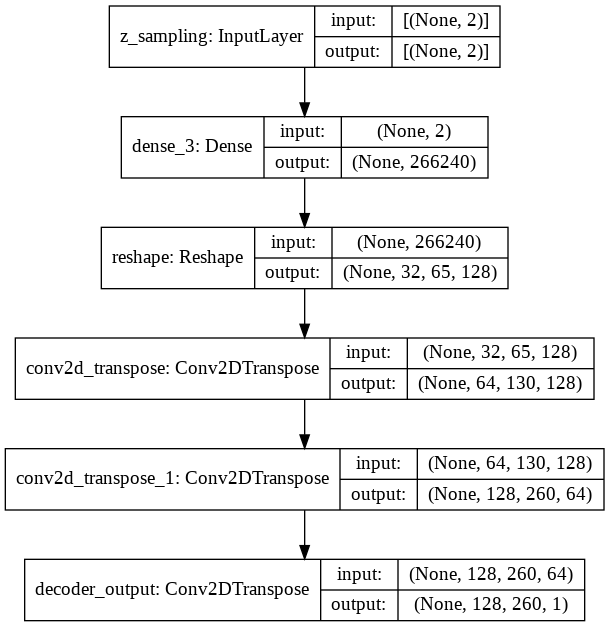

In [ ]:
# instantiate decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')
plot_model(decoder,
           to_file='vae_cnn_decoder.png', 
           show_shapes=True)


In [ ]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

In [ ]:
reconstruction_loss *= X_generation.shape[1] * X_generation.shape[2]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 260, 1) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 273362436   encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 128, 260, 1)  1020673     encoder[0][2]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 130, 64)  640         encoder_input[0][0]              
________________________________________________________________________________________________

In [ ]:
history=vae.fit(X_gen_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_gen_test, None))

Epoch 1/50
6/6 [==============================] - 66s 11s/step - loss: 2540032.1161 - val_loss: 990118.8125
Epoch 2/50
6/6 [==============================] - 62s 10s/step - loss: 2776606.6786 - val_loss: 988099.5000
Epoch 3/50
6/6 [==============================] - 62s 10s/step - loss: 1798438.3036 - val_loss: 987722.5625
Epoch 4/50
6/6 [==============================] - 62s 10s/step - loss: 2424607.1071 - val_loss: 987600.8125
Epoch 5/50
6/6 [==============================] - 62s 10s/step - loss: 2361720.5536 - val_loss: 987492.5625
Epoch 6/50
6/6 [==============================] - 62s 10s/step - loss: 1823935.2009 - val_loss: 987852.8125
Epoch 7/50
6/6 [==============================] - 63s 11s/step - loss: 2816902.5000 - val_loss: 987382.0625
Epoch 8/50
6/6 [==============================] - 62s 10s/step - loss: 2160311.3214 - val_loss: 987575.5625
Epoch 9/50
6/6 [==============================] - 62s 10s/step - loss: 2477761.9464 - val_loss: 987265.1875
Epoch 10/50
6/6 [===========

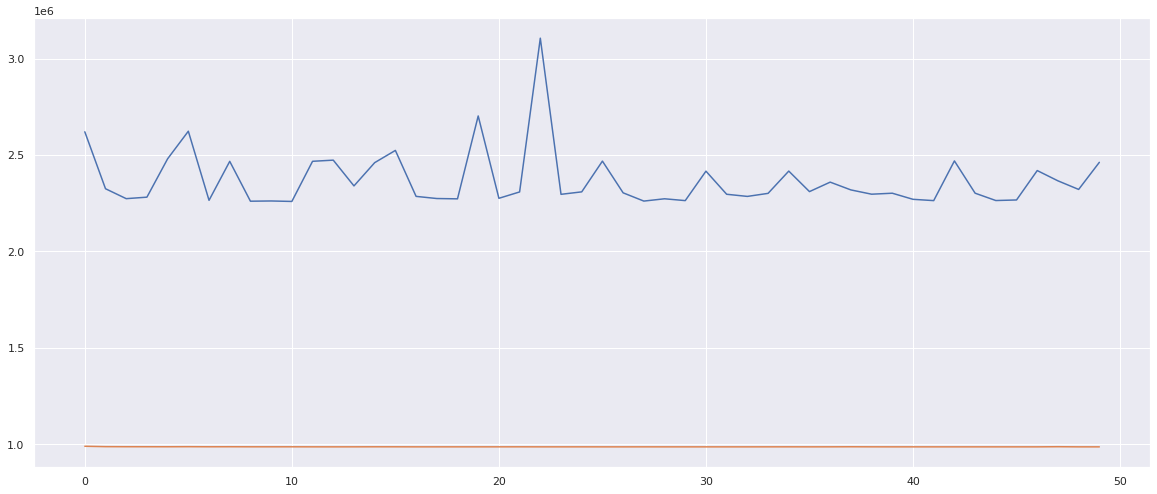

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs,
                           display=False):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], X_gen_train.shape[1], X_gen_train.shape[2])
    # Display some images
    if display:
        fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                                sharey=True, figsize=(40, 10))
        counter = 0
        for i in range(no_of_imgs):
            S_db = librosa.amplitude_to_db(np.abs(new_images[i]), ref=np.max)
            librosa.display.specshow(S_db, ax=axes[counter])
            counter = counter +1
        plt.show()
    return new_images

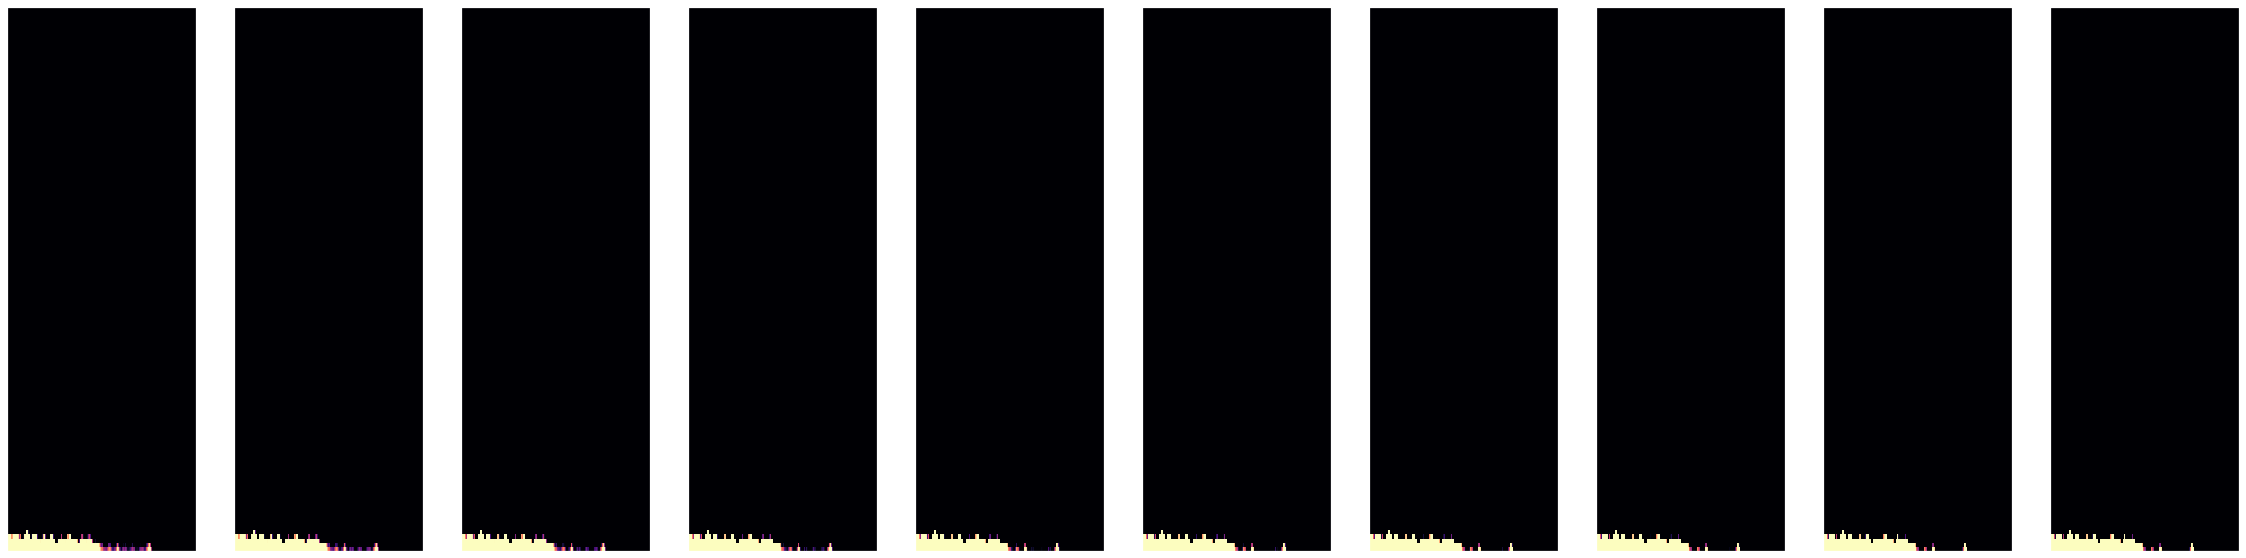

In [ ]:
new_images = display_image_sequence(20,20,50,50,10,True)

In [ ]:
music=librosa.feature.inverse.mel_to_audio(new_images[0])

In [ ]:
sf.write('trial.wav', data=music, samplerate=22050)

In [ ]:
ipd.Audio('trial.wav')

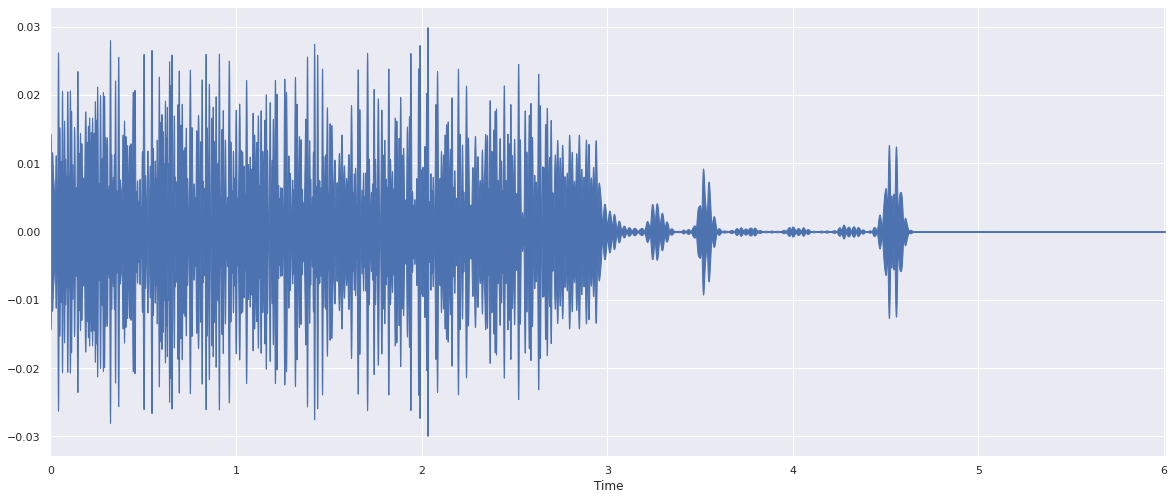

In [ ]:
librosa.display.waveplot(music, sr=22050)

In [ ]:
segmented_df['Diagnosis'].value_counts()

COPD              5641
Healthy            316
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     100
LRTI                32
Asthma               6
Name: Diagnosis, dtype: int64

In [ ]:
5641-32

5609

In [ ]:
new_images = display_image_sequence(30,30,50,50,5609,False)

In [ ]:
"""
npy file for 
1. healthy: '/content/drive/MyDrive/cnn-healthy-final.npy'
2. Pneumonia: '/content/drive/MyDrive/cnn-Pneumonia-final.npy'
3. URTI : '/content/drive/MyDrive/cnn-URTI-final.npy'
4. Bronchiolitis : '/content/drive/MyDrive/cnn-Bronchiolitis-final.npy'
5. Bronchiectasis: '/content/drive/MyDrive/cnn-Bronchiectasis-final.npy'
6. LRTI : '/content/drive/MyDrive/cnn-LRTI-final.npy'
"""

In [ ]:
len(new_images)

5541

In [ ]:
from numpy import save, load

In [ ]:
save('/content/drive/MyDrive/cnn-LRTI-final.npy', new_images)
#new_images = load('/content/drive/MyDrive/data.npy')

In [ ]:
count = 0
for i in range(len(new_images)):
    try:
        music=librosa.feature.inverse.mel_to_audio(new_images[count], sr=22050)
    except:
        print('Audio buffer is not finite everywhere')
        continue
    
    padded_data = lb.util.fix_length(music, 6*22050)
    sf.write('/content/drive/MyDrive/vae-cnn-gen-part2/{}_{}.wav'.format(diagnosis, count), data=padded_data, samplerate=22050)
    count = count + 1

Audio buffer is not finite everywhere
Audio buffer is not finite everywhere
Audio buffer is not finite everywhere
Audio buffer is not finite everywhere
Audio buffer is not finite everywhere
Audio buffer is not finite everywhere


# EVALUATION OF NEWLY GENERATED SEGMENTED DATA USING VAE-CNN ON THE MODELS



feature extraction

In [ ]:
X = list()
y = list()

In [ ]:
for index, row in segmented_df.iterrows():
    if row['Diagnosis'] == 'Asthma':
        continue
    else:
        f1 = FrequencyDomainFeatures(row['Path'])
        mfccs, _ = f1.mfcc()
        X.append(mfccs)
        y.append(row['Diagnosis'])

In [ ]:
len(X)

6799

In [ ]:
for i in os.listdir('/content/drive/MyDrive/VAE-CNN-DATA'):
    diagnosis = i
    path = os.path.join('/content/drive/MyDrive/VAE-CNN-DATA', i)
    for j in os.listdir(path):
        f1 = FrequencyDomainFeatures(os.path.join(path,j))
        mfccs, _ = f1.mfcc()
        X.append(mfccs)
        y.append(i)



NotADirectoryError: ignored

In [ ]:
len(X)

39500

In [ ]:
for i in set(y):
    print(i, y.count(i))

Bronchiectasis 5641
LRTI 5633
URTI 5640
Pneumonia 5640
Bronchiolitis 5640
Healthy 5641
COPD 5665


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from numpy import save, load

In [ ]:
save('/content/drive/MyDrive/VAE-CNN-DATA/features_X.npy',X)
save('/content/drive/MyDrive/VAE-CNN-DATA/features_y.npy', y)

In [ ]:
X = load('/content/drive/MyDrive/VAE-CNN-DATA/features_X.npy')
y = load('/content/drive/MyDrive/VAE-CNN-DATA/features_y.npy')

In [ ]:
y1=y

In [ ]:
y=le.transform(y)
y=np_utils.to_categorical(y)

In [ ]:
le.classes_

array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI',
       'Pneumonia', 'URTI'], dtype='<U14')

In [ ]:
segmented_df['Diagnosis'].value_counts()

splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.3, random_state=0)

In [ ]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of X_val :', X_val.shape)
print('Shape of y_val :', y_val.shape)
print('Shape of X_test :', X_test.shape)
print('Shape of y_test : ', y_test.shape)

Shape of X_train: (19355, 13, 130)
Shape of y_train : (19355, 7)
Shape of X_val : (8295, 13, 130)
Shape of y_val : (8295, 7)
Shape of X_test : (11850, 13, 130)
Shape of y_test :  (11850, 7)


ANN MODEL


In [ ]:
m = Model(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
ann_model = m.ANN()
m.compile_info(ann_model)

In [ ]:
m.summary_info(ann_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [ ]:
history=m.fit_train(ann_model,epochs=100, batch_size=256 )

Epoch 1/100
76/76 [==============================] - 3s 8ms/step - loss: 13.0679 - accuracy: 0.3777 - val_loss: 0.2837 - val_accuracy: 0.9327
Epoch 2/100
76/76 [==============================] - 0s 6ms/step - loss: 0.7601 - accuracy: 0.7966 - val_loss: 0.1855 - val_accuracy: 0.9531
Epoch 3/100
76/76 [==============================] - 0s 6ms/step - loss: 0.3191 - accuracy: 0.9195 - val_loss: 0.1477 - val_accuracy: 0.9623
Epoch 4/100
76/76 [==============================] - 0s 6ms/step - loss: 0.2425 - accuracy: 0.9422 - val_loss: 0.1229 - val_accuracy: 0.9656
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1954 - accuracy: 0.9495 - val_loss: 0.1131 - val_accuracy: 0.9670
Epoch 6/100
76/76 [==============================] - 0s 6ms/step - loss: 0.1770 - accuracy: 0.9549 - val_loss: 0.1050 - val_accuracy: 0.9689
Epoch 7/100
76/76 [==============================] - 0s 6ms/step - loss: 0.1548 - accuracy: 0.9586 - val_loss: 0.1066 - val_accuracy: 0.9689
Epoch 8/100


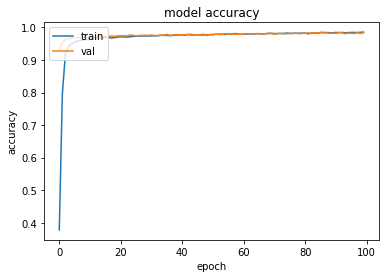

In [ ]:
m.plot_accuracy(history)

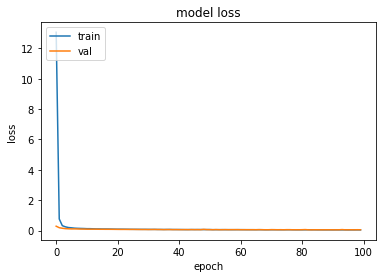

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00      1670
 Bronchiolitis       0.98      0.99      0.99      1702
          COPD       0.95      0.99      0.97      1691
       Healthy       0.97      0.97      0.97      1678
          LRTI       0.99      1.00      1.00      1721
     Pneumonia       0.99      0.98      0.99      1703
          URTI       0.99      0.97      0.98      1685

      accuracy                           0.98     11850
     macro avg       0.98      0.98      0.98     11850
  weighted avg       0.98      0.98      0.98     11850



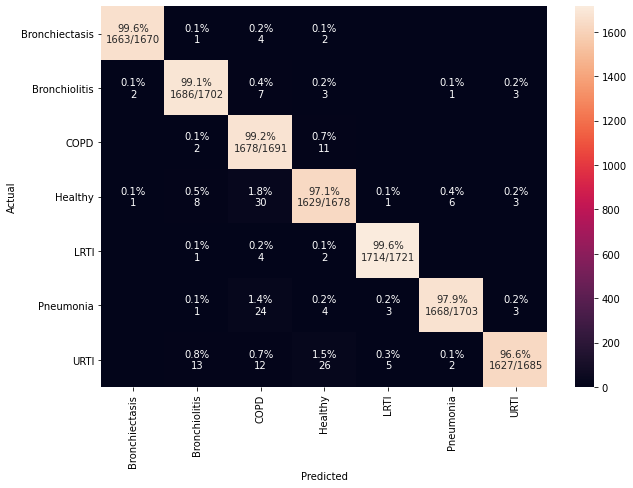

In [ ]:
y_pred=m.predict(ann_model)
m.confusion_matrix(y_pred)

CNN MODEL

In [ ]:
X_train_cnn = X_train
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],
                                  X_train_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
X_val_cnn = X_val
X_val_cnn = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1],
                                  X_val_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
X_test_cnn = X_test
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],
                                  X_test_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1

In [ ]:
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)

In [ ]:
cnn_model = m.CNN()
m.compile_info(cnn_model)

In [ ]:
m.summary_info(cnn_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 128, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 64, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 64, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 63, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 32, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 32, 32)         128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)             

In [ ]:
history=m.fit_train(cnn_model,epochs=100, batch_size=256 )

Epoch 1/100
76/76 [==============================] - 16s 12ms/step - loss: 1.4053 - accuracy: 0.4321 - val_loss: 1.0395 - val_accuracy: 0.5940
Epoch 2/100
76/76 [==============================] - 1s 7ms/step - loss: 0.6537 - accuracy: 0.7633 - val_loss: 0.2822 - val_accuracy: 0.9659
Epoch 3/100
76/76 [==============================] - 1s 7ms/step - loss: 0.3118 - accuracy: 0.9094 - val_loss: 0.1121 - val_accuracy: 0.9711
Epoch 4/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1983 - accuracy: 0.9434 - val_loss: 0.0932 - val_accuracy: 0.9722
Epoch 5/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1561 - accuracy: 0.9546 - val_loss: 0.0894 - val_accuracy: 0.9728
Epoch 6/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1412 - accuracy: 0.9590 - val_loss: 0.0859 - val_accuracy: 0.9736
Epoch 7/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1187 - accuracy: 0.9635 - val_loss: 0.0821 - val_accuracy: 0.9734
Epoch 8/100

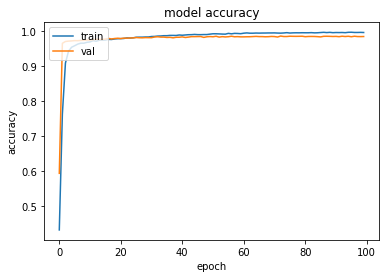

In [ ]:
m.plot_accuracy(history)

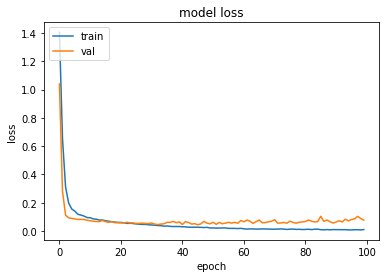

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00      1670
 Bronchiolitis       0.99      0.98      0.99      1702
          COPD       0.96      0.99      0.97      1691
       Healthy       0.98      0.97      0.98      1678
          LRTI       1.00      0.99      1.00      1721
     Pneumonia       0.99      0.98      0.99      1703
          URTI       0.98      0.99      0.98      1685

      accuracy                           0.99     11850
     macro avg       0.99      0.99      0.99     11850
  weighted avg       0.99      0.99      0.99     11850



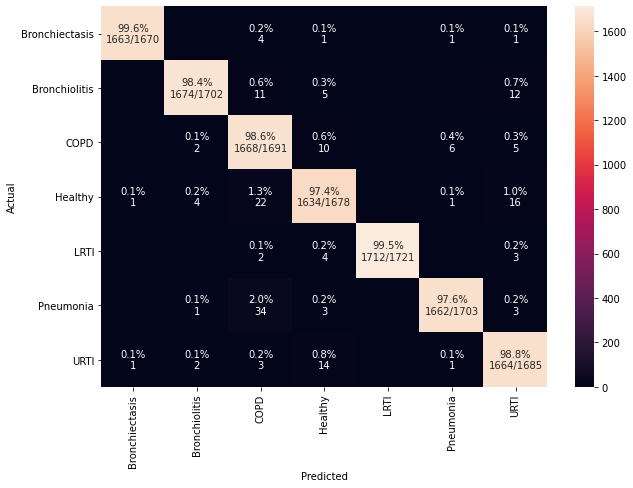

In [ ]:
y_pred=m.predict(cnn_model)
m.confusion_matrix(y_pred)

RNN MODEL

In [ ]:
m = Model(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
rnn_model = m.RNN_LSTM()
m.compile_info(rnn_model)

In [ ]:
m.summary_info(rnn_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 64)            49920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

In [ ]:
history=m.fit_train(rnn_model,epochs=100, batch_size=256 )

Epoch 1/100
76/76 [==============================] - 5s 19ms/step - loss: 1.3971 - accuracy: 0.7262 - val_loss: 0.4685 - val_accuracy: 0.8964
Epoch 2/100
76/76 [==============================] - 1s 10ms/step - loss: 0.2858 - accuracy: 0.9415 - val_loss: 0.1361 - val_accuracy: 0.9685
Epoch 3/100
76/76 [==============================] - 1s 10ms/step - loss: 0.1506 - accuracy: 0.9673 - val_loss: 0.1232 - val_accuracy: 0.9695
Epoch 4/100
76/76 [==============================] - 1s 10ms/step - loss: 0.1316 - accuracy: 0.9693 - val_loss: 0.1174 - val_accuracy: 0.9711
Epoch 5/100
76/76 [==============================] - 1s 10ms/step - loss: 0.1229 - accuracy: 0.9703 - val_loss: 0.1137 - val_accuracy: 0.9707
Epoch 6/100
76/76 [==============================] - 1s 10ms/step - loss: 0.1141 - accuracy: 0.9702 - val_loss: 0.1104 - val_accuracy: 0.9701
Epoch 7/100
76/76 [==============================] - 1s 10ms/step - loss: 0.1109 - accuracy: 0.9712 - val_loss: 0.1087 - val_accuracy: 0.9708
Epoch 

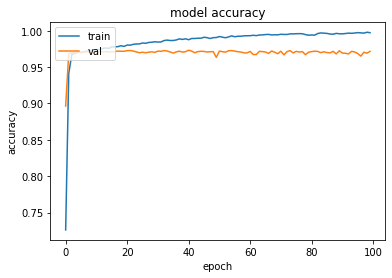

In [ ]:
m.plot_accuracy(history)

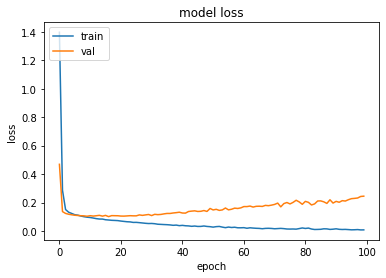

In [ ]:
m.plot_loss(history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       0.99      0.99      0.99      1670
 Bronchiolitis       0.99      0.98      0.98      1702
          COPD       0.89      0.97      0.93      1691
       Healthy       0.98      0.96      0.97      1678
          LRTI       1.00      0.99      1.00      1721
     Pneumonia       0.99      0.96      0.97      1703
          URTI       0.98      0.96      0.97      1685

      accuracy                           0.97     11850
     macro avg       0.97      0.97      0.97     11850
  weighted avg       0.97      0.97      0.97     11850



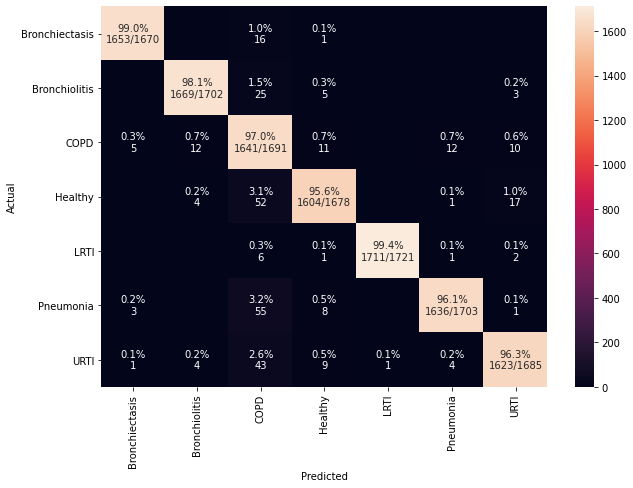

In [ ]:
y_pred=m.predict(rnn_model)
m.confusion_matrix(y_pred)

RESNET-50

In [ ]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
res_model = tf.keras.applications.ResNet50(include_top=False, weights=None,
                                       input_tensor=input_t)
to_res = (13,130)

In [ ]:
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
res = m.RESNET_50(to_res)
m.compile_info(res)

In [ ]:
history=m.fit_train(res, epochs=100, batch_size=256)

Epoch 1/100
76/76 [==============================] - 17s 116ms/step - loss: 0.8086 - accuracy: 0.7359 - val_loss: 1.9888 - val_accuracy: 0.1482
Epoch 2/100
76/76 [==============================] - 6s 83ms/step - loss: 0.1367 - accuracy: 0.9639 - val_loss: 2.1845 - val_accuracy: 0.1482
Epoch 3/100
76/76 [==============================] - 6s 83ms/step - loss: 0.1164 - accuracy: 0.9679 - val_loss: 3.0026 - val_accuracy: 0.1482
Epoch 4/100
76/76 [==============================] - 6s 83ms/step - loss: 0.1054 - accuracy: 0.9685 - val_loss: 3.4083 - val_accuracy: 0.2253
Epoch 5/100
76/76 [==============================] - 6s 83ms/step - loss: 0.0978 - accuracy: 0.9696 - val_loss: 2.4220 - val_accuracy: 0.2928
Epoch 6/100
76/76 [==============================] - 6s 83ms/step - loss: 0.0907 - accuracy: 0.9715 - val_loss: 0.2575 - val_accuracy: 0.9421
Epoch 7/100
76/76 [==============================] - 6s 82ms/step - loss: 0.0838 - accuracy: 0.9730 - val_loss: 0.0829 - val_accuracy: 0.9725
Epoc

In [ ]:
m.summary_info(res)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 13, 130, 1)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 5, 2048)        23581440  
_________________________________________________________________
flatten_2 (Flatten)          (None, 10240)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10240)             40960     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2621696   
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

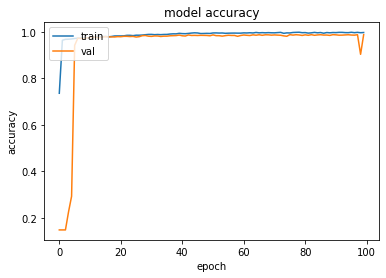

In [ ]:
m.plot_accuracy(history)

In [ ]:
m.plot_loss(accuracy)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00      1670
 Bronchiolitis       0.99      0.99      0.99      1702
          COPD       0.97      0.99      0.98      1691
       Healthy       0.99      0.98      0.98      1678
          LRTI       1.00      1.00      1.00      1721
     Pneumonia       0.99      0.98      0.99      1703
          URTI       0.99      0.98      0.98      1685

      accuracy                           0.99     11850
     macro avg       0.99      0.99      0.99     11850
  weighted avg       0.99      0.99      0.99     11850



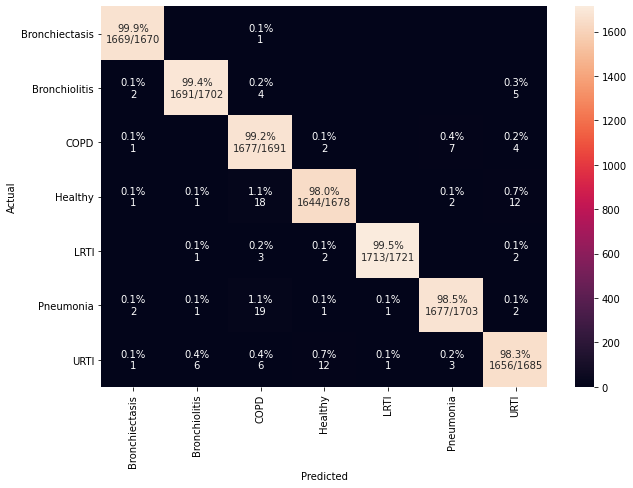

In [ ]:
y_pred=m.predict(res)
m.confusion_matrix(y_pred)

efficient net b0

In [ ]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
to_res = (13,130)


In [ ]:
eff = m.EFFICIENT_NET_BO(to_res, input_t)
m.compile_info(eff)


In [ ]:
history=m.fit_train(eff, epochs=100, batch_size=256)


In [ ]:
m.summary_info(eff)

In [ ]:
m.plot_accuracy(history)


In [ ]:
m.plot_loss(history)

In [ ]:
y_pred=m.predict(eff)
m.confusion_matrix(y_pred)

In [ ]:
input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
m = Model(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
to_res = (13,130)

In [ ]:
eff = m.EFFICIENT_NET_BO(to_res, input_t)
m.compile_info(eff)

In [ ]:
history=m.fit_train(eff, epochs=100, batch_size=256)

Epoch 1/100
76/76 [==============================] - 19s 108ms/step - loss: 1.4947 - accuracy: 0.4720 - val_loss: 1.9750 - val_accuracy: 0.1482
Epoch 2/100
76/76 [==============================] - 7s 87ms/step - loss: 0.8995 - accuracy: 0.7289 - val_loss: 2.0128 - val_accuracy: 0.1482
Epoch 3/100
76/76 [==============================] - 7s 87ms/step - loss: 0.6512 - accuracy: 0.8408 - val_loss: 2.0567 - val_accuracy: 0.1482
Epoch 4/100
76/76 [==============================] - 7s 88ms/step - loss: 0.5125 - accuracy: 0.8911 - val_loss: 2.1354 - val_accuracy: 0.1482
Epoch 5/100
76/76 [==============================] - 7s 87ms/step - loss: 0.4263 - accuracy: 0.9212 - val_loss: 2.0265 - val_accuracy: 0.2827
Epoch 6/100
76/76 [==============================] - 7s 87ms/step - loss: 0.3738 - accuracy: 0.9337 - val_loss: 1.7784 - val_accuracy: 0.2931
Epoch 7/100
76/76 [==============================] - 7s 87ms/step - loss: 0.3213 - accuracy: 0.9452 - val_loss: 0.9249 - val_accuracy: 0.7093
Epoc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.99      1.00      1670
 Bronchiolitis       0.99      0.98      0.99      1702
          COPD       0.94      0.98      0.96      1691
       Healthy       0.97      0.97      0.97      1678
          LRTI       1.00      0.99      1.00      1721
     Pneumonia       0.98      0.97      0.98      1703
          URTI       0.99      0.98      0.98      1685

      accuracy                           0.98     11850
     macro avg       0.98      0.98      0.98     11850
  weighted avg       0.98      0.98      0.98     11850



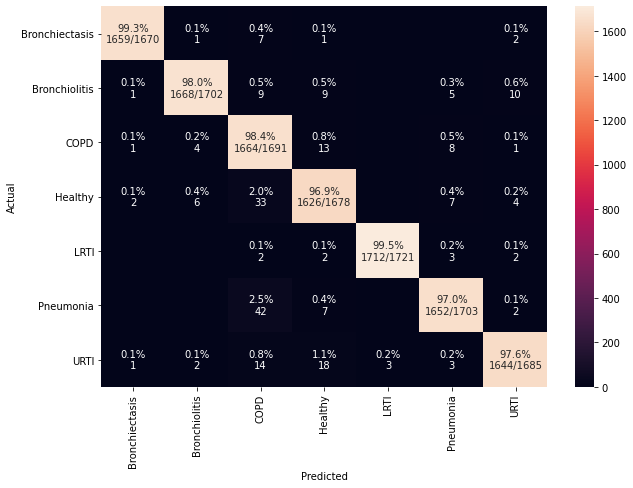

In [ ]:
y_pred=m.predict(eff)
m.confusion_matrix(y_pred)

# CONDITIONAL VAE - CVAE

In [ ]:
os.mkdir('/content/drive/MyDrive/CVAE-DATA')

In [ ]:
def sampling(args):
    """Implements reparameterization trick by sampling
    from a gaussian with zero mean and std=1.
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        sampled latent vector (tensor)
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
def plot_results(models,
                 data,
                 y_label,
                 batch_size=128,
                 model_name="cvae_mnist"):
    """Plots 2-dim mean values of Q(z|X) using labels 
        as color gradient then, plot MNIST digits as 
        function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        y_label (array): one-hot vector of which digit to plot
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict([x_test, to_categorical(y_test)],
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "%05d.png" % np.argmax(y_label))
    # display a 10x10 2D manifold of the digit (y_label)
    n = 10
    #digit_size = 28
    figure = np.zeros((x_test.shape[1] * n, x_test.shape[2] * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, y_label])
            digit = x_decoded[0].reshape(x_test.shape[1],x_test.shape[2])
            figure[i * x_test.shape[1]: (i + 1) * x_test.shape[1],
                   j * x_test.shape[2]: (j + 1) * x_test.shape[2]] = digit
    plt.figure(figsize=(10, 10))
    start_range = x_test.shape[1] // 2
    end_range = n * x_test.shape[1] + start_range + 1
    pixel_range = np.arange(start_range, end_range, x_test.shape[1])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    #plt.imshow(figure, cmap='Greys_r')
    librosa.display.specshow(figure)
    plt.savefig(filename)
    plt.show()
    return figure


In [ ]:
X_generation, y_generation = stft_extract(diagnosis='all')
print('Shape of X gen:', X_generation.shape)
print('shape of y gen:', y_generation.shape)

Shape of X gen: (1132, 128, 259)
shape of y gen: (1132,)


In [ ]:
X_gen_train , X_gen_test , y_gen_train, y_gen_test = train_test_split(
    X_generation, y_generation, test_size=0.3, random_state=0)

In [ ]:
X_gen_train = np.reshape(X_gen_train, [-1, X_generation.shape[1],
                                       X_generation.shape[2], 1])
X_gen_test = np.reshape(X_gen_test, [-1, X_generation.shape[1],
                                     X_generation.shape[2], 1])
X_gen_train = X_gen_train.astype('float32')
X_gen_test = X_gen_test.astype('float32')

In [ ]:
X_gen_train=tf.keras.layers.ZeroPadding2D(padding=((0,0), (1,0)))(X_gen_train)
X_gen_test=tf.keras.layers.ZeroPadding2D(padding=((0,0), (1,0)))(X_gen_test)

In [ ]:
X_gen_train.shape

TensorShape([792, 128, 260, 1])

In [ ]:
num_labels = len(np.unique(y_gen_train))

In [ ]:
input_shape = (X_gen_train.shape[1], X_gen_train.shape[2], 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

In [ ]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(X_gen_train.shape[1] * X_gen_train.shape[2])(y_labels)
x = Reshape((X_gen_train.shape[1], X_gen_train.shape[2], 1))(x)
x = tf.keras.layers.concatenate([inputs, x])
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [ ]:
# shape info needed to build decoder model
shape = K.int_shape(x)

In [ ]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


In [ ]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 33280)        232960      class_labels[0][0]               
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 128, 260, 1) 0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 128, 260, 1)  0           dense_24[0][0]                   
____________________________________________________________________________________________

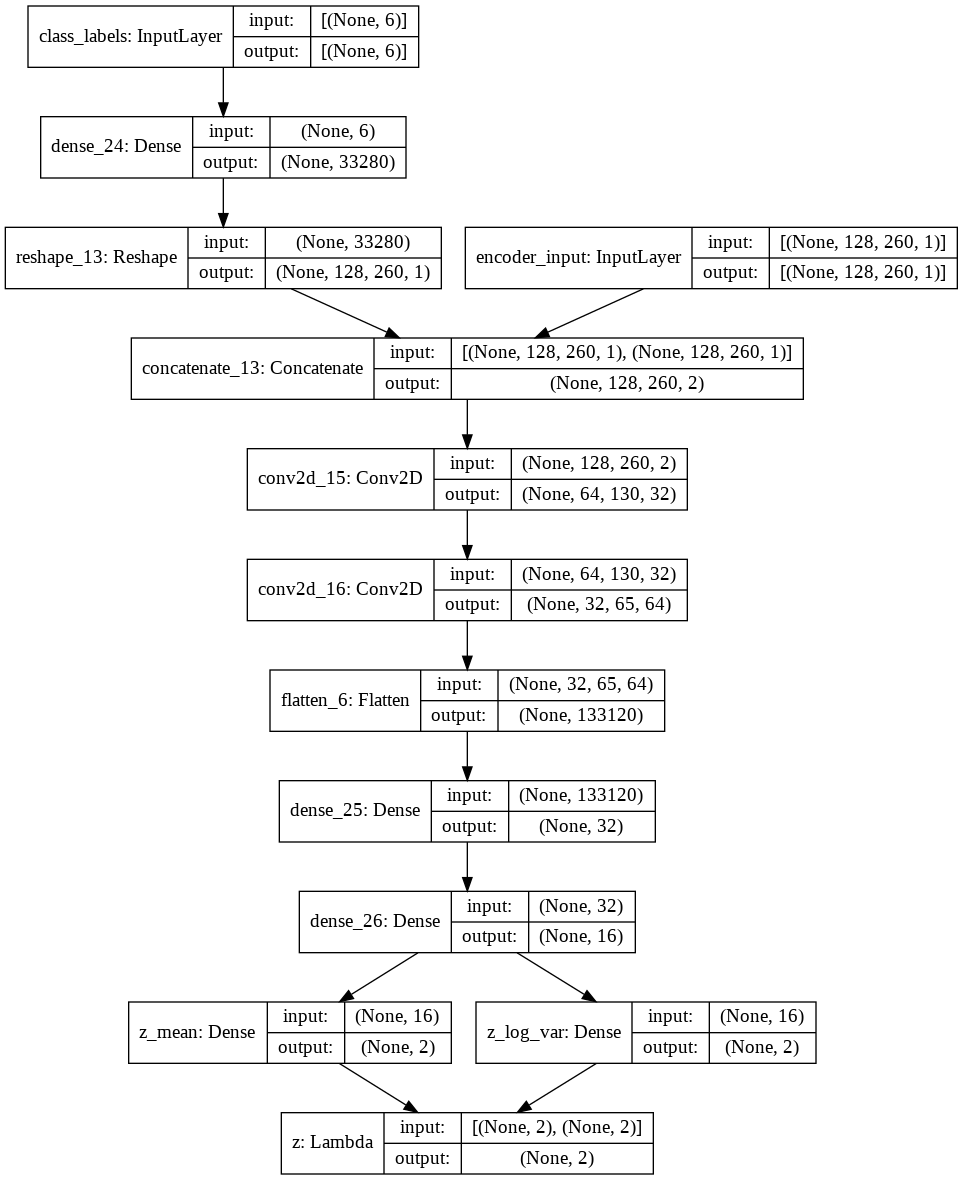

In [ ]:
# instantiate encoder model
encoder = tf.keras.Model([inputs, y_labels],
                [z_mean, z_log_var, z], 
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='cvae_cnn_encoder.png', 
           show_shapes=True)

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 8)            0           z_sampling[0][0]                 
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 133120)       1198080     concatenate_14[0][0]       

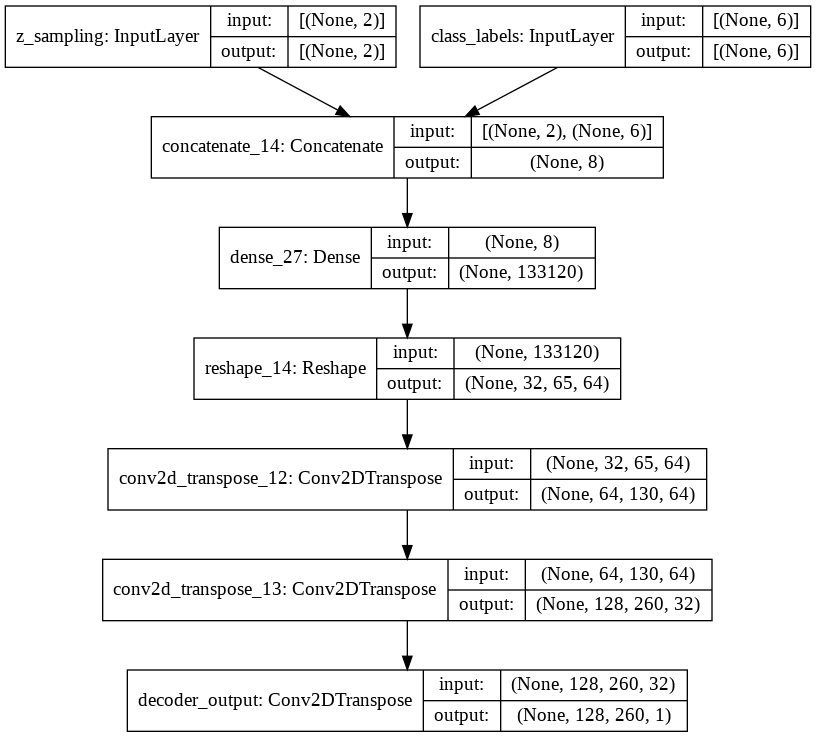

In [ ]:
# instantiate decoder model
decoder = tf.keras.Model([latent_inputs, y_labels],
                outputs, 
                name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='cvae_cnn_decoder.png', 
           show_shapes=True)

In [ ]:
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae')


In [ ]:
beta = 1.0

In [ ]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

In [ ]:
reconstruction_loss *= X_gen_train.shape[1] * X_gen_train.shape[2]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta
cvae_loss = K.mean(reconstruction_loss + kl_loss)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 260, 1) 0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 4512532     encoder_input[0][0]              
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
decoder (Functional)            (None, 128, 260, 1)  1253761     encoder[0][2]                 

In [ ]:
cvae.fit([X_gen_train, to_categorical(y_gen_train)],
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=([X_gen_test, to_categorical(y_gen_test)], None))

Epoch 1/30
7/7 [==============================] - 65s 9s/step - loss: 7756534.6875 - val_loss: 10587719.0000
Epoch 2/30
7/7 [==============================] - 62s 9s/step - loss: 7624846.5625 - val_loss: 10585603.0000
Epoch 3/30
7/7 [==============================] - 62s 9s/step - loss: 7622956.1250 - val_loss: 10585135.0000
Epoch 4/30
7/7 [==============================] - 61s 9s/step - loss: 8591493.1875 - val_loss: 10584936.0000
Epoch 5/30
7/7 [==============================] - 61s 9s/step - loss: 6931639.5938 - val_loss: 10584759.0000
Epoch 6/30
7/7 [==============================] - 62s 9s/step - loss: 6991484.9375 - val_loss: 10584712.0000
Epoch 7/30
7/7 [==============================] - 61s 9s/step - loss: 8762099.5625 - val_loss: 10584652.0000
Epoch 8/30
7/7 [==============================] - 62s 9s/step - loss: 7279066.6250 - val_loss: 10584690.0000
Epoch 9/30
7/7 [==============================] - 70s 10s/step - loss: 8769305.5000 - val_loss: 10584492.0000
Epoch 10/30
7/7 [=

In [ ]:
digit = np.array([0])

In [ ]:
models = (encoder, decoder)
data = (X_gen_test, y_gen_test)

CVAE for digit 0


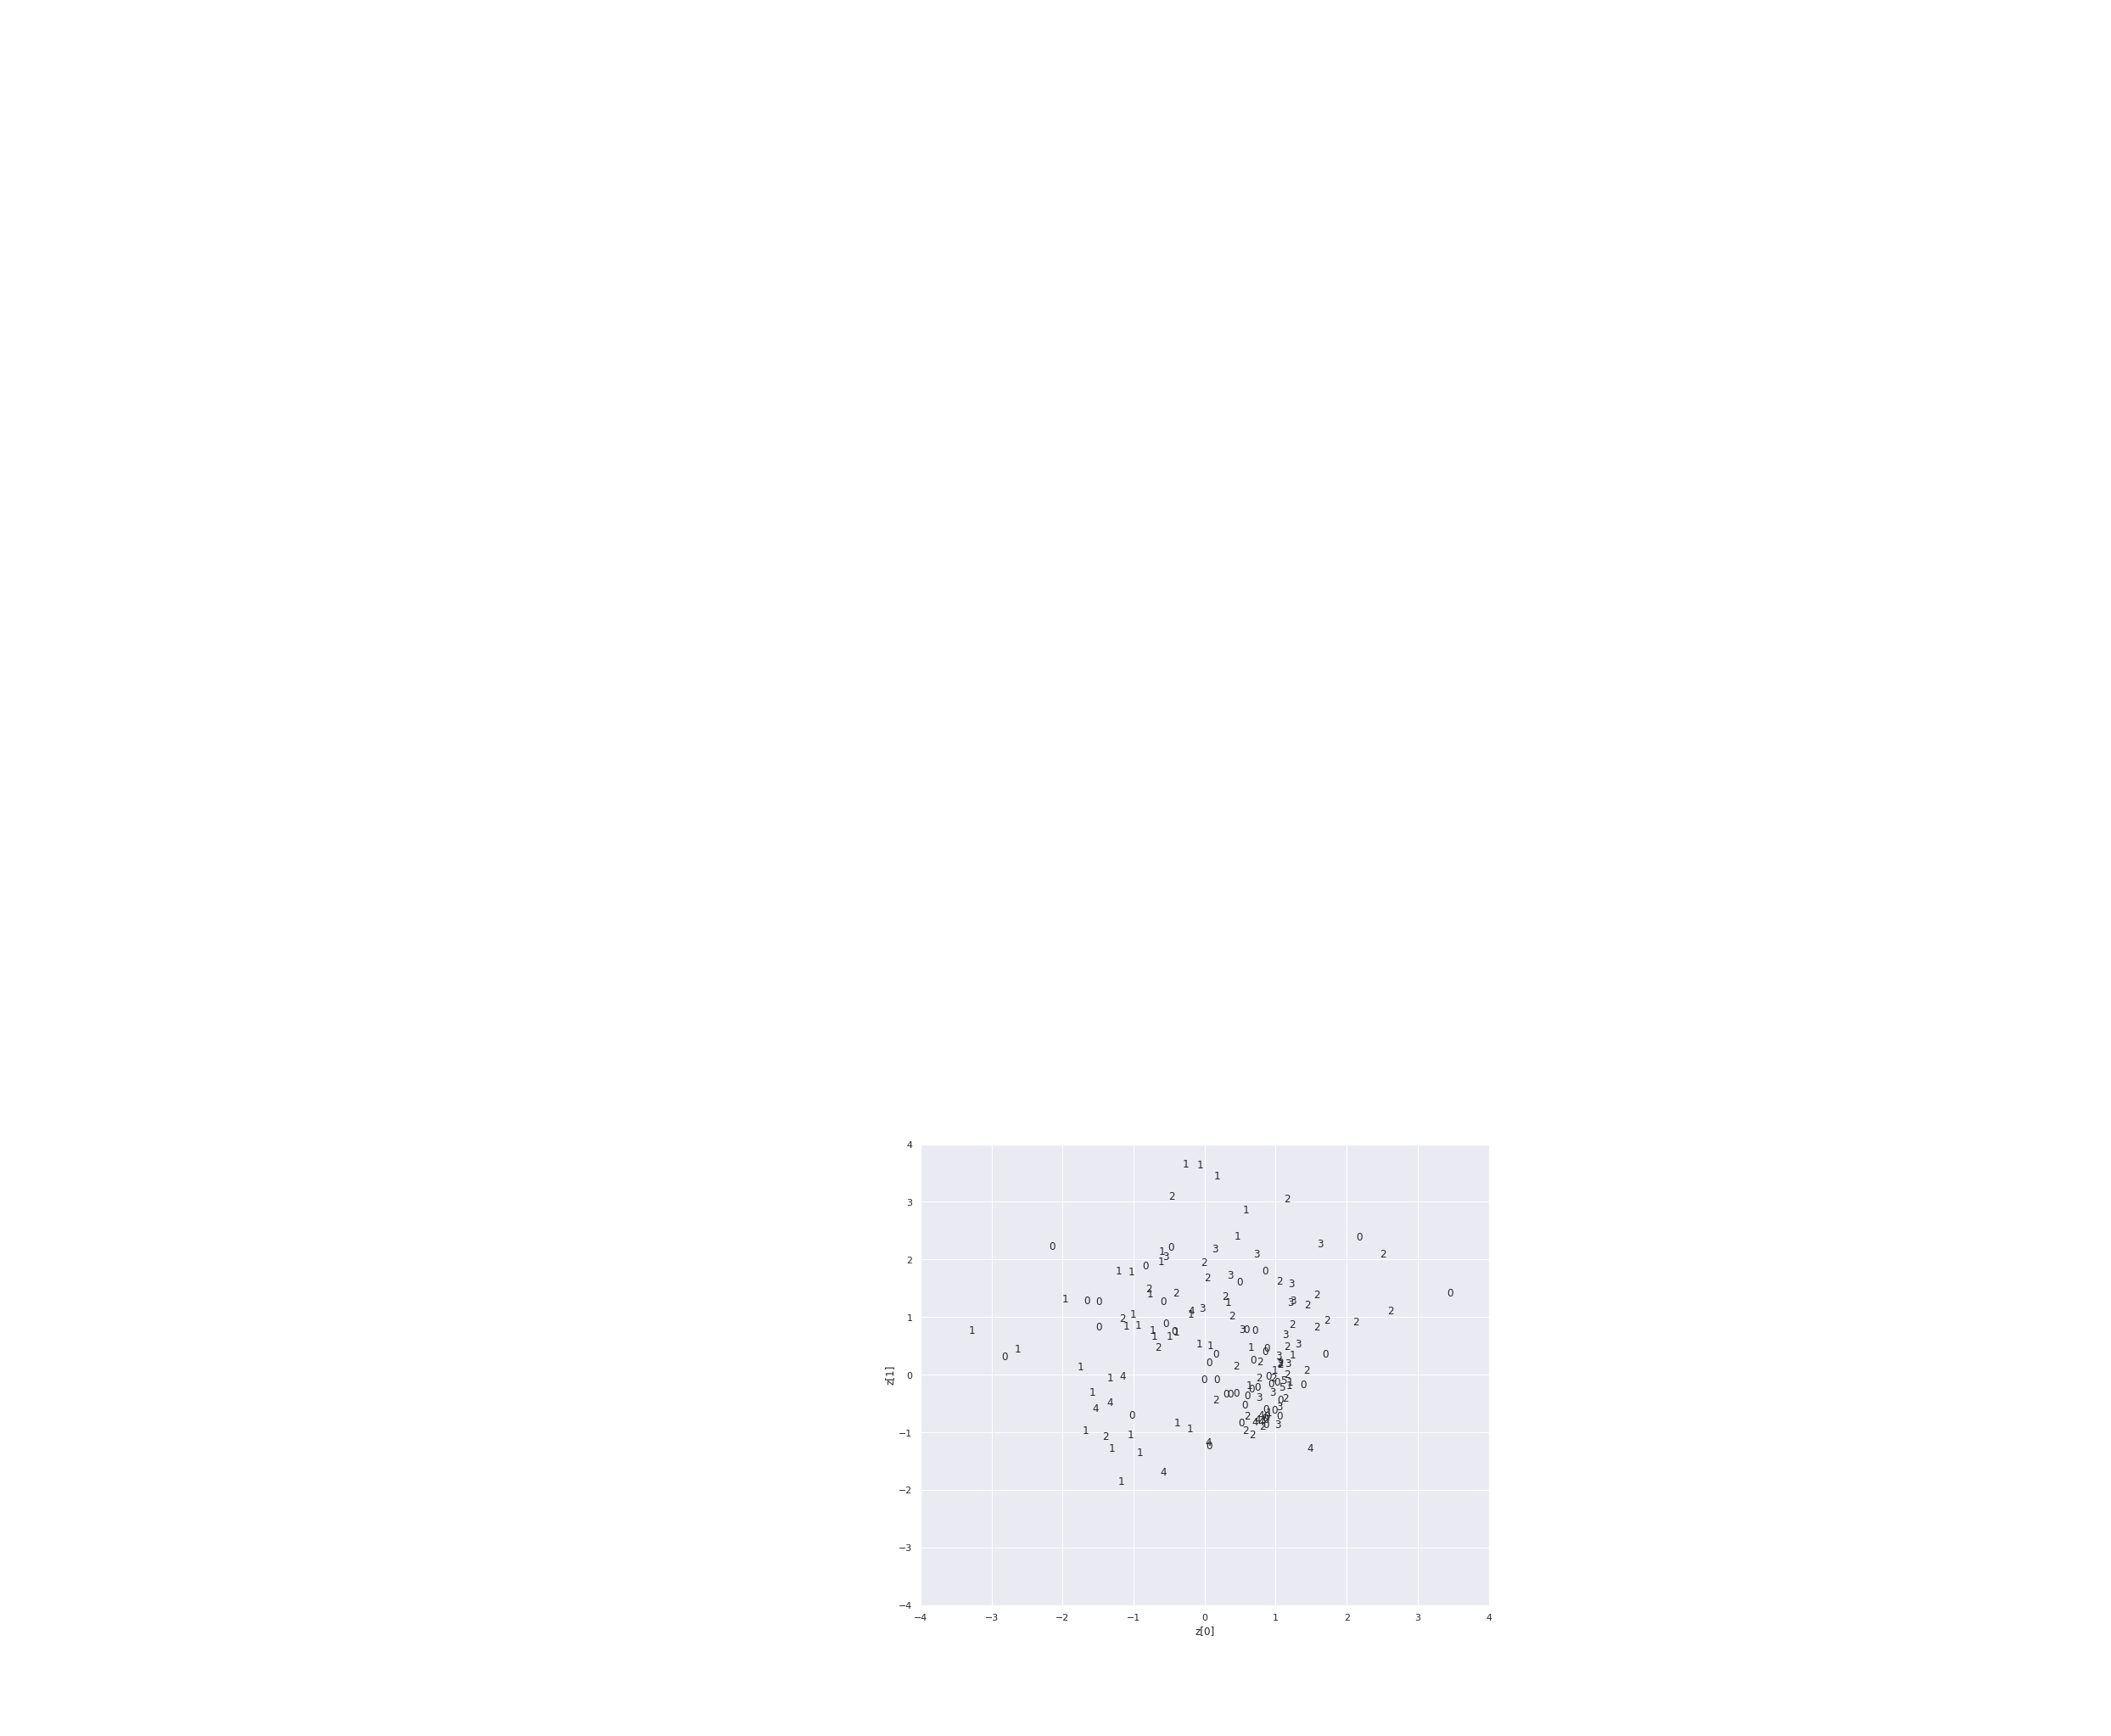

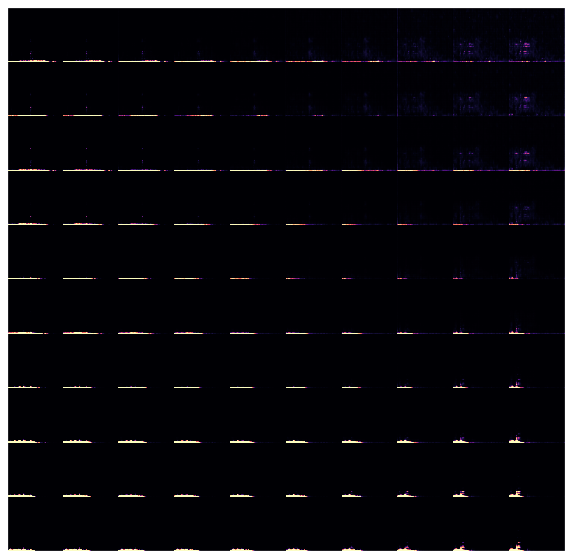

In [ ]:
print("CVAE for digit %d" % digit)
y_label = np.eye(num_labels)[digit]
fig=plot_results(models,
                 data,
                 y_label=y_label,
                 batch_size=batch_size,
                 model_name='cvae')

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs, y_label,
                           display=False):
    x_try = list()

    grid_x = np.linspace(x_start, x_end, round(math.sqrt(no_of_imgs)))
    grid_y = np.linspace(y_start, y_end, round(math.sqrt(no_of_imgs)))
    total = round(math.sqrt(10)) * round(math.sqrt(10))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, y_label])
            x_try.append(x_decoded[0].reshape(X_gen_test.shape[1], X_gen_test.shape[2]))
    x_try = np.array(x_try)
    # Display some images
    if display:
        fig, axes = plt.subplots(ncols=total, sharex=False,
                                sharey=True, figsize=(40, 10))
        counter = 0
        for i in range(total):
            S_db = librosa.amplitude_to_db(np.abs(x_try[i]), ref=np.max)
            librosa.display.specshow(S_db, ax=axes[counter])
            counter = counter +1
        plt.show()
    return x_try

In [ ]:
digit = np.array([5])

In [ ]:
y_label = np.eye(num_labels)[digit]

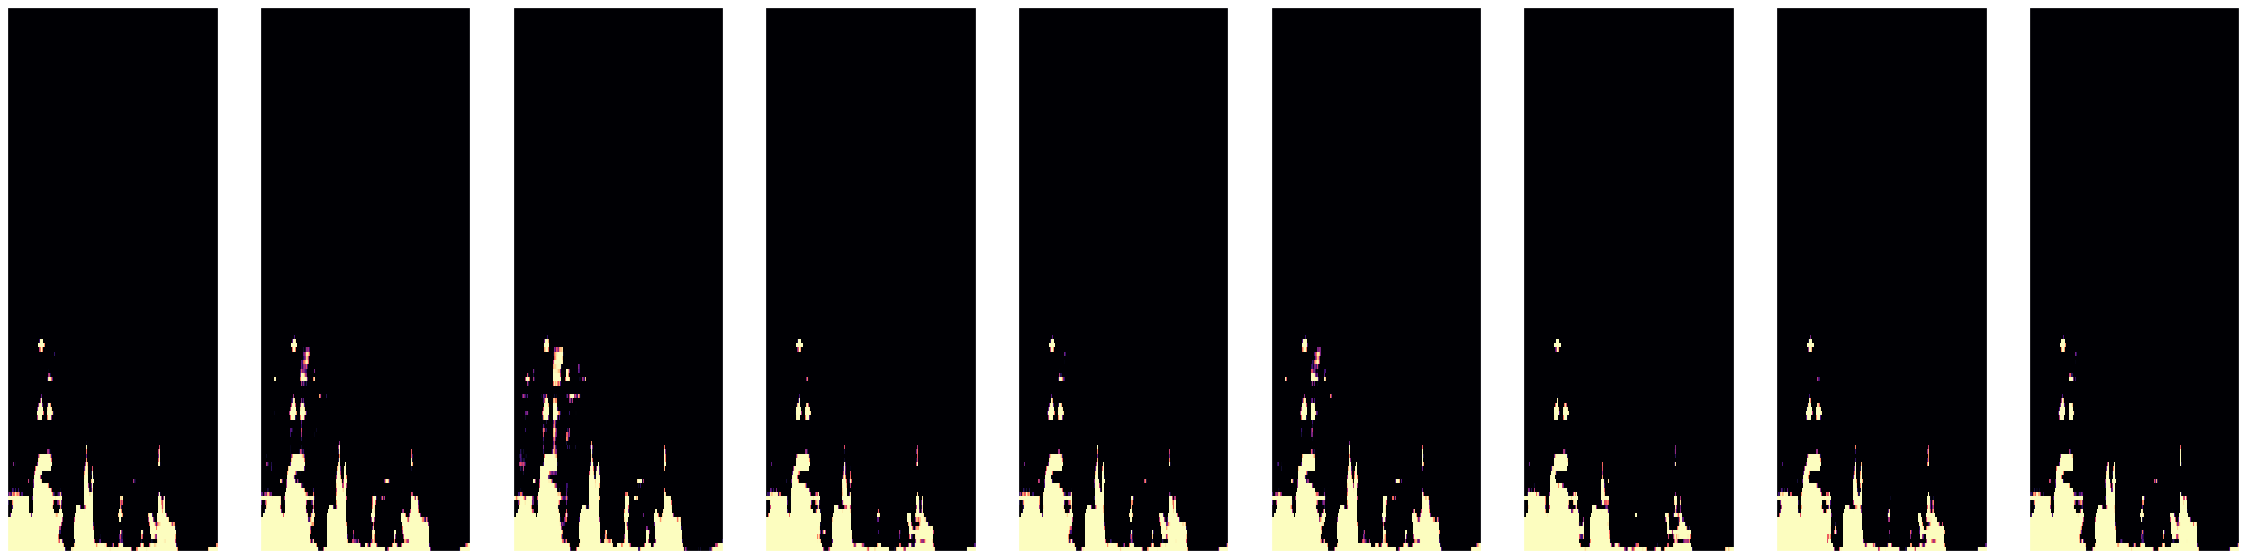

In [ ]:
new_images = display_image_sequence(80,80,100,100,10, y_label, True)

In [ ]:
segmented_df['Diagnosis'].value_counts()

COPD              5641
Healthy            316
Pneumonia          284
URTI               240
Bronchiolitis      160
Bronchiectasis     100
LRTI                32
Asthma               6
Name: Diagnosis, dtype: int64

In [ ]:
new_images = display_image_sequence(80,80,100,100,5609, y_label, False)

In [ ]:
from numpy import save, load

In [ ]:
save('/content/drive/MyDrive/CVAE-DATA/LRTI.npy', new_images)

In [ ]:
music=librosa.feature.inverse.mel_to_audio(new_images[0])

In [ ]:
sf.write('trial.wav', data=music, samplerate=22050)

In [ ]:
ipd.Audio('trial.wav')

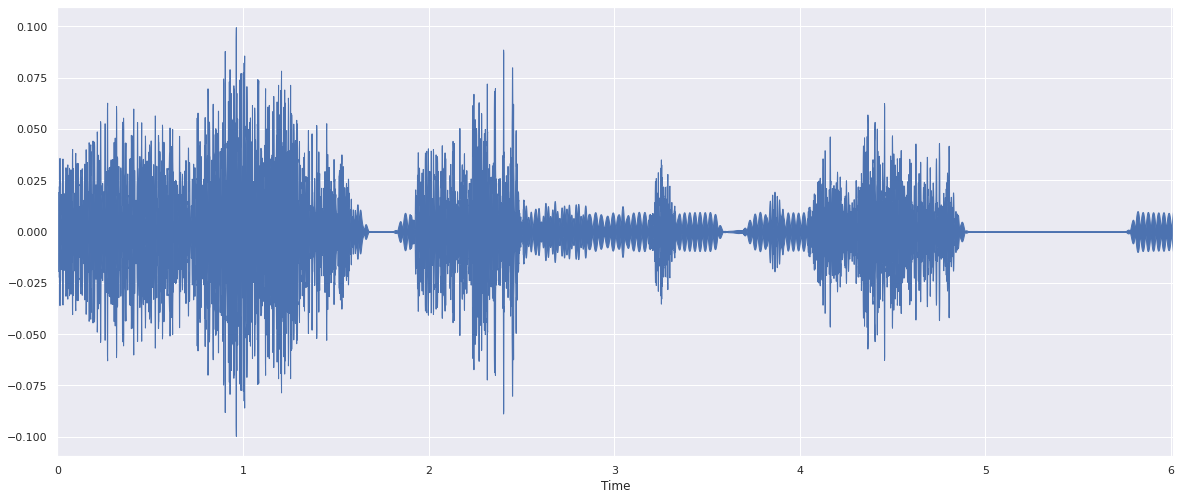

In [ ]:
librosa.display.waveplot(music, sr=22050)

# EVALUATION OF NEWLY GENERATED SEGMENTED DATA USING CVAE ON THE MODELS

# boxplots

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def ANN(X_train):
        model = keras.Sequential([
              keras.layers.Flatten(input_shape=(X_train.shape[1],
                                                X_train.shape[2])),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(1024, activation='relu'),
               keras.layers.Dropout(0.1),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.3),

               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dropout(0.4),
               
               keras.layers.Dense(512, activation='relu'),
               keras.layers.Dense(7, activation='softmax')    
                ])
        return model

In [ ]:
def CNN(X_train):
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),
                                      activation='relu',
                input_shape=(X_train.shape[1],X_train.shape[2],
                            X_train.shape[3])))
        
        model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Conv2D(filters=32, kernel_size=(2,2),
                                      activation='relu'))
        
        model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
        model.add(keras.layers.BatchNormalization())



        model.add(keras.layers.Flatten())

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.4))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model

In [ ]:
def RNN_LSTM(X_train):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1],
                                                     X_train.shape[2]),
                                    return_sequences=True))
        model.add(keras.layers.LSTM(128))
        model.add(keras.layers.Dropout(0.3))

        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dropout(0.1))
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(7, activation='softmax'))
        # when in function just return the model .
        return model

In [ ]:
def RESNET_50(X_train_cnn):
    input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
    res_model = tf.keras.applications.ResNet50(include_top=False, weights=None,
                                       input_tensor=input_t)
    to_res = (13,130)
    model = keras.models.Sequential()
    model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,
                                                                    to_res)))
    model.add(res_model)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(256, activation='relu'))


    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(128, activation='relu'))


    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(64, activation='relu'))


    model.add(keras.layers.Dense(512, activation='relu'))


    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(512, activation='relu'))


    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(512, activation='relu'))

        
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(7, activation='softmax'))
    return model

In [ ]:
def EFFICIENT_NET_BO(X_train_cnn):
        input_t = keras.Input(shape=(X_train_cnn.shape[1],X_train_cnn.shape[2],
                             X_train_cnn.shape[3]))
        to_res = (13,130)
        eff_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                         weights=None,
                                       input_tensor=input_t)
        model = keras.models.Sequential()
        model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,
                                                                    to_res)))
        model.add(eff_model)
        model.add(keras.layers.Flatten())
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(256, activation='relu'))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.5))

        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dropout(0.5))
        
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(7, activation='softmax'))
        return model
    

In [ ]:
fold=1


In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [ ]:
import keras.backend as K

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision

In [ ]:
import keras.backend as K

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return np.float32(0)

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall

In [ ]:
fs = list()
acc= list()
prec = list()
rec = list()

In [ ]:
fold=1

In [ ]:
len(X)

39500

In [ ]:
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    print('Fold{} : '.format(fold))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_cnn = X_train
    X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],
                                  X_train_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
    X_test_cnn = X_test
    X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],
                                  X_test_cnn.shape[2], 1) # it is a 4d array
                                  # number of samples, number of mfccs,
                                  # number of time bins, 1
    model = EFFICIENT_NET_BO(X_train_cnn)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy', precision ,recall, f1_score])
    model.fit(X_train_cnn, y_train, batch_size=256, epochs=100)
    test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_test_cnn, y_test) 
    fs.append(test_f1)
    acc.append(test_acc)
    prec.append(test_precision)
    rec.append(test_recall)
    print('=----------------------')
    fold = fold+1

Fold1 : 
Epoch 1/100
139/139 [==============================] - 23s 86ms/step - loss: 1.1546 - accuracy: 0.6202 - precision: 0.7880 - recall: 0.3900 - f1_score: 0.5162
Epoch 2/100
139/139 [==============================] - 11s 78ms/step - loss: 0.5347 - accuracy: 0.8781 - precision: 0.9648 - recall: 0.7192 - f1_score: 0.8228
Epoch 3/100
139/139 [==============================] - 11s 78ms/step - loss: 0.3471 - accuracy: 0.9426 - precision: 0.9840 - recall: 0.8467 - f1_score: 0.9099
Epoch 4/100
139/139 [==============================] - 11s 78ms/step - loss: 0.2542 - accuracy: 0.9672 - precision: 0.9901 - recall: 0.9068 - f1_score: 0.9465
Epoch 5/100
139/139 [==============================] - 11s 78ms/step - loss: 0.1966 - accuracy: 0.9784 - precision: 0.9928 - recall: 0.9380 - f1_score: 0.9645
Epoch 6/100
139/139 [==============================] - 11s 77ms/step - loss: 0.1585 - accuracy: 0.9844 - precision: 0.9938 - recall: 0.9586 - f1_score: 0.9759
Epoch 7/100
139/139 [================

In [ ]:
data = pd.DataFrame(zip(fs,acc, prec, rec), columns=['f1', 'accuracy', 'prec', 'recall'])

In [ ]:
data

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

y0 = data['f1'].values
y1 = data['accuracy'].values
y2 = data['prec'].values
y3 = data['recall'].values

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='F1 Score'))
fig.add_trace(go.Box(y=y1, name='Accuracy'))
fig.add_trace(go.Box(y=y2, name='Precision'))
fig.add_trace(go.Box(y=y3, name='Recall'))

fig.show()